# Set up

## Main Imports

### Libraries

importing ~50,000 data from the original data set of the food organisation

Columns are filtered to only select data of interest

In [1]:
%matplotlib inline

#Data Manipulation Librairies
import pandas as pd
from pandas.plotting import scatter_matrix, andrews_curves
from sklearn.model_selection import train_test_split

#Calculation Utility Librairies
import numpy as np
import scipy.stats as st
import scipy

#Model Analysis Librairies
from fairml import audit_model
from fairml import plot_dependencies

#Graphing Librairies
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyoff

import json
import requests
import random

from yapf.yapflib.yapf_api import FormatCode

cf.go_offline()
pyoff.init_notebook_mode()

In [2]:
from time import time, sleep
from IPython import get_ipython
from IPython.display import Audio, display, HTML
from ipywidgets import IntProgress

class Beeper:

    def __init__(self, threshold, **audio_kwargs):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None
        self.audio = audio_kwargs

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()
            

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
            print((end_time - self.start_time)/60, " minutes.")
        self.start_time = None

beeper = Beeper(5, filename='beep-07.wav')

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)


In [3]:
from jupyter_helpers.following_tail import FollowingTail

display_no_more_than_ten = FollowingTail(n=10)
display_no_more_than_ten.activate()

Output()

### Data Segmentation

In [4]:
All_Columns = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
    'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
    'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
    'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
    'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
    'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
    'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
    'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
    'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment',
    'ComplianceStatus', 'Outlier', '2010 Census Tracts',
    'Seattle Police Department Micro Community Policing Plan Areas',
    'City Council Districts', 'SPD Beats', 'Zip Codes'
]

Neuron_Columns = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
    'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
    'GHGEmissionsIntensity'
]

Leaked_Neuron_Columns = [
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
    'GHGEmissionsIntensity'
]

OneHotColumns = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode']

NormalizeColumns = [
    'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
    'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
    'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'
]

OutputColumns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

# Building Type, PrimaryPropertyType, CouncilDistrictCode

## Data import

In [5]:
input_tf = pd.read_csv("./input_cleaned_data.csv" , sep = "\t")
output_tf = pd.read_csv("./output_cleaned_data.csv" , sep = "\t")

## Data For ML

Preparing different sets for further training, validation and evaluation.

In [47]:
output_tf

SiteEnergyUseWN(kBtu)  TotalGHGEmissions
0                  0.800357           1.358303
1                  0.892827           1.470304
2                  2.213728           2.769540
3                  0.756700           1.448774
4                  1.216680           1.825701
...                     ...                ...
3271              -0.273213          -0.873721
3272              -0.097417          -0.019349
3273               1.247333           1.662833
3274              -0.553463          -1.183376
3275              -0.422324          -1.043388

[3276 rows x 2 columns]

In [48]:
log_ghg_data_2016 = output_tf["TotalGHGEmissions"]
log_energy_data_2016 = output_tf["SiteEnergyUseWN(kBtu)"]

In [6]:
X = input_tf.drop(['OSEBuildingID', 'DataYear'], axis = 1)
y = output_tf

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [7]:
#Used for predicting each feature on its own
y_train_energy = y_train['SiteEnergyUseWN(kBtu)'].values
y_test_energy = y_test['SiteEnergyUseWN(kBtu)'].values

y_train_GHG = y_train['TotalGHGEmissions'].values
y_test_GHG = y_test['TotalGHGEmissions'].values

#Muted data without energy data
X_train_complete = X_train.drop(Leaked_Neuron_Columns, axis = 1).values
X_test_complete = X_test.drop(Leaked_Neuron_Columns, axis = 1).values

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

data_sets = [
    [X_train, y_train_energy , X_test, y_test_energy,len(X_train[0])],
    [X_train_complete, y_train_energy , X_test_complete, y_test_energy,len(X_train_complete[0])],
    [X_train, y_train_GHG , X_test, y_test_GHG, len(X_train[0])],
    [X_train_complete, y_train_GHG , X_test_complete, y_test_GHG,len(X_train_complete[0])]
]

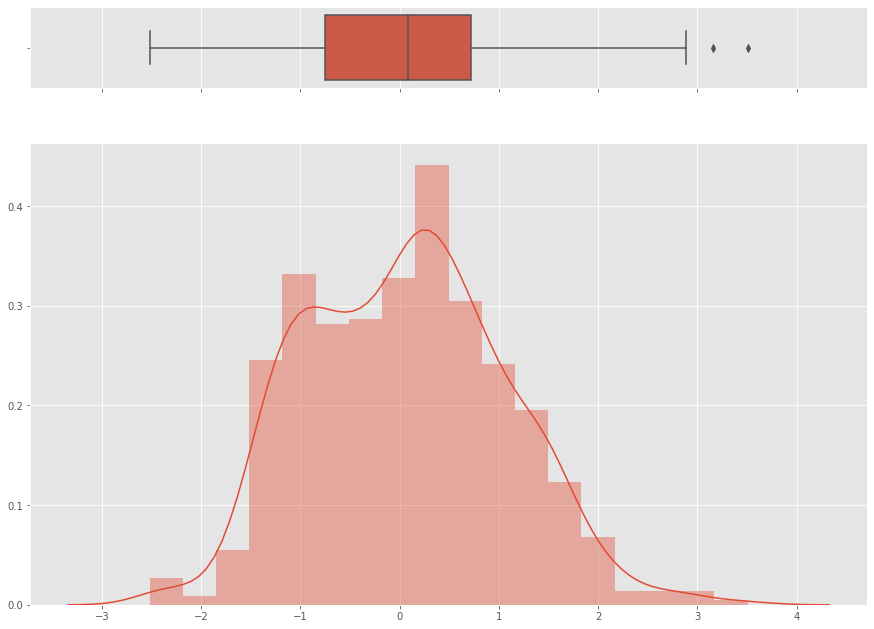

In [8]:
a4_dims = (15, 11)

binNumb = int(np.ceil(1 + np.log2(len(y_test_GHG))))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(y_test_GHG, ax=ax_box)
ax2 = sns.distplot(y_test_GHG)
#inner_data_2016[OutputColumns[0]].plot.hist(bins = binNumb)

## Utility Functions For ML

In [9]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f(x):
    # return math.sqrt(x)
    if(x == 0) : return 0
    else : return (1/x)
def array_map(x):
    return np.array([f(xi) for xi in x])

def mean_percentage(y_true, y_pred):
    #record_score = []
    
    diff = K.abs(np.subtract(y_true, y_pred))
    perc = Multiply()([diff, array_map(y_true)])
    #perc = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([diff, 1/y_true])

    return K.mean(100*perc)

def mean_percentage_np(y_true, y_pred):
    #record_score = []
    
    diff = np.abs(np.subtract(y_true ,y_pred))
    perc = np.multiply(diff, array_map(y_true))
    #perc = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([diff, 1/y_true])

    return np.mean(100*perc)
   # for i in range(0, y_true):
      #  diff = np.abs(y_true[i] - y_pred[i])
      #  perc = diff/y_true[i]
      #  record_score.append(1 - perc)
        #return record_score[0]
   # return np.mean(record_score)

def evaluate_tf(model, test_features, test_labels):
    predictions_list = model.predict(test_features)
    predictions = []
    for sublist in predictions_list:
        for item in sublist:
            predictions.append(item)

    errors = abs(predictions - test_labels)

    mape = 100 * np.mean(np.divide(errors, test_labels))

    mse = np.sqrt(np.mean(np.square(np.subtract(predictions, test_labels))))
    return mse, mape

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)

    errors = abs(predictions - test_labels)

    mape = 100 * np.mean(np.divide(test_labels, errors))

    mse = np.sqrt(np.mean(np.square(np.subtract(predictions, test_labels))))

    print('Model Performance : \n')
    print('MSE = ', mse)
    print('Mape = ', mape)
    print()

    return mse, mape

def evaluate_random(random_y, true_y):
    errors = abs(random_y - true_y)
    mape = 100 * np.mean(np.divide(true_y, errors))
    mse = np.sqrt(np.mean(np.square(np.subtract(random_y, true_y))))

    print('Model Performance : \n')
    print('MSE = ', mse)
    print('Mape = ', mape)
    print()

    return mse, mape

# Models

## K Fold

In [10]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [11]:
n_folds = 5
kf = KFold(n_folds)

## Logistic Regression

In [14]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn import preprocessing

In [15]:
lab_enc = preprocessing.LabelEncoder()
encoded_train_energy = lab_enc.fit_transform(y_train_energy)
encoded_train_GHG = lab_enc.fit_transform(y_train_GHG)

In [16]:
lin_energy = LinearRegression(n_jobs = -1)
lin_energy.fit(X_train, encoded_train_energy)

lin_GHG = LinearRegression(n_jobs = -1)
lin_GHG.fit(X_train, encoded_train_GHG)

lin_complete_energy = LinearRegression(n_jobs = -1)
lin_complete_energy.fit(X_train_complete, encoded_train_energy)

lin_complete_GHG = LinearRegression(n_jobs = -1)
lin_complete_GHG.fit(X_train_complete, encoded_train_GHG)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [17]:
evaluate(lin_complete_energy, X_test_complete, y_test_energy)
evaluate(lin_energy, X_test, y_test_energy)


evaluate(lin_GHG, X_test, y_test_GHG)
evaluate(lin_complete_GHG,X_test_complete, y_test_GHG)

Model Performance : 

MSE =  1447.7512889290758
Mape =  -0.010070769913719925

Model Performance : 

MSE =  1477.4984214927051
Mape =  -0.01504023970050286

Model Performance : 

MSE =  1209.0945320989108
Mape =  -0.0384576117253658

Model Performance : 

MSE =  1158.656523814824
Mape =  -0.01940488690548837



(1158.656523814824, -0.01940488690548837)

[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Linear Regression Energy Prediction Error Difference')]

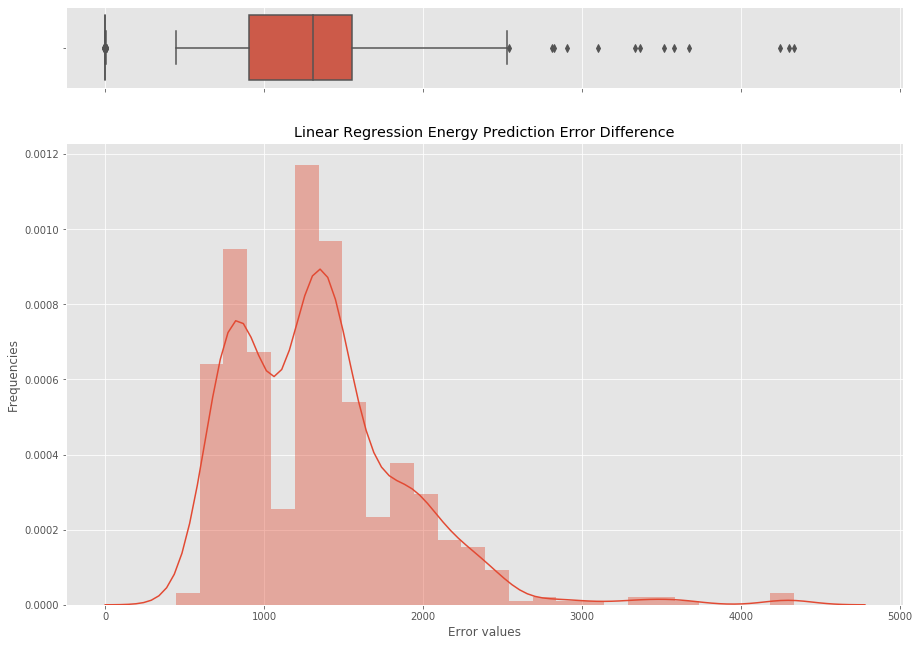

In [23]:
energy_predict = lin_complete_energy.predict(X_test_complete)
df_diff = pd.DataFrame(energy_predict - y_test_energy)
mean = df_diff.mean().values
median = df_diff.median().values

binNumb = int(np.ceil(1 + np.log2(len(energy_predict))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(y_test_energy, ax=ax_box)
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Linear Regression Energy Prediction Error Difference")


In [19]:
Ela_energy = ElasticNetCV(cv = 5, random_state = 42)
Ela_energy.fit(X_train, encoded_train_energy)

Ela_GHG = ElasticNetCV(cv = 5, random_state = 42)
Ela_GHG.fit(X_train, encoded_train_GHG)

Ela_complete_energy = ElasticNetCV(cv = 5, random_state = 42)
Ela_complete_energy.fit(X_train_complete, encoded_train_energy)

Ela_complete_GHG = ElasticNetCV(cv = 5, random_state = 42)
Ela_complete_GHG.fit(X_train_complete, encoded_train_GHG)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=False, positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [20]:
evaluate(Ela_complete_energy, X_test_complete, y_test_energy)
evaluate(Ela_energy, X_test, y_test_energy)

evaluate(Ela_complete_GHG,X_test_complete, y_test_GHG)
evaluate(Ela_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  1366.8723445403928
Mape =  -0.0042295144125410414

Model Performance : 

MSE =  1403.5551778207698
Mape =  -0.008841752069848958

Model Performance : 

MSE =  1097.104946845237
Mape =  -0.009047498634931792

Model Performance : 

MSE =  1136.7695344329475
Mape =  -0.020939852332316516



(1136.7695344329475, -0.020939852332316516)

[1316.31123314] [1295.34900695]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'ElasticNet Regression Energy Prediction Error Difference')]

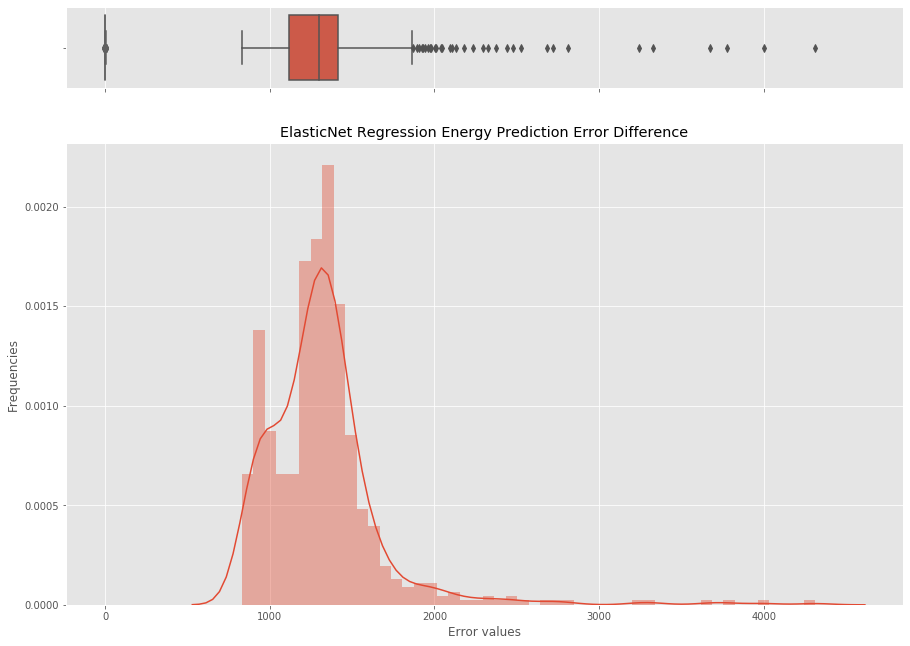

In [24]:
df_diff = pd.DataFrame(Ela_complete_energy.predict(X_test_complete) - y_test_energy)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(Ela_complete_energy.predict(X_test_complete)))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(y_test_energy, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="ElasticNet Regression Energy Prediction Error Difference")



## KNN 

### Regular KNN Exploration

In [87]:
from sklearn import neighbors, dummy

In [88]:
for i in range(2, 100, 2):
    knn_energy = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_energy.fit(X_train, y_train_energy)
    mse, mape = evaluate(knn_energy, X_test, y_test_energy)
    if(i == 2): maxValue1 = [mse, i]
    if maxValue1[0] > mse:
        bestModel = knn_energy
        maxValue1 = [mse, i]
        print('new best value : ', maxValue1)
print(maxValue1)

for i in range(2, 100, 2):
    knn_GHG = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_GHG.fit(X_train, y_train_GHG)
    mse, mape = evaluate(knn_GHG, X_test, y_test_energy)
    if(i == 2): maxValue2 = [mse, i]
    if maxValue2[0] > mse:
        bestModel = knn_GHG
        maxValue2 = [mse, i]
        print('new best value : ', maxValue2)
print(maxValue2)

for i in range(2, 100, 2):
    knn_energy_complete = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_energy_complete.fit(X_train_complete, y_train_energy)
    mse, mape = evaluate(knn_energy_complete, X_test_complete, y_test_energy)
    if(i == 2): maxValue3 = [mse, i]
    if maxValue3[0] > mse:
        bestModel = knn_energy_complete
        maxValue3 = [mse, i]
        print('new best value : ', maxValue3)
print(maxValue3)

for i in range(2, 100, 2):
    knn_GHG_complete = neighbors.KNeighborsRegressor(n_neighbors = i)
    knn_GHG_complete.fit(X_train_complete, y_train_GHG)
    mse, mape = evaluate(knn_GHG_complete, X_test_complete, y_test_energy)
    if(i == 2): maxValue4 = [mse, i]
    if maxValue4[0] > mse:
        bestModel = knn_GHG_complete
        maxValue4 = [mse, i]
        print('new best value : ', maxValue4)
print(maxValue4)

Model Performance : 

MSE =  0.8201905568318076
Mape =  22691.368759204677

Model Performance : 

MSE =  0.8202789618256894
Mape =  329.2805342780627

Model Performance : 

MSE =  0.7919776846037853
Mape =  708.3244399471082

new best value :  [0.7919776846037853, 6]
Model Performance : 

MSE =  0.7412086342439834
Mape =  -406.5914882315763

new best value :  [0.7412086342439834, 8]
Model Performance : 

MSE =  0.7414676677311275
Mape =  57.56856500230614

Model Performance : 

MSE =  0.7386628701811833
Mape =  -427.24133091108473

new best value :  [0.7386628701811833, 12]
Model Performance : 

MSE =  0.7421813249607552
Mape =  -290.75016830942894

Model Performance : 

MSE =  0.7431396724232731
Mape =  -483.3008601097437

Model Performance : 

MSE =  0.743272575202761
Mape =  -129.4887419669215

Model Performance : 

MSE =  0.7358329029262157
Mape =  -710.6174050447798

new best value :  [0.7358329029262157, 20]
Model Performance : 

MSE =  0.7422732876582809
Mape =  -200.68591955211

Model Performance : 

MSE =  0.8424922255121682
Mape =  7521.128182406285

new best value :  [0.8424922255121682, 84]
Model Performance : 

MSE =  0.8416320181723476
Mape =  122.11213745287499

new best value :  [0.8416320181723476, 86]
Model Performance : 

MSE =  0.8410039828423134
Mape =  75.32978273696364

new best value :  [0.8410039828423134, 88]
Model Performance : 

MSE =  0.8401696586536322
Mape =  95.40238365167703

new best value :  [0.8401696586536322, 90]
Model Performance : 

MSE =  0.8385626329982006
Mape =  20.986791089919237

new best value :  [0.8385626329982006, 92]
Model Performance : 

MSE =  0.8383496399963157
Mape =  93.32429522825872

new best value :  [0.8383496399963157, 94]
Model Performance : 

MSE =  0.8375708261636114
Mape =  -91.15177962746851

new best value :  [0.8375708261636114, 96]
Model Performance : 

MSE =  0.8372888165186925
Mape =  65.83707214262452

new best value :  [0.8372888165186925, 98]
[0.8372888165186925, 98]
Model Performance : 

MSE = 

Model Performance : 

MSE =  0.8965176216007056
Mape =  220.94866383889618

Model Performance : 

MSE =  0.8962764021902752
Mape =  31.7225459844318

Model Performance : 

MSE =  0.8957013513689175
Mape =  49.11406741067256

Model Performance : 

MSE =  0.8952704815408534
Mape =  82.14248890374446

Model Performance : 

MSE =  0.8948061773852484
Mape =  37.3895220146583

Model Performance : 

MSE =  0.8947456135148211
Mape =  145.39174121561425

Model Performance : 

MSE =  0.8947337227714767
Mape =  24.55468395002707

Model Performance : 

MSE =  0.8936321563768426
Mape =  -88.27530464446733

Model Performance : 

MSE =  0.8925587327928758
Mape =  -78.96046136652205

Model Performance : 

MSE =  0.8929553693333285
Mape =  -47.85303530139775

Model Performance : 

MSE =  0.8924491724983847
Mape =  -242.48231058304356

[0.882114264984216, 26]


0.3092270493507385  minutes.


In [89]:
knn_energy = neighbors.KNeighborsRegressor(n_neighbors = maxValue1[1])
knn_energy.fit(X_train, y_train_energy)

knn_GHG = neighbors.KNeighborsRegressor(n_neighbors = maxValue2[1])
knn_GHG.fit(X_train, y_train_GHG)

knn_energy_complete = neighbors.KNeighborsRegressor(n_neighbors = maxValue3[1])
knn_energy_complete.fit(X_train_complete, y_train_energy)

knn_GHG_complete = neighbors.KNeighborsRegressor(n_neighbors = maxValue4[1])
knn_GHG_complete.fit(X_train_complete, y_train_GHG)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=26, p=2,
          weights='uniform')

In [90]:
evaluate(knn_energy_complete, X_test_complete, y_test_energy)
evaluate(knn_energy, X_test, y_test_energy)

evaluate(knn_GHG_complete, X_test_complete, y_test_GHG)
evaluate(knn_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  0.790638083613448
Mape =  344.2411651206084

Model Performance : 

MSE =  0.7358329029262157
Mape =  -710.6174050447798

Model Performance : 

MSE =  0.7210944465310339
Mape =  -14.080370780842898

Model Performance : 

MSE =  0.5388668266537346
Mape =  -211.39769433325034



(0.5388668266537346, -211.39769433325034)

[-0.09082843] [-0.08429723]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'KNN GHG Prediction Error Difference')]

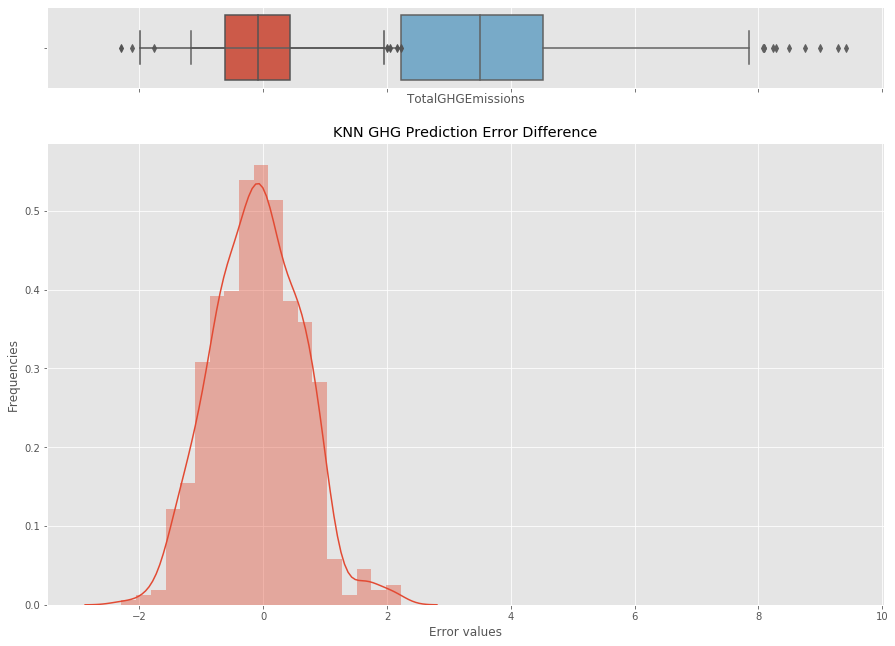

In [91]:
prediction = knn_GHG_complete.predict(X_test_complete)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_ghg_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="KNN GHG Prediction Error Difference")


### Random Output KNN

In [92]:
np.random.seed(42)
y_pred_random = np.random.randint(np.min(y_test_GHG), np.max(y_test_GHG), y_test_GHG.shape)
#mean_percentage_np(y_test_energy, y_pred_random)
evaluate_random(y_pred_random, y_test_GHG)

Model Performance : 

MSE =  1.7647666758532283
Mape =  148.7919118117237



(1.7647666758532283, 148.7919118117237)

[-0.03160671] [-0.18888712]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Random Prediction Error Difference')]

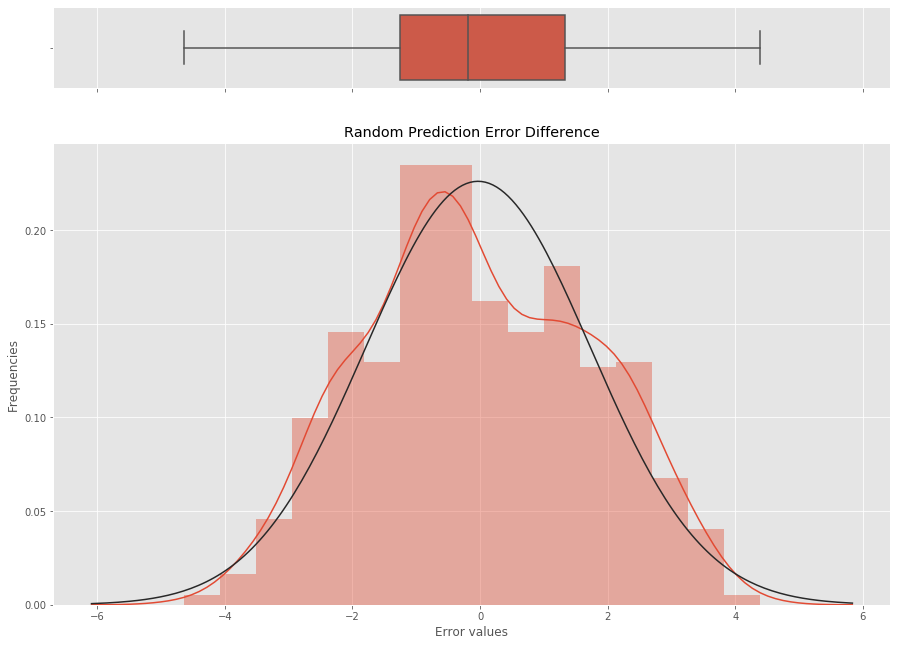

In [108]:
prediction = y_pred_random
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff, fit=st.norm)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Random Prediction Error Difference")

### Mean-Dummy KNN

In [94]:
dum = dummy.DummyRegressor(strategy = 'mean')

In [95]:
dum_energy = dum.fit(X_train, y_train_energy)
dum_GHG = dum.fit(X_train, y_train_GHG)
dum_energy_complete = dum.fit(X_train_complete, y_train_energy)
dum_GHG_complete = dum.fit(X_train_complete, y_train_GHG)

In [96]:
evaluate(dum_energy_complete, X_test_complete, y_test_energy)
evaluate(dum_energy, X_test, y_test_energy)
evaluate(dum_GHG_complete, X_test_complete, y_test_GHG)
evaluate(dum_GHG, X_test, y_test_GHG)

Model Performance : 

MSE =  1.0195584103010908
Mape =  -27.668536239893143

Model Performance : 

MSE =  1.0195584103010908
Mape =  -27.668536239893143

Model Performance : 

MSE =  1.003804409858129
Mape =  -1.2426102284187461

Model Performance : 

MSE =  1.003804409858129
Mape =  -1.2426102284187461



(1.003804409858129, -1.2426102284187461)

[-0.07192364] [-0.10276714]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Mean Dummy Prediction Error Difference')]

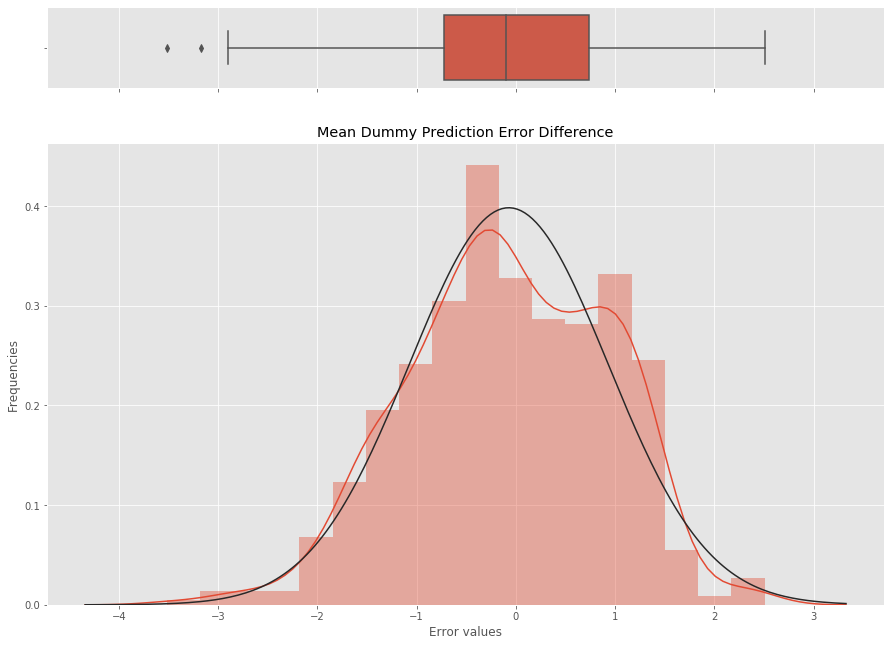

In [109]:
prediction = dum_GHG_complete.predict(X_test_complete)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff, fit=st.norm)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Mean Dummy Prediction Error Difference")

## DNN 

Keras interface

**KFOLD AND DL**

### Keras  & TensorFlow

In [110]:
import import_ipynb

In [111]:
import tensorflow as tf
import datetime, os

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Multiply
from keras.callbacks import TensorBoard

from tensorboard import notebook
from tensorboard.plugins.hparams import api as hp

from CLR import CyclicLR

%reload_ext tensorboard
%load_ext tensorboard

#HParam
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128, 256]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.05, 0.1))

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam', 'adamax']))

METRIC_ACCURACY = 'Accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#59 variables
X = input_tf.drop(info, axis=1)
X_train = input_tf[:1460].drop(info, axis=1)
X_valid = input_tf[1460:1946].drop(info, axis=1)
X_test = input_tf[1946:].drop(info, axis=1)

#2 variables
y = output_tf
y_train = output_tf[:1460]
y_valid = output_tf[1460:1946]
y_test = output_tf[1946:]

#OutputColumns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
#Used for predicting each feature on its own
y_energy = y['SiteEnergyUseWN(kBtu)']
y_train_energy = y_train['SiteEnergyUseWN(kBtu)']
y_valid_energy = y_valid['SiteEnergyUseWN(kBtu)']
y_test_energy = y_test['SiteEnergyUseWN(kBtu)']

y_GHE = y['TotalGHGEmissions']
y_train_GHE = y_train['TotalGHGEmissions']
y_valid_GHE = y_valid['TotalGHGEmissions']
y_test_GHE = y_test['TotalGHGEmissions']

In [112]:
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [113]:
!kill -9 769
!fuser 6006/tcp -k

/bin/sh: line 0: kill: (769) - No such process
Unknown option: k
fuser: [-cfu] file ...
	-c	file is treated as mount point
	-f	the report is only for the named files
	-u	print username of pid in parenthesis


In [114]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > (total_epochs*0.05):
    learning_rate = 0.1
  if epoch > (total_epochs*0.4):
    learning_rate = 0.02
  if epoch > (total_epochs*0.6):
    learning_rate = 0.01
  #if epoch > (tEpoch*0.8):
    #learning_rate = 0.005

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate


In [115]:
# Define model
def create_model(hparams, tot_epochs, tensorboard_callback, run_name, X, y, Xtest, ytest, inputDim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS],
                              input_dim=inputDim,
                              activation='relu',
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(128,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(64,
                              activation="relu",
                              kernel_initializer='random_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(loss="mse",
                  optimizer=hparams[HP_OPTIMIZER],
                  metrics=['mae', 'mape', 'accuracy'])


    # Fit Model
    model.fit(
        X,
        y,
        epochs=tot_epochs,
        batch_size=32,
        validation_data=(Xtest, ytest),
        shuffle=False,
        callbacks=[tensorboard_callback,
                   hp.KerasCallback(run_name, hparams)])

    #accuracy = mean_percentage(y_test_energy, model.predict(X_test))
    mse, mape = evaluate_tf(model, Xtest, ytest)
    #pred = model.predict(X_test).tolist()
    #Pred = []
    #for sublist in pred:
    #    for item in sublist:
    #        Pred.append(item)
    
    #mape = mean_percentage_np(y_test_energy.tolist(), Pred)
    #mse = np.sqrt(K.get_value(K.mean(K.square(np.subtract(Pred, y_test_energy.tolist())))))
    #perc = K.mean(100*(Divide()([K.abs(np.subtract(y_test_energy.tolist(), Pred)), y_test_energy.tolist()])))
    
    print("accuracy here is : ", mse)
    m_dict = {
        'model': model,
        'test_mse': mse,
        'test_mape' : mape,
        'description': {h.name: hparams[h] for h in hparams}
    }
    all_models.append(m_dict)
    return mse

#Play one turn for each HyperParameters
def one_training_each(X, y, Xtest, ytest, inputDim):

    !rm -rf ./logs/
    !rm -rf ./fit/

    all_models = []

    session_num = 0
    total_epochs = 30
    run_name = "logs/fit/" + ("run-%d" % session_num)
   
    for num_units in HP_NUM_UNITS.domain.values:
      for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
          run_name = "logs/fit/" + ("run-%d" % session_num)
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "logs/fit/" + ("run-%d" % session_num)
          tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                              histogram_freq=1)
       
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          descript = {h.name: hparams[h] for h in hparams}
          #run('logs/hparam_tuning/' + run_name, hparams)
          create_model(hparams, total_epochs, tensorboard_callback, run_name , X, y, Xtest, ytest, inputDim)
          session_num += 1
            
            

In [116]:
def on_epoch_end(self, epoch, logs=None):
    print(K.eval(self.model.optimizer.lr))


#class LRTensorBoard(TensorBoard):
  #  def __init__(self, log_dir,
    #             **kwargs):  # add other arguments to __init__ if you need
    #    super().__init__(log_dir=log_dir, **kwargs)

   # def on_epoch_end(self, epoch, logs=None):
    #    logs.update({'lr': K.eval(self.model.optimizer.lr)})
       # super().on_epoch_end(epoch, logs)#

In [117]:
hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    print("yooooo : ", run_dir )
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model(hparams, total_epochs)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [118]:
len(X_train[0])

59

In [119]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train, y_train_energy , X_test, y_test_energy, inputDim = len(X_train[0]))
      session_num += 1
all_models_energy = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 2s 740us/sample - loss: 0.8503 - mae: 0.4975 - mape: 128.7577 - accuracy: 0.0000e+00 - val_loss: 0.6976 - val_mae: 0.4012 - val_mape: 333.9361 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6201 - mae: 0.2995 - mape: 212.3786 - accuracy: 0.0000e+00 - val_loss: 0.5824 - val_mae: 0.2918 - val_mape: 373.1661 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5842 - mae: 0.2703 - mape: 208.3768 - accuracy: 0.0000e+00 - val_loss: 0.5516 - val_mae: 0.2687 - val_mape: 462.6967 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5733 - mae: 0.2647 - mape: 203.7649 - accuracy: 0.0000e+00 - val_loss: 0.5401 - val_mae: 0.2632 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4155 - mae: 0.2314 - mape: 167.5192 - accuracy: 0.0000e+00 - val_loss: 0.5576 - val_mae: 0.2470 - val_mape: 347.5557 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4134 - mae: 0.2324 - mape: 181.4628 - accuracy: 0.0000e+00 - val_loss: 0.5571 - val_mae: 0.2332 - val_mape: 341.6257 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4008 - mae: 0.2245 - mape: 177.8553 - accuracy: 0.0000e+00 - val_loss: 0.5700 - val_mae: 0.2390 - val_mape: 301.0933 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.3924 - mae: 0.2217 - mape: 178.7008 - accuracy: 0.0000e+00 - val_loss: 0.5747 - val_mae: 0.2423 - val_mape: 301.7249 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.3844 - mae: 0.

2620/2620 [==============================] - 0s 54us/sample - loss: 0.5647 - mae: 0.2582 - mape: 191.1742 - accuracy: 0.0000e+00 - val_loss: 0.5260 - val_mae: 0.2477 - val_mape: 532.9844 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5579 - mae: 0.2541 - mape: 193.1222 - accuracy: 0.0000e+00 - val_loss: 0.5263 - val_mae: 0.2533 - val_mape: 555.6283 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5524 - mae: 0.2556 - mape: 187.5807 - accuracy: 0.0000e+00 - val_loss: 0.5218 - val_mae: 0.2471 - val_mape: 543.5247 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5507 - mae: 0.2558 - mape: 192.9340 - accuracy: 0.0000e+00 - val_loss: 0.5190 - val_mae: 0.2481 - val_mape: 557.9120 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5501 - mae: 0.2547 - mape: 2

2620/2620 [==============================] - 0s 62us/sample - loss: 0.3427 - mae: 0.2036 - mape: 148.4672 - accuracy: 0.0000e+00 - val_loss: 0.7915 - val_mae: 0.2728 - val_mape: 427.9117 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 63us/sample - loss: 0.3731 - mae: 0.2149 - mape: 165.1312 - accuracy: 0.0000e+00 - val_loss: 0.7726 - val_mae: 0.2520 - val_mape: 354.4412 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 63us/sample - loss: 0.3715 - mae: 0.2050 - mape: 149.5172 - accuracy: 0.0000e+00 - val_loss: 0.6322 - val_mae: 0.2382 - val_mape: 402.3810 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 63us/sample - loss: 0.3380 - mae: 0.2015 - mape: 167.8456 - accuracy: 0.0000e+00 - val_loss: 0.5955 - val_mae: 0.2369 - val_mape: 375.4832 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.3564 - mae: 0.2104 - mape:

2620/2620 [==============================] - 0s 54us/sample - loss: 0.3198 - mae: 0.2126 - mape: 173.9647 - accuracy: 0.0000e+00 - val_loss: 0.6486 - val_mae: 0.2577 - val_mape: 367.1877 - val_accuracy: 0.0000e+00
Epoch 50/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.3021 - mae: 0.2086 - mape: 149.5469 - accuracy: 0.0000e+00 - val_loss: 0.6229 - val_mae: 0.2412 - val_mape: 373.0474 - val_accuracy: 0.0000e+00
accuracy here is :  0.7892580124996191
--- Starting trial: logs/fit/run-5
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 460us/sample - loss: 0.7078 - mae: 0.3691 - mape: 180.0258 - accuracy: 0.0000e+00 - val_loss: 0.5632 - val_mae: 0.2873 - val_mape: 431.5751 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 79us/sample - loss: 0.5969 - mae: 0.2776 - mape: 193.5616 - accuracy: 0.0000e+00 - val_loss: 0.5

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5139 - mae: 0.2470 - mape: 189.4576 - accuracy: 0.0000e+00 - val_loss: 0.5226 - val_mae: 0.2449 - val_mape: 500.4987 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5026 - mae: 0.2403 - mape: 213.9393 - accuracy: 0.0000e+00 - val_loss: 0.5235 - val_mae: 0.2519 - val_mape: 497.9721 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5014 - mae: 0.2462 - mape: 187.9689 - accuracy: 0.0000e+00 - val_loss: 0.5259 - val_mae: 0.2470 - val_mape: 524.7803 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5022 - mae: 0.2462 - mape: 188.5125 - accuracy: 0.0000e+00 - val_loss: 0.5244 - val_mae: 0.2464 - val_mape: 542.7985 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4933 - mae: 0.2462 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.2711 - mae: 0.1920 - mape: 137.6279 - accuracy: 0.0000e+00 - val_loss: 0.7972 - val_mae: 0.2680 - val_mape: 316.1313 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.2245 - mae: 0.1780 - mape: 120.8998 - accuracy: 0.0000e+00 - val_loss: 0.7468 - val_mae: 0.2506 - val_mape: 314.0185 - val_accuracy: 0.0000e+00
Epoch 42/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.2413 - mae: 0.1872 - mape: 137.7254 - accuracy: 0.0000e+00 - val_loss: 0.7099 - val_mae: 0.2397 - val_mape: 288.8003 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.2718 - mae: 0.1858 - mape: 149.9309 - accuracy: 0.0000e+00 - val_loss: 0.6575 - val_mae: 0.2419 - val_mape: 325.4122 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.2140 - mae: 0.1755 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5091 - mae: 0.2371 - mape: 168.4710 - accuracy: 0.0000e+00 - val_loss: 0.5246 - val_mae: 0.2496 - val_mape: 408.3454 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4890 - mae: 0.2356 - mape: 160.5973 - accuracy: 0.0000e+00 - val_loss: 0.5262 - val_mae: 0.2487 - val_mape: 362.0592 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5243 - mae: 0.2417 - mape: 175.2643 - accuracy: 0.0000e+00 - val_loss: 0.5579 - val_mae: 0.2528 - val_mape: 257.2196 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5023 - mae: 0.2375 - mape: 163.2798 - accuracy: 0.0000e+00 - val_loss: 0.5297 - val_mae: 0.2409 - val_mape: 502.8682 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4652 - mae: 0.2261 - mape:

2620/2620 [==============================] - 0s 59us/sample - loss: 0.4479 - mae: 0.2332 - mape: 189.3433 - accuracy: 0.0000e+00 - val_loss: 0.5472 - val_mae: 0.2473 - val_mape: 419.5438 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4471 - mae: 0.2393 - mape: 191.0500 - accuracy: 0.0000e+00 - val_loss: 0.5506 - val_mae: 0.2510 - val_mape: 379.7797 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4389 - mae: 0.2360 - mape: 201.7370 - accuracy: 0.0000e+00 - val_loss: 0.5561 - val_mae: 0.2500 - val_mape: 364.8213 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4123 - mae: 0.2333 - mape: 186.8501 - accuracy: 0.0000e+00 - val_loss: 0.5640 - val_mae: 0.2520 - val_mape: 377.7229 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4225 - mae: 0.2362 - mape:

1.883997901280721  minutes.


In [120]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train_complete, y_train_energy , X_test_complete, y_test_energy, inputDim = len(X_train_complete[0]))
      session_num += 1
all_models_energy_complete = all_models


--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 274us/sample - loss: 0.9465 - mae: 0.5515 - mape: 139.6409 - accuracy: 0.0000e+00 - val_loss: 0.8179 - val_mae: 0.4836 - val_mape: 189.4736 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.7815 - mae: 0.4289 - mape: 177.9435 - accuracy: 0.0000e+00 - val_loss: 0.6910 - val_mae: 0.3887 - val_mape: 557.0828 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.7050 - mae: 0.3673 - mape: 280.0757 - accuracy: 0.0000e+00 - val_loss: 0.6440 - val_mae: 0.3583 - val_mape: 725.0068 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6806 - mae: 0.3502 - mape: 283.4314 - accuracy: 0.0000e+00 - val_loss: 0.6231 - val_mae: 0.3502 - val_m

2620/2620 [==============================] - 0s 66us/sample - loss: 0.5423 - mae: 0.3204 - mape: 244.8537 - accuracy: 0.0000e+00 - val_loss: 0.6827 - val_mae: 0.3578 - val_mape: 902.4615 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5425 - mae: 0.3173 - mape: 237.1923 - accuracy: 0.0000e+00 - val_loss: 0.7332 - val_mae: 0.3602 - val_mape: 1022.3577 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5483 - mae: 0.3245 - mape: 252.2446 - accuracy: 0.0000e+00 - val_loss: 0.7531 - val_mae: 0.3580 - val_mape: 731.2288 - val_accuracy: 0.0000e+00
Epoch 24/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5396 - mae: 0.3165 - mape: 240.4079 - accuracy: 0.0000e+00 - val_loss: 0.7729 - val_mae: 0.3830 - val_mape: 619.9550 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5126 - mae: 0.3124 - mape

2620/2620 [==============================] - 0s 54us/sample - loss: 0.5869 - mae: 0.3294 - mape: 274.6259 - accuracy: 0.0000e+00 - val_loss: 0.5755 - val_mae: 0.3373 - val_mape: 853.6483 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5897 - mae: 0.3245 - mape: 283.5557 - accuracy: 0.0000e+00 - val_loss: 0.5764 - val_mae: 0.3380 - val_mape: 845.2830 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5868 - mae: 0.3275 - mape: 292.3463 - accuracy: 0.0000e+00 - val_loss: 0.5760 - val_mae: 0.3404 - val_mape: 890.2175 - val_accuracy: 0.0000e+00
Epoch 45/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5750 - mae: 0.3238 - mape: 274.0576 - accuracy: 0.0000e+00 - val_loss: 0.5775 - val_mae: 0.3397 - val_mape: 843.3500 - val_accuracy: 0.0000e+00
Epoch 46/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5836 - mae: 0.3261 - mape:

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6195 - mae: 0.3311 - mape: 301.6641 - accuracy: 0.0000e+00 - val_loss: 0.5727 - val_mae: 0.3381 - val_mape: 1119.8140 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6198 - mae: 0.3307 - mape: 312.1135 - accuracy: 0.0000e+00 - val_loss: 0.5740 - val_mae: 0.3404 - val_mape: 1145.6716 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6169 - mae: 0.3311 - mape: 321.9366 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_mae: 0.3376 - val_mape: 1108.7319 - val_accuracy: 0.0000e+00
Epoch 15/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6125 - mae: 0.3267 - mape: 334.0648 - accuracy: 0.0000e+00 - val_loss: 0.5712 - val_mae: 0.3372 - val_mape: 1074.4799 - val_accuracy: 0.0000e+00
Epoch 16/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6087 - mae: 0.3274 - m

2620/2620 [==============================] - 0s 68us/sample - loss: 0.4861 - mae: 0.3019 - mape: 254.2123 - accuracy: 0.0000e+00 - val_loss: 0.7275 - val_mae: 0.3556 - val_mape: 380.6061 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4995 - mae: 0.3051 - mape: 246.6037 - accuracy: 0.0000e+00 - val_loss: 0.7972 - val_mae: 0.3655 - val_mape: 591.1538 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4696 - mae: 0.2968 - mape: 270.0863 - accuracy: 0.0000e+00 - val_loss: 0.7297 - val_mae: 0.3550 - val_mape: 436.2351 - val_accuracy: 0.0000e+00
Epoch 36/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4743 - mae: 0.2978 - mape: 253.3410 - accuracy: 0.0000e+00 - val_loss: 0.7330 - val_mae: 0.3580 - val_mape: 433.4058 - val_accuracy: 0.0000e+00
Epoch 37/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4889 - mae: 0.3017 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.6865 - mae: 0.3656 - mape: 265.4768 - accuracy: 0.0000e+00 - val_loss: 0.6217 - val_mae: 0.3687 - val_mape: 1050.9464 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6551 - mae: 0.3486 - mape: 271.3434 - accuracy: 0.0000e+00 - val_loss: 0.6140 - val_mae: 0.3705 - val_mape: 1065.5443 - val_accuracy: 0.0000e+00
Epoch 5/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6513 - mae: 0.3454 - mape: 268.4984 - accuracy: 0.0000e+00 - val_loss: 0.6073 - val_mae: 0.3633 - val_mape: 1019.9286 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6403 - mae: 0.3437 - mape: 300.6565 - accuracy: 0.0000e+00 - val_loss: 0.5919 - val_mae: 0.3485 - val_mape: 996.1995 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6342 - mae: 0.3419 - mape: 

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5754 - mae: 0.3223 - mape: 309.7423 - accuracy: 0.0000e+00 - val_loss: 0.5797 - val_mae: 0.3457 - val_mape: 823.6748 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5721 - mae: 0.3239 - mape: 273.7356 - accuracy: 0.0000e+00 - val_loss: 0.5794 - val_mae: 0.3426 - val_mape: 817.9632 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5744 - mae: 0.3247 - mape: 296.3685 - accuracy: 0.0000e+00 - val_loss: 0.5837 - val_mae: 0.3439 - val_mape: 792.3036 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5675 - mae: 0.3200 - mape: 268.3948 - accuracy: 0.0000e+00 - val_loss: 0.5852 - val_mae: 0.3442 - val_mape: 770.8941 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5716 - mae: 0.3229 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4530 - mae: 0.2864 - mape: 251.7303 - accuracy: 0.0000e+00 - val_loss: 0.8626 - val_mae: 0.3749 - val_mape: 464.8372 - val_accuracy: 0.0000e+00
Epoch 46/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4476 - mae: 0.2846 - mape: 256.0345 - accuracy: 0.0000e+00 - val_loss: 0.8389 - val_mae: 0.3848 - val_mape: 388.5715 - val_accuracy: 0.0000e+00
Epoch 47/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4596 - mae: 0.2855 - mape: 254.3966 - accuracy: 0.0000e+00 - val_loss: 0.8198 - val_mae: 0.3789 - val_mape: 359.1623 - val_accuracy: 0.0000e+00
Epoch 48/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4408 - mae: 0.2830 - mape: 254.2458 - accuracy: 0.0000e+00 - val_loss: 0.8428 - val_mae: 0.3871 - val_mape: 339.5377 - val_accuracy: 0.0000e+00
Epoch 49/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4406 - mae: 0.2824 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5787 - mae: 0.3264 - mape: 238.1108 - accuracy: 0.0000e+00 - val_loss: 0.6463 - val_mae: 0.3561 - val_mape: 867.7471 - val_accuracy: 0.0000e+00
Epoch 16/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5783 - mae: 0.3267 - mape: 247.2105 - accuracy: 0.0000e+00 - val_loss: 0.6629 - val_mae: 0.3560 - val_mape: 799.6752 - val_accuracy: 0.0000e+00
Epoch 17/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5658 - mae: 0.3235 - mape: 226.8970 - accuracy: 0.0000e+00 - val_loss: 0.6902 - val_mae: 0.3602 - val_mape: 997.6267 - val_accuracy: 0.0000e+00
Epoch 18/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5460 - mae: 0.3174 - mape: 252.3034 - accuracy: 0.0000e+00 - val_loss: 0.7097 - val_mae: 0.3565 - val_mape: 889.3971 - val_accuracy: 0.0000e+00
Epoch 19/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5776 - mae: 0.3210 - mape:

1.9005758802096049  minutes.


In [121]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train, y_train_GHG , X_test, y_test_GHG, inputDim = len(X_train[0]))
      session_num += 1
all_models_GHG = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 280us/sample - loss: 0.7506 - mae: 0.6947 - mape: 124.0196 - accuracy: 0.0000e+00 - val_loss: 0.3987 - val_mae: 0.5077 - val_mape: 163.5006 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1877 - mae: 0.3121 - mape: 166.8849 - accuracy: 0.0000e+00 - val_loss: 0.1589 - val_mae: 0.2796 - val_mape: 201.9876 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.1419 - mae: 0.2585 - mape: 162.1728 - accuracy: 0.0000e+00 - val_loss: 0.1473 - val_mae: 0.2667 - val_mape: 196.8201 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1315 - mae: 0.2477 - mape: 157.3813 - accuracy: 0.0000e+00 - val_loss: 0.1367 - val_mae: 0.2434 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 64us/sample - loss: 0.0608 - mae: 0.1530 - mape: 75.4040 - accuracy: 0.0000e+00 - val_loss: 0.0835 - val_mae: 0.1545 - val_mape: 84.4996 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0556 - mae: 0.1446 - mape: 81.0979 - accuracy: 0.0000e+00 - val_loss: 0.0787 - val_mae: 0.1498 - val_mape: 86.8782 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0602 - mae: 0.1512 - mape: 77.7250 - accuracy: 0.0000e+00 - val_loss: 0.0830 - val_mae: 0.1579 - val_mape: 79.9012 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0551 - mae: 0.1421 - mape: 69.8864 - accuracy: 0.0000e+00 - val_loss: 0.0814 - val_mae: 0.1522 - val_mape: 82.3426 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0580 - mae: 0.1481 - m

Epoch 23/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0588 - mae: 0.1501 - mape: 86.2101 - accuracy: 0.0000e+00 - val_loss: 0.1422 - val_mae: 0.2442 - val_mape: 144.4258 - val_accuracy: 0.0000e+00
Epoch 24/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0550 - mae: 0.1467 - mape: 80.4080 - accuracy: 0.0000e+00 - val_loss: 0.1003 - val_mae: 0.1769 - val_mape: 111.4788 - val_accuracy: 0.0000e+00
Epoch 25/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0529 - mae: 0.1450 - mape: 93.9055 - accuracy: 0.0000e+00 - val_loss: 0.0966 - val_mae: 0.1788 - val_mape: 105.7546 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0526 - mae: 0.1452 - mape: 98.9057 - accuracy: 0.0000e+00 - val_loss: 0.1177 - val_mae: 0.1995 - val_mape: 118.6659 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0548 - mae: 0.1455

Epoch 9/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.1155 - mae: 0.2267 - mape: 129.0940 - accuracy: 0.0000e+00 - val_loss: 0.1232 - val_mae: 0.2234 - val_mape: 126.4069 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1069 - mae: 0.2169 - mape: 134.3413 - accuracy: 0.0000e+00 - val_loss: 0.1117 - val_mae: 0.2046 - val_mape: 110.2796 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.1015 - mae: 0.2077 - mape: 117.4453 - accuracy: 0.0000e+00 - val_loss: 0.1094 - val_mae: 0.2009 - val_mape: 107.8854 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0956 - mae: 0.2028 - mape: 112.0060 - accuracy: 0.0000e+00 - val_loss: 0.1119 - val_mae: 0.2122 - val_mape: 123.3162 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0925 - mae: 0.1

Epoch 31/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0555 - mae: 0.1503 - mape: 91.3907 - accuracy: 0.0000e+00 - val_loss: 0.0904 - val_mae: 0.1755 - val_mape: 116.6817 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0561 - mae: 0.1511 - mape: 87.4740 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_mae: 0.1774 - val_mape: 93.8171 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0571 - mae: 0.1525 - mape: 80.4877 - accuracy: 0.0000e+00 - val_loss: 0.0867 - val_mae: 0.1653 - val_mape: 118.5476 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 62us/sample - loss: 0.0575 - mae: 0.1506 - mape: 73.2186 - accuracy: 0.0000e+00 - val_loss: 0.0921 - val_mae: 0.1745 - val_mape: 111.0210 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0561 - mae: 0.1488 

Epoch 17/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0782 - mae: 0.1740 - mape: 93.1350 - accuracy: 0.0000e+00 - val_loss: 0.0941 - val_mae: 0.1830 - val_mape: 102.7783 - val_accuracy: 0.0000e+00
Epoch 18/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0749 - mae: 0.1711 - mape: 95.6727 - accuracy: 0.0000e+00 - val_loss: 0.0911 - val_mae: 0.1762 - val_mape: 104.4110 - val_accuracy: 0.0000e+00
Epoch 19/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0749 - mae: 0.1707 - mape: 97.3167 - accuracy: 0.0000e+00 - val_loss: 0.0878 - val_mae: 0.1708 - val_mape: 94.7998 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0718 - mae: 0.1675 - mape: 92.3068 - accuracy: 0.0000e+00 - val_loss: 0.0891 - val_mae: 0.1716 - val_mape: 93.5539 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0713 - mae: 0.1646 -

Epoch 3/50
2620/2620 [==============================] - 0s 73us/sample - loss: 0.1220 - mae: 0.2363 - mape: 152.3175 - accuracy: 0.0000e+00 - val_loss: 0.1234 - val_mae: 0.2338 - val_mape: 167.2156 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.1045 - mae: 0.2163 - mape: 131.4583 - accuracy: 0.0000e+00 - val_loss: 0.1342 - val_mae: 0.2409 - val_mape: 145.7318 - val_accuracy: 0.0000e+00
Epoch 5/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0914 - mae: 0.1983 - mape: 113.3528 - accuracy: 0.0000e+00 - val_loss: 0.1012 - val_mae: 0.1960 - val_mape: 122.9741 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0841 - mae: 0.1897 - mape: 106.1832 - accuracy: 0.0000e+00 - val_loss: 0.1027 - val_mae: 0.2005 - val_mape: 127.4057 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0792 - mae: 0.1814 

Epoch 25/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0676 - mae: 0.1627 - mape: 78.5870 - accuracy: 0.0000e+00 - val_loss: 0.0786 - val_mae: 0.1513 - val_mape: 90.3655 - val_accuracy: 0.0000e+00
Epoch 26/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0641 - mae: 0.1570 - mape: 78.0652 - accuracy: 0.0000e+00 - val_loss: 0.0812 - val_mae: 0.1567 - val_mape: 95.5450 - val_accuracy: 0.0000e+00
Epoch 27/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0634 - mae: 0.1558 - mape: 101.0788 - accuracy: 0.0000e+00 - val_loss: 0.0856 - val_mae: 0.1664 - val_mape: 99.4375 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0685 - mae: 0.1623 - mape: 88.1895 - accuracy: 0.0000e+00 - val_loss: 0.0861 - val_mae: 0.1685 - val_mape: 101.0609 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0660 - mae: 0.1598 -

Epoch 11/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0763 - mae: 0.1775 - mape: 90.6147 - accuracy: 0.0000e+00 - val_loss: 0.0965 - val_mae: 0.1837 - val_mape: 115.2246 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0700 - mae: 0.1691 - mape: 86.3129 - accuracy: 0.0000e+00 - val_loss: 0.1150 - val_mae: 0.2135 - val_mape: 126.2506 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0674 - mae: 0.1636 - mape: 98.7068 - accuracy: 0.0000e+00 - val_loss: 0.1016 - val_mae: 0.1958 - val_mape: 130.7899 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0687 - mae: 0.1678 - mape: 78.7602 - accuracy: 0.0000e+00 - val_loss: 0.1141 - val_mae: 0.2196 - val_mape: 140.3297 - val_accuracy: 0.0000e+00
Epoch 15/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0650 - mae: 0.1627

Epoch 33/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0491 - mae: 0.1368 - mape: 83.3545 - accuracy: 0.0000e+00 - val_loss: 0.0795 - val_mae: 0.1514 - val_mape: 79.3359 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0489 - mae: 0.1387 - mape: 76.5130 - accuracy: 0.0000e+00 - val_loss: 0.0803 - val_mae: 0.1511 - val_mape: 80.9877 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0465 - mae: 0.1338 - mape: 68.0420 - accuracy: 0.0000e+00 - val_loss: 0.0816 - val_mae: 0.1578 - val_mape: 86.9505 - val_accuracy: 0.0000e+00
Epoch 36/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0499 - mae: 0.1365 - mape: 80.4533 - accuracy: 0.0000e+00 - val_loss: 0.0797 - val_mae: 0.1519 - val_mape: 80.6633 - val_accuracy: 0.0000e+00
Epoch 37/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0438 - mae: 0.1294 - m

Epoch 19/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0592 - mae: 0.1483 - mape: 69.8702 - accuracy: 0.0000e+00 - val_loss: 0.1280 - val_mae: 0.2271 - val_mape: 133.0156 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0547 - mae: 0.1451 - mape: 73.6892 - accuracy: 0.0000e+00 - val_loss: 0.1166 - val_mae: 0.2073 - val_mape: 122.0491 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0536 - mae: 0.1440 - mape: 70.9724 - accuracy: 0.0000e+00 - val_loss: 0.1087 - val_mae: 0.1954 - val_mape: 112.5762 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0552 - mae: 0.1443 - mape: 77.2944 - accuracy: 0.0000e+00 - val_loss: 0.1178 - val_mae: 0.2132 - val_mape: 138.1723 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0524 - mae: 0.1431

Epoch 5/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1194 - mae: 0.2312 - mape: 136.6819 - accuracy: 0.0000e+00 - val_loss: 0.1328 - val_mae: 0.2487 - val_mape: 170.6890 - val_accuracy: 0.0000e+00
Epoch 6/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1087 - mae: 0.2198 - mape: 134.4327 - accuracy: 0.0000e+00 - val_loss: 0.1246 - val_mae: 0.2311 - val_mape: 136.4588 - val_accuracy: 0.0000e+00
Epoch 7/50
2620/2620 [==============================] - 0s 61us/sample - loss: 0.1045 - mae: 0.2137 - mape: 122.3398 - accuracy: 0.0000e+00 - val_loss: 0.1196 - val_mae: 0.2213 - val_mape: 125.4526 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0993 - mae: 0.2066 - mape: 114.0592 - accuracy: 0.0000e+00 - val_loss: 0.1083 - val_mae: 0.2067 - val_mape: 124.1042 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0962 - mae: 0.1999 

Epoch 27/50
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0520 - mae: 0.1417 - mape: 74.9606 - accuracy: 0.0000e+00 - val_loss: 0.1302 - val_mae: 0.2392 - val_mape: 163.2858 - val_accuracy: 0.0000e+00
Epoch 28/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0517 - mae: 0.1417 - mape: 76.2931 - accuracy: 0.0000e+00 - val_loss: 0.1070 - val_mae: 0.1993 - val_mape: 125.2973 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0569 - mae: 0.1465 - mape: 85.4041 - accuracy: 0.0000e+00 - val_loss: 0.1559 - val_mae: 0.2228 - val_mape: 100.2421 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0623 - mae: 0.1564 - mape: 80.7141 - accuracy: 0.0000e+00 - val_loss: 0.1105 - val_mae: 0.2178 - val_mape: 103.7751 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0496 - mae: 0.1403

1.9040231148401896  minutes.


In [122]:
tf.keras.backend.clear_session()

!rm -rf ./logs/
!rm -rf ./fit/

all_models = []
session_num = 0
total_epochs = 50
run_name = "logs/fit/" + ("run-%d" % session_num)


for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "logs/fit/" + ("run-%d" % session_num)

      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name,
                                                      histogram_freq=1)
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      descript = {h.name: hparams[h] for h in hparams}
      #run('logs/hparam_tuning/' + run_name, hparams)
      create_model(hparams, total_epochs,tensorboard_callback, run_name, X_train_complete, y_train_GHG , X_test_complete, y_test_GHG, inputDim = len(X_train_complete[0]))
      session_num += 1
all_models_GHG_complete = all_models

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 278us/sample - loss: 0.8742 - mae: 0.7609 - mape: 117.6511 - accuracy: 0.0000e+00 - val_loss: 0.7213 - val_mae: 0.7024 - val_mape: 123.3587 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6442 - mae: 0.6538 - mape: 169.8955 - accuracy: 0.0000e+00 - val_loss: 0.5455 - val_mae: 0.6053 - val_mape: 325.1685 - val_accuracy: 0.0000e+00
Epoch 3/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5294 - mae: 0.5843 - mape: 257.7227 - accuracy: 0.0000e+00 - val_loss: 0.5127 - val_mae: 0.5897 - val_mape: 327.0089 - val_accuracy: 0.0000e+00
Epoch 4/50
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5025 - mae: 0.5685 - mape: 256.6273 - accuracy: 0.0000e+00 - val_loss: 0.4925 - val_mae: 0.5806 - val_m

Epoch 37/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.3971 - mae: 0.4951 - mape: 239.8459 - accuracy: 0.0000e+00 - val_loss: 0.4354 - val_mae: 0.5346 - val_mape: 259.5203 - val_accuracy: 0.0000e+00
Epoch 38/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.3928 - mae: 0.4927 - mape: 250.0676 - accuracy: 0.0000e+00 - val_loss: 0.4355 - val_mae: 0.5358 - val_mape: 245.4396 - val_accuracy: 0.0000e+00
Epoch 39/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.3922 - mae: 0.4939 - mape: 238.9895 - accuracy: 0.0000e+00 - val_loss: 0.4360 - val_mae: 0.5341 - val_mape: 256.1612 - val_accuracy: 0.0000e+00
Epoch 40/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.3861 - mae: 0.4896 - mape: 227.6199 - accuracy: 0.0000e+00 - val_loss: 0.4354 - val_mae: 0.5313 - val_mape: 243.8993 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.3920 - mae: 0.

2620/2620 [==============================] - 0s 55us/sample - loss: 0.4726 - mae: 0.5451 - mape: 240.6911 - accuracy: 0.0000e+00 - val_loss: 0.4612 - val_mae: 0.5584 - val_mape: 261.7424 - val_accuracy: 0.0000e+00
Epoch 8/50
2620/2620 [==============================] - 0s 53us/sample - loss: 0.4642 - mae: 0.5395 - mape: 230.4494 - accuracy: 0.0000e+00 - val_loss: 0.4568 - val_mae: 0.5567 - val_mape: 247.9515 - val_accuracy: 0.0000e+00
Epoch 9/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4595 - mae: 0.5367 - mape: 221.4028 - accuracy: 0.0000e+00 - val_loss: 0.4520 - val_mae: 0.5519 - val_mape: 261.8675 - val_accuracy: 0.0000e+00
Epoch 10/50
2620/2620 [==============================] - 0s 52us/sample - loss: 0.4524 - mae: 0.5309 - mape: 226.4299 - accuracy: 0.0000e+00 - val_loss: 0.4483 - val_mae: 0.5513 - val_mape: 247.8792 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4577 - mae: 0.5349 - mape: 2

2620/2620 [==============================] - 0s 65us/sample - loss: 0.3869 - mae: 0.4910 - mape: 215.2649 - accuracy: 0.0000e+00 - val_loss: 0.4426 - val_mae: 0.5328 - val_mape: 265.0335 - val_accuracy: 0.0000e+00
Epoch 29/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3927 - mae: 0.4924 - mape: 214.2972 - accuracy: 0.0000e+00 - val_loss: 0.4413 - val_mae: 0.5301 - val_mape: 254.3024 - val_accuracy: 0.0000e+00
Epoch 30/50
2620/2620 [==============================] - 0s 64us/sample - loss: 0.3886 - mae: 0.4904 - mape: 225.5000 - accuracy: 0.0000e+00 - val_loss: 0.4416 - val_mae: 0.5329 - val_mape: 261.0806 - val_accuracy: 0.0000e+00
Epoch 31/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3870 - mae: 0.4898 - mape: 225.6500 - accuracy: 0.0000e+00 - val_loss: 0.4439 - val_mae: 0.5374 - val_mape: 259.7364 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3890 - mae: 0.4904 - mape:

2620/2620 [==============================] - 0s 54us/sample - loss: 0.3750 - mae: 0.4794 - mape: 224.1072 - accuracy: 0.0000e+00 - val_loss: 0.4333 - val_mae: 0.5274 - val_mape: 238.2433 - val_accuracy: 0.0000e+00
Epoch 50/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.3756 - mae: 0.4808 - mape: 231.3714 - accuracy: 0.0000e+00 - val_loss: 0.4350 - val_mae: 0.5279 - val_mape: 225.2368 - val_accuracy: 0.0000e+00
accuracy here is :  0.6595670323928279
--- Starting trial: logs/fit/run-5
{'num_units': 128, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/50
2620/2620 [==============================] - 1s 440us/sample - loss: 0.6755 - mae: 0.6612 - mape: 190.6575 - accuracy: 0.0000e+00 - val_loss: 0.5130 - val_mae: 0.5834 - val_mape: 352.9528 - val_accuracy: 0.0000e+00
Epoch 2/50
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5343 - mae: 0.5777 - mape: 237.2575 - accuracy: 0.0000e+00 - val_loss: 0.4

2620/2620 [==============================] - 0s 55us/sample - loss: 0.4188 - mae: 0.5087 - mape: 221.6178 - accuracy: 0.0000e+00 - val_loss: 0.4319 - val_mae: 0.5367 - val_mape: 245.9673 - val_accuracy: 0.0000e+00
Epoch 20/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4181 - mae: 0.5107 - mape: 240.6066 - accuracy: 0.0000e+00 - val_loss: 0.4301 - val_mae: 0.5356 - val_mape: 248.7309 - val_accuracy: 0.0000e+00
Epoch 21/50
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4207 - mae: 0.5132 - mape: 238.4075 - accuracy: 0.0000e+00 - val_loss: 0.4335 - val_mae: 0.5389 - val_mape: 244.2766 - val_accuracy: 0.0000e+00
Epoch 22/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4127 - mae: 0.5085 - mape: 248.4450 - accuracy: 0.0000e+00 - val_loss: 0.4326 - val_mae: 0.5356 - val_mape: 245.3475 - val_accuracy: 0.0000e+00
Epoch 23/50
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4106 - mae: 0.5052 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.3583 - mae: 0.4656 - mape: 227.3488 - accuracy: 0.0000e+00 - val_loss: 0.4541 - val_mae: 0.5391 - val_mape: 284.4381 - val_accuracy: 0.0000e+00
Epoch 41/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3589 - mae: 0.4672 - mape: 221.7710 - accuracy: 0.0000e+00 - val_loss: 0.4524 - val_mae: 0.5410 - val_mape: 273.6064 - val_accuracy: 0.0000e+00
Epoch 42/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3519 - mae: 0.4606 - mape: 221.3034 - accuracy: 0.0000e+00 - val_loss: 0.4646 - val_mae: 0.5447 - val_mape: 283.1482 - val_accuracy: 0.0000e+00
Epoch 43/50
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3524 - mae: 0.4605 - mape: 226.6815 - accuracy: 0.0000e+00 - val_loss: 0.4525 - val_mae: 0.5346 - val_mape: 297.3938 - val_accuracy: 0.0000e+00
Epoch 44/50
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3528 - mae: 0.4614 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.4178 - mae: 0.5091 - mape: 216.0700 - accuracy: 0.0000e+00 - val_loss: 0.4376 - val_mae: 0.5314 - val_mape: 272.9884 - val_accuracy: 0.0000e+00
Epoch 11/50
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4098 - mae: 0.5055 - mape: 227.0436 - accuracy: 0.0000e+00 - val_loss: 0.4382 - val_mae: 0.5341 - val_mape: 270.0048 - val_accuracy: 0.0000e+00
Epoch 12/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4074 - mae: 0.5029 - mape: 220.3968 - accuracy: 0.0000e+00 - val_loss: 0.4373 - val_mae: 0.5302 - val_mape: 271.6753 - val_accuracy: 0.0000e+00
Epoch 13/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4108 - mae: 0.5050 - mape: 226.9344 - accuracy: 0.0000e+00 - val_loss: 0.4387 - val_mae: 0.5282 - val_mape: 278.0000 - val_accuracy: 0.0000e+00
Epoch 14/50
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4011 - mae: 0.4967 - mape:

2620/2620 [==============================] - 0s 64us/sample - loss: 0.3953 - mae: 0.4929 - mape: 223.8131 - accuracy: 0.0000e+00 - val_loss: 0.4345 - val_mae: 0.5280 - val_mape: 256.2178 - val_accuracy: 0.0000e+00
Epoch 32/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.3975 - mae: 0.4945 - mape: 208.8403 - accuracy: 0.0000e+00 - val_loss: 0.4323 - val_mae: 0.5300 - val_mape: 242.6754 - val_accuracy: 0.0000e+00
Epoch 33/50
2620/2620 [==============================] - 0s 58us/sample - loss: 0.3914 - mae: 0.4928 - mape: 232.7728 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5327 - val_mape: 243.4981 - val_accuracy: 0.0000e+00
Epoch 34/50
2620/2620 [==============================] - 0s 57us/sample - loss: 0.3918 - mae: 0.4916 - mape: 222.3271 - accuracy: 0.0000e+00 - val_loss: 0.4356 - val_mae: 0.5315 - val_mape: 251.2300 - val_accuracy: 0.0000e+00
Epoch 35/50
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3827 - mae: 0.4836 - mape:

1.8550182143847147  minutes.


### HyperParameter tools

In [123]:
%tensorboard --logdir logs

In [124]:
DfModelList = all_models_energy
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_energy = model_df.set_index(['description']).sort_values('test_mse').head(5)

In [125]:
all_models_energy[['test_mse', 'test_mape']] = np.abs(all_models_energy[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *energy*')

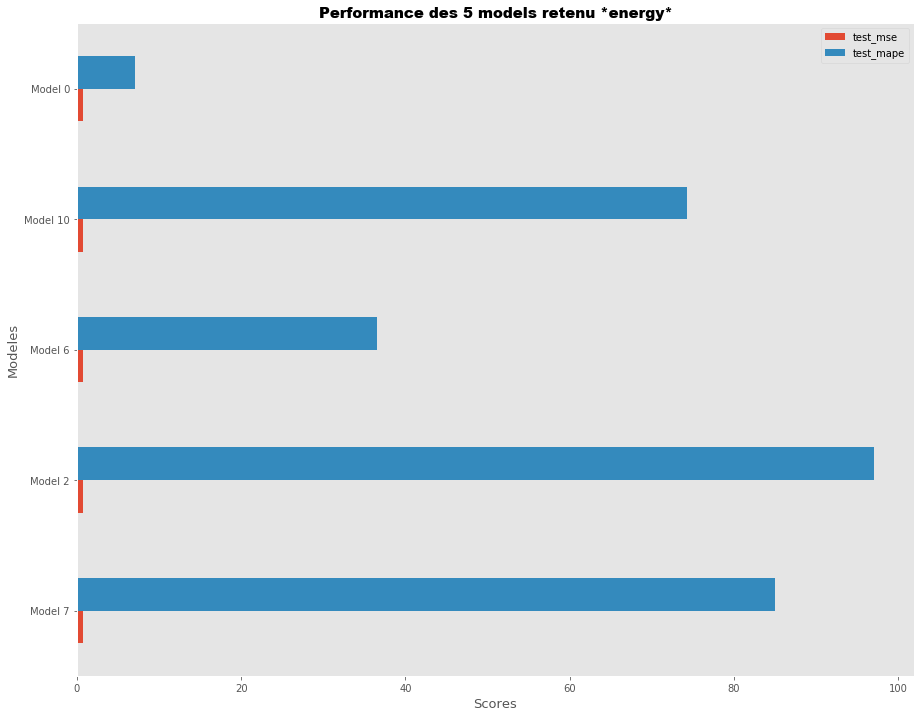

In [126]:
all_models_energy.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *energy*', fontname="Arial Black", size=15)

In [127]:
DfModelList = all_models_GHG
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_GHG = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_GHG[['test_mse', 'test_mape']] = np.abs(all_models_GHG[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *GHG*')

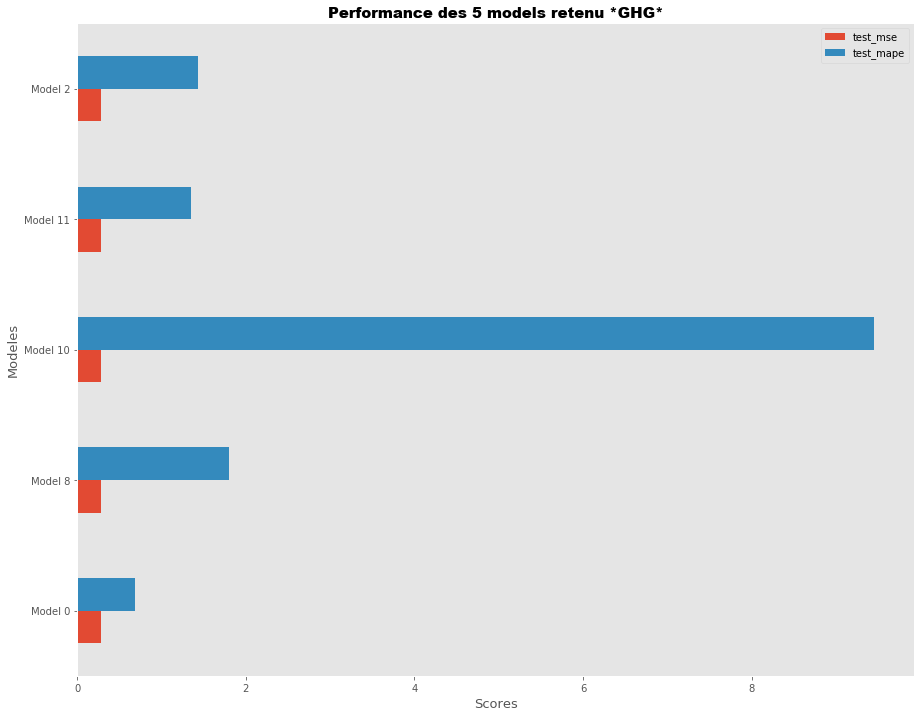

In [128]:
all_models_GHG.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *GHG*', fontname="Arial Black", size=15)

In [129]:
DfModelList = all_models_energy_complete
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_energy_complete = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_energy_complete[['test_mse', 'test_mape']] = np.abs(all_models_energy_complete[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *Energy complete*')

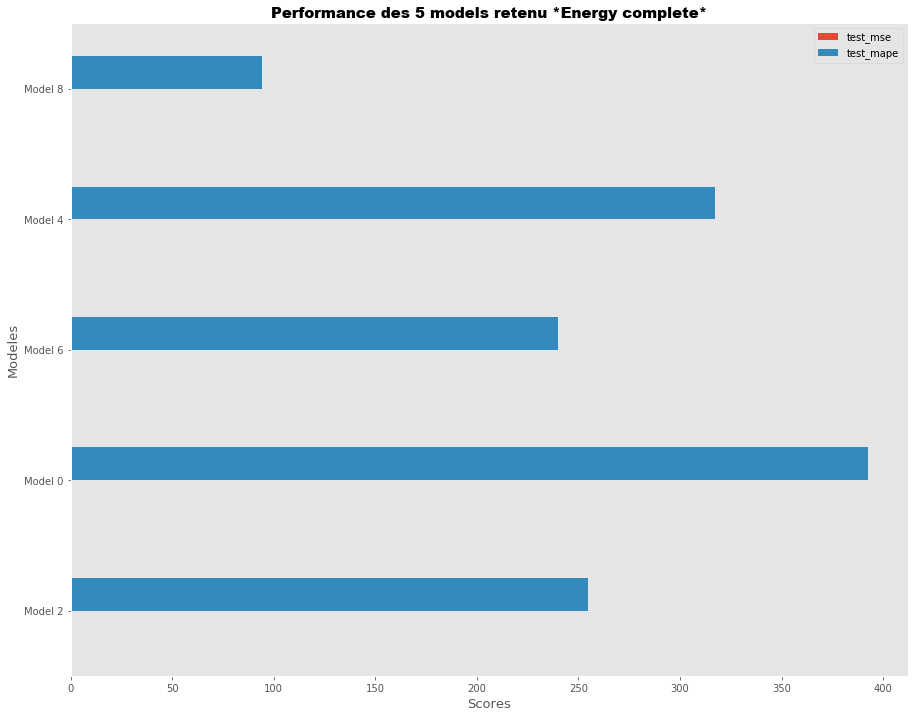

In [130]:
all_models_energy_complete.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *Energy complete*', fontname="Arial Black", size=15)

In [131]:
DfModelList = all_models_GHG_complete
for i in range(len(DfModelList)):
    DfModelList[i]['description'] = "Model %d" % i

model_df = pd.DataFrame.from_dict(DfModelList)
all_models_GHG_complete = model_df.set_index(['description']).sort_values('test_mse').head(5)
all_models_GHG_complete[['test_mse', 'test_mape']] = np.abs(all_models_GHG_complete[['test_mse', 'test_mape']])

Text(0.5, 1.0, 'Performance des 5 models retenu *GHG complete*')

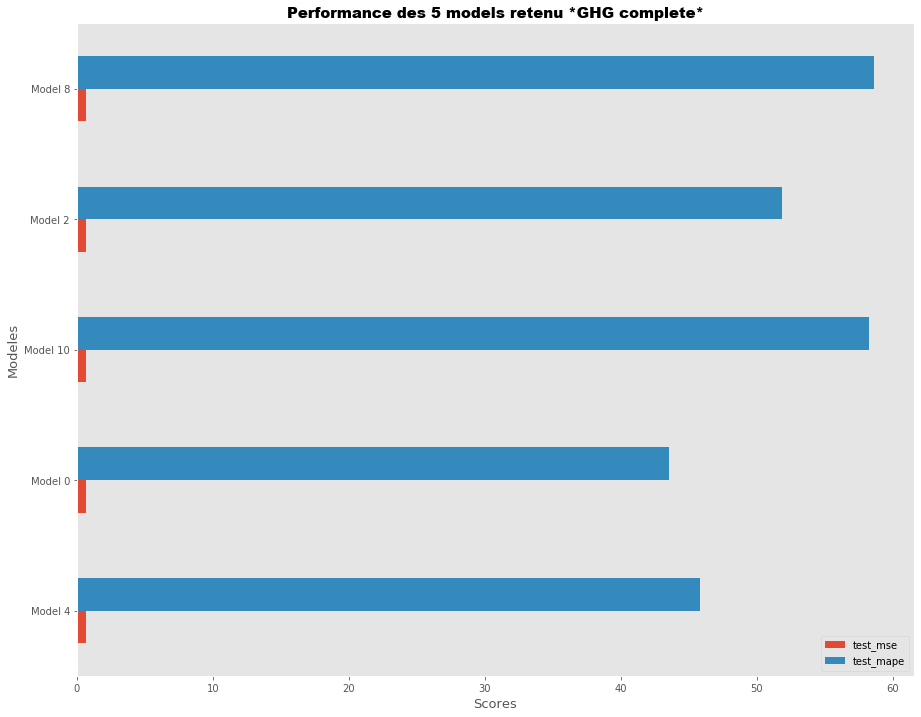

In [132]:
all_models_GHG_complete.plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 5 models retenu *GHG complete*', fontname="Arial Black", size=15)

### Avering models

Averaging the best 5 models on 10 iterations for each 4 groups of data input to have stronger data

In [133]:
Memory_DF = []
Memory_DF = pd.DataFrame(columns = ['description','test_mse','test_mape'], index = [0,1,2,3,4,5,6,7,8,9,10,11])
for i in range(len(Memory_DF['description'])):
    Memory_DF['description'][i] = "Model %d" % i
#Memory_DF = Memory_DF.set_index('description')
Memory_DF = Memory_DF.fillna(0)
Memory_models = {}
dataset_memory_models = []

In [134]:
for dataset in data_sets: 
    Memory_DF = Memory_DF.fillna(0)
    for i in range(5):
        all_models = []
        Df_models = all_models
        print("version %d of all_models :" % i, all_models)
        one_training_each(*dataset)

        for i in range(len(Df_models)):
            Memory_DF.loc[i, 'test_mse'] = np.divide(Memory_DF['test_mse'][i]+np.abs(Df_models[i]['test_mse']), 2)
            Memory_DF.loc[i,'test_mape'] = np.divide(Memory_DF['test_mape'][i]+ np.abs(Df_models[i]['test_mape']), 2)
            Memory_models['model %d' % i] = Df_models[i]['model']
            #Memory_DF_values.append([Df_models[i]['test_mse'], Df_models[i]['test_mape']])
    print("here is memory df : ", Memory_DF)
    dataset_memory_models.append([Memory_DF.copy(), Memory_models])

version 0 of all_models : []
--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 275us/sample - loss: 0.8507 - mae: 0.4984 - mape: 108.7774 - accuracy: 0.0000e+00 - val_loss: 0.7443 - val_mae: 0.4295 - val_mape: 199.5494 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 96us/sample - loss: 0.6412 - mae: 0.3150 - mape: 208.8730 - accuracy: 0.0000e+00 - val_loss: 0.5890 - val_mae: 0.2863 - val_mape: 383.5324 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5844 - mae: 0.2637 - mape: 187.7944 - accuracy: 0.0000e+00 - val_loss: 0.5632 - val_mae: 0.2627 - val_mape: 404.2625 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5684 - mae: 0.2494 - mape: 178.5814 - accuracy: 0.0000e+00 - val_loss: 0.5

Epoch 6/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5484 - mae: 0.2458 - mape: 188.0114 - accuracy: 0.0000e+00 - val_loss: 0.5301 - val_mae: 0.2458 - val_mape: 580.0509 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5419 - mae: 0.2493 - mape: 192.3756 - accuracy: 0.0000e+00 - val_loss: 0.5330 - val_mae: 0.2450 - val_mape: 536.8433 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5320 - mae: 0.2467 - mape: 198.1832 - accuracy: 0.0000e+00 - val_loss: 0.5330 - val_mae: 0.2425 - val_mape: 550.3775 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5251 - mae: 0.2416 - mape: 187.7270 - accuracy: 0.0000e+00 - val_loss: 0.5346 - val_mae: 0.2486 - val_mape: 616.6238 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5318 - mae: 0.2476

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5009 - mae: 0.2535 - mape: 202.7494 - accuracy: 0.0000e+00 - val_loss: 0.5391 - val_mae: 0.2558 - val_mape: 244.0770 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4893 - mae: 0.2530 - mape: 166.6222 - accuracy: 0.0000e+00 - val_loss: 0.5490 - val_mae: 0.2617 - val_mape: 315.3173 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4899 - mae: 0.2587 - mape: 201.3903 - accuracy: 0.0000e+00 - val_loss: 0.5667 - val_mae: 0.2696 - val_mape: 340.0411 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4743 - mae: 0.2494 - mape: 203.5116 - accuracy: 0.0000e+00 - val_loss: 0.5527 - val_mae: 0.2540 - val_mape: 334.5291 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4756 - mae: 0.2484 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.3297 - mae: 0.2014 - mape: 166.9149 - accuracy: 0.0000e+00 - val_loss: 0.7114 - val_mae: 0.2751 - val_mape: 382.3485 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3881 - mae: 0.2152 - mape: 143.1317 - accuracy: 0.0000e+00 - val_loss: 0.5514 - val_mae: 0.2426 - val_mape: 319.6320 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3315 - mae: 0.2103 - mape: 186.6829 - accuracy: 0.0000e+00 - val_loss: 0.7530 - val_mae: 0.2741 - val_mape: 352.3041 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3371 - mae: 0.2047 - mape: 136.8361 - accuracy: 0.0000e+00 - val_loss: 0.8701 - val_mae: 0.2776 - val_mape: 408.5648 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3293 - mae: 0.1994 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 436us/sample - loss: 0.7073 - mae: 0.3722 - mape: 173.0565 - accuracy: 0.0000e+00 - val_loss: 0.5675 - val_mae: 0.2936 - val_mape: 545.5170 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6039 - mae: 0.2822 - mape: 201.7207 - accuracy: 0.0000e+00 - val_loss: 0.5489 - val_mae: 0.2738 - val_mape: 618.5349 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5792 - mae: 0.2682 - mape: 181.7975 - accuracy: 0.0000e+00 - val_loss: 0.5359 - val_mae: 0.2591 - val_mape: 606.1119 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5675 - mae: 0.2573 - mape: 186.6678 - accuracy: 0.0000e+00 - val_loss: 0.5306 - val_mae: 0.2470 - val_mape: 548.8022 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 72us/sample - loss: 0.5559 - mae: 0.2642 - mape: 144.9268 - accuracy: 0.0000e+00 - val_loss: 0.5535 - val_mae: 0.2568 - val_mape: 408.6062 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5004 - mae: 0.2428 - mape: 161.4497 - accuracy: 0.0000e+00 - val_loss: 0.5296 - val_mae: 0.2464 - val_mape: 393.6609 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4854 - mae: 0.2351 - mape: 164.3326 - accuracy: 0.0000e+00 - val_loss: 0.5172 - val_mae: 0.2412 - val_mape: 415.1892 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4675 - mae: 0.2270 - mape: 134.3959 - accuracy: 0.0000e+00 - val_loss: 0.5165 - val_mae: 0.2510 - val_mape: 385.0216 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.4627 - mae: 0.2335 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4068 - mae: 0.2185 - mape: 184.4840 - accuracy: 0.0000e+00 - val_loss: 0.6721 - val_mae: 0.2570 - val_mape: 408.0477 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3916 - mae: 0.2199 - mape: 175.8566 - accuracy: 0.0000e+00 - val_loss: 0.6243 - val_mae: 0.2429 - val_mape: 298.0435 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4028 - mae: 0.2263 - mape: 145.1121 - accuracy: 0.0000e+00 - val_loss: 0.6641 - val_mae: 0.2952 - val_mape: 374.3728 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3578 - mae: 0.2116 - mape: 163.3904 - accuracy: 0.0000e+00 - val_loss: 0.5895 - val_mae: 0.2529 - val_mape: 320.1068 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3257 - mae: 0.1979 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 278us/sample - loss: 0.8474 - mae: 0.4984 - mape: 116.9880 - accuracy: 0.0000e+00 - val_loss: 0.7138 - val_mae: 0.4081 - val_mape: 211.6036 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6271 - mae: 0.3016 - mape: 197.0746 - accuracy: 0.0000e+00 - val_loss: 0.5907 - val_mae: 0.2903 - val_mape: 336.9833 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5889 - mae: 0.2743 - mape: 198.3846 - accuracy: 0.0000e+00 - val_loss: 0.5700 - val_mae: 0.2765 - val_mape: 413.7248 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5740 - mae: 0.2670 - mape: 185.3795 - accuracy: 0.0000e+00 - val_loss: 0.5472 - val_mae: 0.2553 - val_mape: 436.6411 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 60us/sample - loss: 0.5235 - mae: 0.2344 - mape: 180.2836 - accuracy: 0.0000e+00 - val_loss: 0.5117 - val_mae: 0.2351 - val_mape: 579.1078 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5234 - mae: 0.2358 - mape: 190.2155 - accuracy: 0.0000e+00 - val_loss: 0.5072 - val_mae: 0.2330 - val_mape: 580.1618 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5226 - mae: 0.2361 - mape: 197.8251 - accuracy: 0.0000e+00 - val_loss: 0.5080 - val_mae: 0.2355 - val_mape: 559.4326 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5159 - mae: 0.2344 - mape: 183.6364 - accuracy: 0.0000e+00 - val_loss: 0.5053 - val_mae: 0.2316 - val_mape: 537.1212 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5133 - mae: 0.2311 - mape:

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5045 - mae: 0.2421 - mape: 187.4115 - accuracy: 0.0000e+00 - val_loss: 0.5197 - val_mae: 0.2457 - val_mape: 534.0221 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4985 - mae: 0.2407 - mape: 177.2742 - accuracy: 0.0000e+00 - val_loss: 0.5205 - val_mae: 0.2412 - val_mape: 518.0038 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4945 - mae: 0.2449 - mape: 196.8933 - accuracy: 0.0000e+00 - val_loss: 0.5199 - val_mae: 0.2436 - val_mape: 519.8057 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.4950 - mae: 0.2419 - mape: 195.4786 - accuracy: 0.0000e+00 - val_loss: 0.5283 - val_mae: 0.2475 - val_mape: 475.6765 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5007 - mae: 0.2428 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 474us/sample - loss: 0.6989 - mae: 0.3654 - mape: 192.1237 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_mae: 0.2983 - val_mape: 541.8412 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 79us/sample - loss: 0.5930 - mae: 0.2720 - mape: 195.5351 - accuracy: 0.0000e+00 - val_loss: 0.5366 - val_mae: 0.2579 - val_mape: 557.4455 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 77us/sample - loss: 0.5742 - mae: 0.2584 - mape: 187.2698 - accuracy: 0.0000e+00 - val_loss: 0.5349 - val_mae: 0.2550 - val_mape: 558.5181 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 78us/sample - loss: 0.5569 - mae: 0.2492 - mape: 193.2653 - accuracy: 0.0000e+00 - val_loss: 0.5323 - val_mae: 0.2474 - val_mape: 532.4348 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 71us/sample - loss: 0.5821 - mae: 0.2576 - mape: 163.2262 - accuracy: 0.0000e+00 - val_loss: 0.6268 - val_mae: 0.3019 - val_mape: 146.8241 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5308 - mae: 0.2593 - mape: 171.3444 - accuracy: 0.0000e+00 - val_loss: 0.5489 - val_mae: 0.2503 - val_mape: 481.0148 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4876 - mae: 0.2409 - mape: 192.7991 - accuracy: 0.0000e+00 - val_loss: 0.5363 - val_mae: 0.2394 - val_mape: 364.4794 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4635 - mae: 0.2351 - mape: 167.4154 - accuracy: 0.0000e+00 - val_loss: 0.5316 - val_mae: 0.2420 - val_mape: 414.0021 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4578 - mae: 0.2314 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.3959 - mae: 0.2222 - mape: 152.5254 - accuracy: 0.0000e+00 - val_loss: 0.6049 - val_mae: 0.2614 - val_mape: 306.4476 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3949 - mae: 0.2235 - mape: 171.2180 - accuracy: 0.0000e+00 - val_loss: 0.6827 - val_mae: 0.2888 - val_mape: 322.7926 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3886 - mae: 0.2237 - mape: 169.1268 - accuracy: 0.0000e+00 - val_loss: 0.7166 - val_mae: 0.2668 - val_mape: 287.1336 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3657 - mae: 0.2198 - mape: 162.1942 - accuracy: 0.0000e+00 - val_loss: 0.7437 - val_mae: 0.3427 - val_mape: 258.6280 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3848 - mae: 0.2259 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 276us/sample - loss: 0.8447 - mae: 0.4830 - mape: 108.8742 - accuracy: 0.0000e+00 - val_loss: 0.7450 - val_mae: 0.4354 - val_mape: 234.9312 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6450 - mae: 0.3110 - mape: 195.1196 - accuracy: 0.0000e+00 - val_loss: 0.6031 - val_mae: 0.3028 - val_mape: 405.1919 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5918 - mae: 0.2692 - mape: 177.6650 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_mae: 0.2713 - val_mape: 422.1493 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5760 - mae: 0.2555 - mape: 187.6387 - accuracy: 0.0000e+00 - val_loss: 0.5543 - val_mae: 0.2587 - val_mape: 442.0634 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 55us/sample - loss: 0.5326 - mae: 0.2421 - mape: 200.9127 - accuracy: 0.0000e+00 - val_loss: 0.5112 - val_mae: 0.2399 - val_mape: 597.5339 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5226 - mae: 0.2392 - mape: 205.4179 - accuracy: 0.0000e+00 - val_loss: 0.5084 - val_mae: 0.2412 - val_mape: 639.0370 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5251 - mae: 0.2382 - mape: 198.5601 - accuracy: 0.0000e+00 - val_loss: 0.5070 - val_mae: 0.2405 - val_mape: 620.1980 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5257 - mae: 0.2397 - mape: 193.7213 - accuracy: 0.0000e+00 - val_loss: 0.5046 - val_mae: 0.2393 - val_mape: 607.1385 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5144 - mae: 0.2376 - mape:

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4763 - mae: 0.2344 - mape: 163.3017 - accuracy: 0.0000e+00 - val_loss: 0.5404 - val_mae: 0.2433 - val_mape: 455.9394 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4666 - mae: 0.2354 - mape: 178.2777 - accuracy: 0.0000e+00 - val_loss: 0.5476 - val_mae: 0.2551 - val_mape: 428.4745 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4612 - mae: 0.2315 - mape: 167.3268 - accuracy: 0.0000e+00 - val_loss: 0.5509 - val_mae: 0.2588 - val_mape: 422.6828 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4497 - mae: 0.2295 - mape: 170.7863 - accuracy: 0.0000e+00 - val_loss: 0.5558 - val_mae: 0.2497 - val_mape: 417.0399 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4453 - mae: 0.2330 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 3s 1ms/sample - loss: 0.7083 - mae: 0.3724 - mape: 185.1298 - accuracy: 0.0000e+00 - val_loss: 0.5755 - val_mae: 0.3133 - val_mape: 542.8556 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 86us/sample - loss: 0.6000 - mae: 0.2837 - mape: 196.9610 - accuracy: 0.0000e+00 - val_loss: 0.5384 - val_mae: 0.2637 - val_mape: 606.7273 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 79us/sample - loss: 0.5792 - mae: 0.2646 - mape: 183.9047 - accuracy: 0.0000e+00 - val_loss: 0.5324 - val_mae: 0.2522 - val_mape: 569.2833 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 78us/sample - loss: 0.5613 - mae: 0.2547 - mape: 181.9993 - accuracy: 0.0000e+00 - val_loss: 0.5295 - val_mae: 0.2433 - val_mape: 532.8645 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] 

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5095 - mae: 0.2427 - mape: 194.1895 - accuracy: 0.0000e+00 - val_loss: 0.5224 - val_mae: 0.2447 - val_mape: 432.5447 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4995 - mae: 0.2412 - mape: 192.4710 - accuracy: 0.0000e+00 - val_loss: 0.5226 - val_mae: 0.2482 - val_mape: 439.9710 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4945 - mae: 0.2385 - mape: 162.1603 - accuracy: 0.0000e+00 - val_loss: 0.5161 - val_mae: 0.2461 - val_mape: 421.6019 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.4812 - mae: 0.2379 - mape: 171.0467 - accuracy: 0.0000e+00 - val_loss: 0.5234 - val_mae: 0.2616 - val_mape: 388.1013 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.4762 - mae: 0.2341 - mape:

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4305 - mae: 0.2444 - mape: 168.7075 - accuracy: 0.0000e+00 - val_loss: 0.5320 - val_mae: 0.2653 - val_mape: 542.7464 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4732 - mae: 0.2491 - mape: 199.1033 - accuracy: 0.0000e+00 - val_loss: 0.5702 - val_mae: 0.2504 - val_mape: 358.5138 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4186 - mae: 0.2373 - mape: 175.7368 - accuracy: 0.0000e+00 - val_loss: 0.5319 - val_mae: 0.2448 - val_mape: 287.3904 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3877 - mae: 0.2308 - mape: 174.9378 - accuracy: 0.0000e+00 - val_loss: 0.6273 - val_mae: 0.2947 - val_mape: 254.9902 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4271 - mae: 0.2388 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 273us/sample - loss: 0.8422 - mae: 0.4929 - mape: 110.4653 - accuracy: 0.0000e+00 - val_loss: 0.7442 - val_mae: 0.4358 - val_mape: 224.7132 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6400 - mae: 0.3117 - mape: 180.4100 - accuracy: 0.0000e+00 - val_loss: 0.5999 - val_mae: 0.3025 - val_mape: 400.5964 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5929 - mae: 0.2739 - mape: 201.0226 - accuracy: 0.0000e+00 - val_loss: 0.5711 - val_mae: 0.2739 - val_mape: 431.0745 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5792 - mae: 0.2630 - mape: 177.6865 - accuracy: 0.0000e+00 - val_loss: 0.5625 - val_mae: 0.2660 - val_mape: 459.3696 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5203 - mae: 0.2359 - mape: 182.5797 - accuracy: 0.0000e+00 - val_loss: 0.5106 - val_mae: 0.2412 - val_mape: 534.2958 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5176 - mae: 0.2371 - mape: 196.0010 - accuracy: 0.0000e+00 - val_loss: 0.5110 - val_mae: 0.2403 - val_mape: 529.1157 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5152 - mae: 0.2377 - mape: 192.7648 - accuracy: 0.0000e+00 - val_loss: 0.5149 - val_mae: 0.2440 - val_mape: 501.5605 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5153 - mae: 0.2355 - mape: 184.4536 - accuracy: 0.0000e+00 - val_loss: 0.5121 - val_mae: 0.2413 - val_mape: 503.6314 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5077 - mae: 0.2296 - mape:

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4987 - mae: 0.2408 - mape: 185.0030 - accuracy: 0.0000e+00 - val_loss: 0.5245 - val_mae: 0.2440 - val_mape: 552.2643 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4987 - mae: 0.2399 - mape: 182.7227 - accuracy: 0.0000e+00 - val_loss: 0.5287 - val_mae: 0.2404 - val_mape: 520.8929 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4822 - mae: 0.2368 - mape: 170.4672 - accuracy: 0.0000e+00 - val_loss: 0.5323 - val_mae: 0.2403 - val_mape: 484.5507 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4809 - mae: 0.2354 - mape: 185.7063 - accuracy: 0.0000e+00 - val_loss: 0.5379 - val_mae: 0.2435 - val_mape: 498.2618 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4700 - mae: 0.2360 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 440us/sample - loss: 0.7254 - mae: 0.3820 - mape: 187.9427 - accuracy: 0.0000e+00 - val_loss: 0.5753 - val_mae: 0.2991 - val_mape: 423.4720 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6047 - mae: 0.2804 - mape: 204.9905 - accuracy: 0.0000e+00 - val_loss: 0.5452 - val_mae: 0.2619 - val_mape: 554.9744 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5781 - mae: 0.2620 - mape: 190.5523 - accuracy: 0.0000e+00 - val_loss: 0.5290 - val_mae: 0.2438 - val_mape: 598.0852 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5669 - mae: 0.2539 - mape: 190.4507 - accuracy: 0.0000e+00 - val_loss: 0.5299 - val_mae: 0.2476 - val_mape: 572.0883 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5293 - mae: 0.2510 - mape: 186.9214 - accuracy: 0.0000e+00 - val_loss: 0.5366 - val_mae: 0.2431 - val_mape: 406.2579 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5177 - mae: 0.2482 - mape: 179.6198 - accuracy: 0.0000e+00 - val_loss: 0.5276 - val_mae: 0.2379 - val_mape: 348.9889 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5107 - mae: 0.2475 - mape: 184.4756 - accuracy: 0.0000e+00 - val_loss: 0.5262 - val_mae: 0.2384 - val_mape: 240.6531 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5039 - mae: 0.2428 - mape: 158.0317 - accuracy: 0.0000e+00 - val_loss: 0.5233 - val_mae: 0.2354 - val_mape: 204.0240 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4915 - mae: 0.2453 - mape:

2620/2620 [==============================] - 0s 72us/sample - loss: 0.3838 - mae: 0.2275 - mape: 183.6411 - accuracy: 0.0000e+00 - val_loss: 0.6625 - val_mae: 0.2578 - val_mape: 303.3596 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3851 - mae: 0.2191 - mape: 168.5950 - accuracy: 0.0000e+00 - val_loss: 0.6049 - val_mae: 0.2533 - val_mape: 488.9351 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3866 - mae: 0.2186 - mape: 201.7261 - accuracy: 0.0000e+00 - val_loss: 0.7060 - val_mae: 0.2575 - val_mape: 274.9624 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3563 - mae: 0.2102 - mape: 162.7504 - accuracy: 0.0000e+00 - val_loss: 0.7127 - val_mae: 0.2510 - val_mape: 320.6096 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3658 - mae: 0.2195 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 280us/sample - loss: 0.8206 - mae: 0.4759 - mape: 110.8123 - accuracy: 0.0000e+00 - val_loss: 0.7258 - val_mae: 0.4157 - val_mape: 195.1419 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6150 - mae: 0.2895 - mape: 185.4077 - accuracy: 0.0000e+00 - val_loss: 0.5969 - val_mae: 0.2946 - val_mape: 343.8253 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5803 - mae: 0.2606 - mape: 177.7613 - accuracy: 0.0000e+00 - val_loss: 0.5783 - val_mae: 0.2797 - val_mape: 399.6428 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5687 - mae: 0.2511 - mape: 165.1563 - accuracy: 0.0000e+00 - val_loss: 0.5508 - val_mae: 0.2562 - val_mape: 451.4999 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5237 - mae: 0.2368 - mape: 194.5390 - accuracy: 0.0000e+00 - val_loss: 0.5140 - val_mae: 0.2359 - val_mape: 476.3041 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5231 - mae: 0.2392 - mape: 194.7051 - accuracy: 0.0000e+00 - val_loss: 0.5170 - val_mae: 0.2406 - val_mape: 454.0610 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5199 - mae: 0.2384 - mape: 181.1498 - accuracy: 0.0000e+00 - val_loss: 0.5142 - val_mae: 0.2338 - val_mape: 460.9378 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5195 - mae: 0.2359 - mape: 187.0513 - accuracy: 0.0000e+00 - val_loss: 0.5108 - val_mae: 0.2318 - val_mape: 489.0592 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5161 - mae: 0.2393 - mape:

2620/2620 [==============================] - 0s 53us/sample - loss: 0.6088 - mae: 0.3279 - mape: 290.3421 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_mae: 0.3395 - val_mape: 1044.0555 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6051 - mae: 0.3260 - mape: 280.3487 - accuracy: 0.0000e+00 - val_loss: 0.5715 - val_mae: 0.3444 - val_mape: 1101.9238 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5998 - mae: 0.3252 - mape: 267.8037 - accuracy: 0.0000e+00 - val_loss: 0.5711 - val_mae: 0.3432 - val_mape: 1079.5602 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.5984 - mae: 0.3264 - mape: 278.4182 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_mae: 0.3404 - val_mape: 1046.5520 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5954 - mae: 0.3248 - m

2620/2620 [==============================] - 0s 53us/sample - loss: 0.6019 - mae: 0.3329 - mape: 267.9879 - accuracy: 0.0000e+00 - val_loss: 0.5590 - val_mae: 0.3425 - val_mape: 933.9205 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5992 - mae: 0.3343 - mape: 294.5048 - accuracy: 0.0000e+00 - val_loss: 0.5601 - val_mae: 0.3465 - val_mape: 991.3480 - val_accuracy: 0.0000e+00
accuracy here is :  0.7483923440209377
--- Starting trial: logs/fit/run-3
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 452us/sample - loss: 0.8244 - mae: 0.4633 - mape: 186.5329 - accuracy: 0.0000e+00 - val_loss: 0.6929 - val_mae: 0.4209 - val_mape: 984.2337 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.7068 - mae: 0.3761 - mape: 273.8000 - accuracy: 0.0000e+00 - val_loss: 0.674

Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6761 - mae: 0.3463 - mape: 269.7204 - accuracy: 0.0000e+00 - val_loss: 0.6201 - val_mae: 0.3471 - val_mape: 827.1904 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6605 - mae: 0.3420 - mape: 305.2594 - accuracy: 0.0000e+00 - val_loss: 0.6065 - val_mae: 0.3444 - val_mape: 884.8112 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6489 - mae: 0.3366 - mape: 308.0854 - accuracy: 0.0000e+00 - val_loss: 0.5959 - val_mae: 0.3412 - val_mape: 925.2532 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6413 - mae: 0.3338 - mape: 282.7175 - accuracy: 0.0000e+00 - val_loss: 0.5894 - val_mae: 0.3408 - val_mape: 998.3987 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6355 - mae: 0.3322 

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6233 - mae: 0.3318 - mape: 299.2124 - accuracy: 0.0000e+00 - val_loss: 0.5729 - val_mae: 0.3371 - val_mape: 1048.1537 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6236 - mae: 0.3327 - mape: 317.1111 - accuracy: 0.0000e+00 - val_loss: 0.5723 - val_mae: 0.3375 - val_mape: 1006.5543 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6204 - mae: 0.3360 - mape: 314.8148 - accuracy: 0.0000e+00 - val_loss: 0.5729 - val_mae: 0.3419 - val_mape: 1108.5947 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6105 - mae: 0.3313 - mape: 316.5883 - accuracy: 0.0000e+00 - val_loss: 0.5715 - val_mae: 0.3370 - val_mape: 1007.7514 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6126 - mae: 0.3326 - m

2620/2620 [==============================] - 0s 59us/sample - loss: 0.5689 - mae: 0.3188 - mape: 261.8481 - accuracy: 0.0000e+00 - val_loss: 0.5877 - val_mae: 0.3411 - val_mape: 687.6824 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5768 - mae: 0.3225 - mape: 289.2893 - accuracy: 0.0000e+00 - val_loss: 0.5873 - val_mae: 0.3450 - val_mape: 718.2932 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.5744 - mae: 0.3188 - mape: 270.9854 - accuracy: 0.0000e+00 - val_loss: 0.5876 - val_mae: 0.3459 - val_mape: 761.9382 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5673 - mae: 0.3196 - mape: 296.2571 - accuracy: 0.0000e+00 - val_loss: 0.5904 - val_mae: 0.3473 - val_mape: 759.9974 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5594 - mae: 0.3191 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6643 - mae: 0.3532 - mape: 268.5075 - accuracy: 0.0000e+00 - val_loss: 0.6122 - val_mae: 0.3682 - val_mape: 1025.6570 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6517 - mae: 0.3487 - mape: 269.1492 - accuracy: 0.0000e+00 - val_loss: 0.6022 - val_mae: 0.3605 - val_mape: 972.3280 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6383 - mae: 0.3432 - mape: 255.5609 - accuracy: 0.0000e+00 - val_loss: 0.6048 - val_mae: 0.3644 - val_mape: 1031.2471 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6312 - mae: 0.3439 - mape: 255.8145 - accuracy: 0.0000e+00 - val_loss: 0.5860 - val_mae: 0.3458 - val_mape: 930.1411 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6358 - mae: 0.342

2620/2620 [==============================] - 0s 66us/sample - loss: 0.5921 - mae: 0.3283 - mape: 263.7166 - accuracy: 0.0000e+00 - val_loss: 0.6048 - val_mae: 0.3455 - val_mape: 811.0834 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5882 - mae: 0.3261 - mape: 246.5275 - accuracy: 0.0000e+00 - val_loss: 0.6061 - val_mae: 0.3471 - val_mape: 874.2826 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5788 - mae: 0.3263 - mape: 240.2269 - accuracy: 0.0000e+00 - val_loss: 0.6251 - val_mae: 0.3503 - val_mape: 802.6318 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5834 - mae: 0.3264 - mape: 256.5711 - accuracy: 0.0000e+00 - val_loss: 0.6323 - val_mae: 0.3495 - val_mape: 870.2863 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5714 - mae: 0.3205 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5442 - mae: 0.3202 - mape: 239.3985 - accuracy: 0.0000e+00 - val_loss: 0.7609 - val_mae: 0.3625 - val_mape: 752.8643 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5047 - mae: 0.3224 - mape: 266.2752 - accuracy: 0.0000e+00 - val_loss: 0.6660 - val_mae: 0.3538 - val_mape: 488.1584 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5463 - mae: 0.3220 - mape: 244.6898 - accuracy: 0.0000e+00 - val_loss: 0.6917 - val_mae: 0.3567 - val_mape: 887.0125 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5088 - mae: 0.3165 - mape: 243.8956 - accuracy: 0.0000e+00 - val_loss: 0.6355 - val_mae: 0.3525 - val_mape: 519.6180 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.5134 - mae: 0.3176 - mape:

2620/2620 [==============================] - 0s 59us/sample - loss: 0.6971 - mae: 0.3630 - mape: 283.7858 - accuracy: 0.0000e+00 - val_loss: 0.6345 - val_mae: 0.3534 - val_mape: 752.9298 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6739 - mae: 0.3506 - mape: 319.1261 - accuracy: 0.0000e+00 - val_loss: 0.6168 - val_mae: 0.3495 - val_mape: 901.2181 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6724 - mae: 0.3483 - mape: 310.9656 - accuracy: 0.0000e+00 - val_loss: 0.6086 - val_mae: 0.3468 - val_mape: 926.2082 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6548 - mae: 0.3412 - mape: 289.3176 - accuracy: 0.0000e+00 - val_loss: 0.5971 - val_mae: 0.3442 - val_mape: 1021.3875 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6480 - mae: 0.3385 - mape: 30

2620/2620 [==============================] - 0s 58us/sample - loss: 0.6117 - mae: 0.3279 - mape: 310.6504 - accuracy: 0.0000e+00 - val_loss: 0.5759 - val_mae: 0.3421 - val_mape: 1074.3372 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6017 - mae: 0.3260 - mape: 303.9898 - accuracy: 0.0000e+00 - val_loss: 0.5764 - val_mae: 0.3430 - val_mape: 999.8675 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5998 - mae: 0.3298 - mape: 296.7708 - accuracy: 0.0000e+00 - val_loss: 0.5756 - val_mae: 0.3407 - val_mape: 945.8901 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5968 - mae: 0.3263 - mape: 282.1627 - accuracy: 0.0000e+00 - val_loss: 0.5755 - val_mae: 0.3411 - val_mape: 978.9886 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5990 - mae: 0.3250 - mape

2620/2620 [==============================] - 0s 60us/sample - loss: 0.5858 - mae: 0.3291 - mape: 299.3289 - accuracy: 0.0000e+00 - val_loss: 0.5829 - val_mae: 0.3411 - val_mape: 840.6630 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5837 - mae: 0.3279 - mape: 323.3200 - accuracy: 0.0000e+00 - val_loss: 0.5887 - val_mae: 0.3464 - val_mape: 829.3026 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5828 - mae: 0.3260 - mape: 266.5093 - accuracy: 0.0000e+00 - val_loss: 0.5853 - val_mae: 0.3421 - val_mape: 933.1794 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5718 - mae: 0.3249 - mape: 301.2317 - accuracy: 0.0000e+00 - val_loss: 0.5889 - val_mae: 0.3444 - val_mape: 882.3424 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5790 - mae: 0.3246 - mape:

2620/2620 [==============================] - 0s 72us/sample - loss: 0.6965 - mae: 0.3721 - mape: 285.8831 - accuracy: 0.0000e+00 - val_loss: 0.6402 - val_mae: 0.3861 - val_mape: 1041.9935 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6766 - mae: 0.3609 - mape: 296.4300 - accuracy: 0.0000e+00 - val_loss: 0.6287 - val_mae: 0.3767 - val_mape: 1031.5969 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6624 - mae: 0.3526 - mape: 264.2215 - accuracy: 0.0000e+00 - val_loss: 0.6110 - val_mae: 0.3641 - val_mape: 1113.3264 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6428 - mae: 0.3424 - mape: 272.0040 - accuracy: 0.0000e+00 - val_loss: 0.5965 - val_mae: 0.3524 - val_mape: 1010.8983 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6428 - mae: 0.3451 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.6025 - mae: 0.3364 - mape: 241.1299 - accuracy: 0.0000e+00 - val_loss: 0.6035 - val_mae: 0.3514 - val_mape: 936.7811 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6042 - mae: 0.3323 - mape: 248.2699 - accuracy: 0.0000e+00 - val_loss: 0.6046 - val_mae: 0.3484 - val_mape: 972.2544 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5999 - mae: 0.3303 - mape: 255.9716 - accuracy: 0.0000e+00 - val_loss: 0.6142 - val_mae: 0.3534 - val_mape: 944.2994 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5886 - mae: 0.3311 - mape: 275.7260 - accuracy: 0.0000e+00 - val_loss: 0.6174 - val_mae: 0.3535 - val_mape: 921.8585 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5836 - mae: 0.3297 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5502 - mae: 0.3151 - mape: 232.0055 - accuracy: 0.0000e+00 - val_loss: 0.7258 - val_mae: 0.3583 - val_mape: 984.8300 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5393 - mae: 0.3160 - mape: 235.5810 - accuracy: 0.0000e+00 - val_loss: 0.7639 - val_mae: 0.3613 - val_mape: 783.8162 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5377 - mae: 0.3122 - mape: 239.8745 - accuracy: 0.0000e+00 - val_loss: 0.7383 - val_mae: 0.3590 - val_mape: 827.5797 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5039 - mae: 0.3054 - mape: 228.0076 - accuracy: 0.0000e+00 - val_loss: 0.7526 - val_mae: 0.3571 - val_mape: 615.9666 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5017 - mae: 0.3075 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.7189 - mae: 0.3740 - mape: 257.0942 - accuracy: 0.0000e+00 - val_loss: 0.6518 - val_mae: 0.3623 - val_mape: 667.2452 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6831 - mae: 0.3496 - mape: 302.7812 - accuracy: 0.0000e+00 - val_loss: 0.6210 - val_mae: 0.3511 - val_mape: 856.2872 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6681 - mae: 0.3446 - mape: 304.9326 - accuracy: 0.0000e+00 - val_loss: 0.6046 - val_mae: 0.3493 - val_mape: 949.4533 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6529 - mae: 0.3404 - mape: 307.5874 - accuracy: 0.0000e+00 - val_loss: 0.5927 - val_mae: 0.3458 - val_mape: 1029.6079 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6399 - mae: 0.3357

2620/2620 [==============================] - 0s 59us/sample - loss: 0.6184 - mae: 0.3303 - mape: 290.0714 - accuracy: 0.0000e+00 - val_loss: 0.5761 - val_mae: 0.3410 - val_mape: 1024.0374 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6173 - mae: 0.3274 - mape: 305.9795 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_mae: 0.3399 - val_mape: 997.8279 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6163 - mae: 0.3317 - mape: 308.4264 - accuracy: 0.0000e+00 - val_loss: 0.5741 - val_mae: 0.3430 - val_mape: 963.6121 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6076 - mae: 0.3297 - mape: 303.6206 - accuracy: 0.0000e+00 - val_loss: 0.5737 - val_mae: 0.3427 - val_mape: 947.4565 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6004 - mae: 0.3270 - mape

2620/2620 [==============================] - 0s 54us/sample - loss: 0.6037 - mae: 0.3257 - mape: 337.2987 - accuracy: 0.0000e+00 - val_loss: 0.5687 - val_mae: 0.3408 - val_mape: 1067.5940 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6052 - mae: 0.3309 - mape: 321.9767 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_mae: 0.3412 - val_mape: 1097.9291 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 52us/sample - loss: 0.5991 - mae: 0.3278 - mape: 310.5703 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_mae: 0.3398 - val_mape: 1060.5333 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5928 - mae: 0.3264 - mape: 300.4591 - accuracy: 0.0000e+00 - val_loss: 0.5678 - val_mae: 0.3393 - val_mape: 1026.6560 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.5911 - mae: 0.3268 - m

Epoch 2/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.6993 - mae: 0.3781 - mape: 314.5929 - accuracy: 0.0000e+00 - val_loss: 0.6334 - val_mae: 0.3782 - val_mape: 959.6464 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6833 - mae: 0.3659 - mape: 291.5440 - accuracy: 0.0000e+00 - val_loss: 0.6395 - val_mae: 0.3842 - val_mape: 1006.3081 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6651 - mae: 0.3566 - mape: 282.0609 - accuracy: 0.0000e+00 - val_loss: 0.6238 - val_mae: 0.3717 - val_mape: 1012.5237 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6510 - mae: 0.3498 - mape: 274.0917 - accuracy: 0.0000e+00 - val_loss: 0.6014 - val_mae: 0.3542 - val_mape: 1083.7231 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6460 - mae: 0.34

2620/2620 [==============================] - 0s 69us/sample - loss: 0.5924 - mae: 0.3297 - mape: 235.0904 - accuracy: 0.0000e+00 - val_loss: 0.6071 - val_mae: 0.3481 - val_mape: 743.1513 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5869 - mae: 0.3252 - mape: 247.4522 - accuracy: 0.0000e+00 - val_loss: 0.6153 - val_mae: 0.3500 - val_mape: 722.6376 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5810 - mae: 0.3272 - mape: 244.4535 - accuracy: 0.0000e+00 - val_loss: 0.6238 - val_mae: 0.3520 - val_mape: 699.5603 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5795 - mae: 0.3265 - mape: 243.4774 - accuracy: 0.0000e+00 - val_loss: 0.6369 - val_mae: 0.3513 - val_mape: 627.7556 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5684 - mae: 0.3205 - mape:

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5434 - mae: 0.3168 - mape: 233.5169 - accuracy: 0.0000e+00 - val_loss: 0.6653 - val_mae: 0.3505 - val_mape: 751.5613 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5463 - mae: 0.3228 - mape: 273.4063 - accuracy: 0.0000e+00 - val_loss: 0.7812 - val_mae: 0.3757 - val_mape: 805.3106 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5647 - mae: 0.3230 - mape: 225.2377 - accuracy: 0.0000e+00 - val_loss: 0.8222 - val_mae: 0.3749 - val_mape: 1453.4598 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5327 - mae: 0.3178 - mape: 247.7860 - accuracy: 0.0000e+00 - val_loss: 0.8264 - val_mae: 0.3621 - val_mape: 828.4329 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5257 - mae: 0.3151 - mape

Epoch 2/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.7317 - mae: 0.3888 - mape: 257.8896 - accuracy: 0.0000e+00 - val_loss: 0.6602 - val_mae: 0.3747 - val_mape: 775.9898 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6874 - mae: 0.3562 - mape: 302.1545 - accuracy: 0.0000e+00 - val_loss: 0.6255 - val_mae: 0.3577 - val_mape: 910.1749 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6701 - mae: 0.3504 - mape: 318.2050 - accuracy: 0.0000e+00 - val_loss: 0.6106 - val_mae: 0.3542 - val_mape: 1012.0269 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6552 - mae: 0.3449 - mape: 313.8607 - accuracy: 0.0000e+00 - val_loss: 0.6025 - val_mae: 0.3530 - val_mape: 1004.0428 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6489 - mae: 0.343

2620/2620 [==============================] - 0s 55us/sample - loss: 0.6235 - mae: 0.3333 - mape: 341.3980 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_mae: 0.3372 - val_mape: 1110.7091 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6242 - mae: 0.3329 - mape: 316.0410 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_mae: 0.3370 - val_mape: 1065.3909 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6206 - mae: 0.3302 - mape: 346.6326 - accuracy: 0.0000e+00 - val_loss: 0.5685 - val_mae: 0.3372 - val_mape: 1047.6151 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6161 - mae: 0.3324 - mape: 296.1259 - accuracy: 0.0000e+00 - val_loss: 0.5684 - val_mae: 0.3381 - val_mape: 1040.4962 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6171 - mae: 0.3324 - m

2620/2620 [==============================] - 0s 54us/sample - loss: 0.6161 - mae: 0.3302 - mape: 301.1065 - accuracy: 0.0000e+00 - val_loss: 0.5719 - val_mae: 0.3398 - val_mape: 1069.8900 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6139 - mae: 0.3307 - mape: 300.5658 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_mae: 0.3401 - val_mape: 1048.8658 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6135 - mae: 0.3274 - mape: 290.5883 - accuracy: 0.0000e+00 - val_loss: 0.5673 - val_mae: 0.3382 - val_mape: 1105.1903 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6107 - mae: 0.3266 - mape: 291.8406 - accuracy: 0.0000e+00 - val_loss: 0.5692 - val_mae: 0.3369 - val_mape: 1053.9912 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6037 - mae: 0.3275 - m

Epoch 2/30
2620/2620 [==============================] - 0s 80us/sample - loss: 0.6948 - mae: 0.3698 - mape: 279.9893 - accuracy: 0.0000e+00 - val_loss: 0.6280 - val_mae: 0.3752 - val_mape: 1040.6370 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 77us/sample - loss: 0.6764 - mae: 0.3589 - mape: 271.8051 - accuracy: 0.0000e+00 - val_loss: 0.6395 - val_mae: 0.3853 - val_mape: 996.0790 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.6622 - mae: 0.3508 - mape: 260.4390 - accuracy: 0.0000e+00 - val_loss: 0.6172 - val_mae: 0.3680 - val_mape: 1038.2423 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.6466 - mae: 0.3425 - mape: 270.3374 - accuracy: 0.0000e+00 - val_loss: 0.5993 - val_mae: 0.3568 - val_mape: 1075.6937 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6418 - mae: 0.34

2620/2620 [==============================] - 0s 71us/sample - loss: 0.6041 - mae: 0.3311 - mape: 240.4091 - accuracy: 0.0000e+00 - val_loss: 0.5992 - val_mae: 0.3462 - val_mape: 934.1863 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6007 - mae: 0.3330 - mape: 266.2340 - accuracy: 0.0000e+00 - val_loss: 0.6110 - val_mae: 0.3556 - val_mape: 896.5650 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5883 - mae: 0.3303 - mape: 243.5914 - accuracy: 0.0000e+00 - val_loss: 0.6067 - val_mae: 0.3545 - val_mape: 909.2010 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5902 - mae: 0.3318 - mape: 256.5382 - accuracy: 0.0000e+00 - val_loss: 0.6175 - val_mae: 0.3484 - val_mape: 844.4110 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5872 - mae: 0.3250 - mape:

2620/2620 [==============================] - 0s 72us/sample - loss: 0.5161 - mae: 0.3094 - mape: 231.8812 - accuracy: 0.0000e+00 - val_loss: 0.7735 - val_mae: 0.3626 - val_mape: 632.9131 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5018 - mae: 0.3042 - mape: 239.1978 - accuracy: 0.0000e+00 - val_loss: 0.8222 - val_mae: 0.3632 - val_mape: 396.7226 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4913 - mae: 0.3000 - mape: 255.6490 - accuracy: 0.0000e+00 - val_loss: 0.8687 - val_mae: 0.3685 - val_mape: 481.0811 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.5024 - mae: 0.3037 - mape: 241.9361 - accuracy: 0.0000e+00 - val_loss: 0.8501 - val_mae: 0.3650 - val_mape: 470.7178 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4933 - mae: 0.2995 - mape:

--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 284us/sample - loss: 0.7195 - mae: 0.6729 - mape: 134.4918 - accuracy: 0.0000e+00 - val_loss: 0.2688 - val_mae: 0.4025 - val_mape: 202.2104 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1715 - mae: 0.2955 - mape: 183.9150 - accuracy: 0.0000e+00 - val_loss: 0.1677 - val_mae: 0.2896 - val_mape: 196.4694 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.1413 - mae: 0.2623 - mape: 148.2904 - accuracy: 0.0000e+00 - val_loss: 0.1498 - val_mae: 0.2674 - val_mape: 188.8120 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.1302 - mae: 0.2483 - mape: 157.4000 - accuracy: 0.0000e+00 - val_loss: 0.1324 - val_mae: 0.2373 - val_m

2620/2620 [==============================] - 0s 69us/sample - loss: 0.0871 - mae: 0.1895 - mape: 96.0716 - accuracy: 0.0000e+00 - val_loss: 0.1039 - val_mae: 0.1998 - val_mape: 121.6536 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0834 - mae: 0.1856 - mape: 102.2542 - accuracy: 0.0000e+00 - val_loss: 0.0971 - val_mae: 0.1871 - val_mape: 124.3265 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0779 - mae: 0.1787 - mape: 94.0687 - accuracy: 0.0000e+00 - val_loss: 0.1022 - val_mae: 0.1978 - val_mape: 114.7070 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0777 - mae: 0.1787 - mape: 107.9693 - accuracy: 0.0000e+00 - val_loss: 0.0973 - val_mae: 0.1883 - val_mape: 118.5271 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0721 - mae: 0.1682 - mape: 89.5

Epoch 12/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0960 - mae: 0.1991 - mape: 116.6420 - accuracy: 0.0000e+00 - val_loss: 0.1037 - val_mae: 0.1965 - val_mape: 108.7546 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0930 - mae: 0.1967 - mape: 103.4120 - accuracy: 0.0000e+00 - val_loss: 0.0993 - val_mae: 0.1924 - val_mape: 109.2905 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0892 - mae: 0.1932 - mape: 108.9221 - accuracy: 0.0000e+00 - val_loss: 0.0958 - val_mae: 0.1804 - val_mape: 95.8391 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 52us/sample - loss: 0.0870 - mae: 0.1921 - mape: 113.4571 - accuracy: 0.0000e+00 - val_loss: 0.0934 - val_mae: 0.1795 - val_mape: 94.9889 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0907 - mae: 0.19

Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0675 - mae: 0.1634 - mape: 113.7683 - accuracy: 0.0000e+00 - val_loss: 0.1187 - val_mae: 0.2146 - val_mape: 122.3789 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0683 - mae: 0.1674 - mape: 90.3835 - accuracy: 0.0000e+00 - val_loss: 0.0940 - val_mae: 0.1824 - val_mape: 109.6770 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0710 - mae: 0.1672 - mape: 83.8134 - accuracy: 0.0000e+00 - val_loss: 0.1009 - val_mae: 0.1972 - val_mape: 126.0604 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0653 - mae: 0.1626 - mape: 85.1490 - accuracy: 0.0000e+00 - val_loss: 0.1123 - val_mae: 0.2043 - val_mape: 122.5249 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0645 - mae: 0.164

Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0616 - mae: 0.1524 - mape: 94.8299 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_mae: 0.1502 - val_mape: 91.4447 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0591 - mae: 0.1503 - mape: 91.1388 - accuracy: 0.0000e+00 - val_loss: 0.0844 - val_mae: 0.1601 - val_mape: 79.7648 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0606 - mae: 0.1501 - mape: 76.7258 - accuracy: 0.0000e+00 - val_loss: 0.0816 - val_mae: 0.1570 - val_mape: 93.4953 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0603 - mae: 0.1507 - mape: 83.0559 - accuracy: 0.0000e+00 - val_loss: 0.0801 - val_mae: 0.1504 - val_mape: 88.4768 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0547 - mae: 0.1440 - m

Epoch 30/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0462 - mae: 0.1374 - mape: 75.7007 - accuracy: 0.0000e+00 - val_loss: 0.1046 - val_mae: 0.1826 - val_mape: 95.9503 - val_accuracy: 0.0000e+00
accuracy here is :  0.32335115581509644
--- Starting trial: logs/fit/run-6
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 284us/sample - loss: 0.6405 - mae: 0.6293 - mape: 134.7411 - accuracy: 0.0000e+00 - val_loss: 0.2029 - val_mae: 0.3414 - val_mape: 255.3488 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.1690 - mae: 0.2957 - mape: 174.0909 - accuracy: 0.0000e+00 - val_loss: 0.1602 - val_mae: 0.2805 - val_mape: 202.5332 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.1464 - mae: 0.2666 - mape: 151.8569 - accuracy: 0.0000e+00 - val

Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.1059 - mae: 0.2150 - mape: 132.9589 - accuracy: 0.0000e+00 - val_loss: 0.1263 - val_mae: 0.2409 - val_mape: 152.2017 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0903 - mae: 0.1960 - mape: 104.1909 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_mae: 0.2125 - val_mape: 129.5795 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0859 - mae: 0.1904 - mape: 93.0197 - accuracy: 0.0000e+00 - val_loss: 0.0954 - val_mae: 0.1875 - val_mape: 117.2331 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0773 - mae: 0.1799 - mape: 105.6971 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_mae: 0.2105 - val_mape: 130.4611 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0779 - mae: 0.1798 -

Epoch 11/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0838 - mae: 0.1849 - mape: 113.6136 - accuracy: 0.0000e+00 - val_loss: 0.0996 - val_mae: 0.1933 - val_mape: 120.9269 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0839 - mae: 0.1830 - mape: 105.7817 - accuracy: 0.0000e+00 - val_loss: 0.0996 - val_mae: 0.1984 - val_mape: 113.7336 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0813 - mae: 0.1778 - mape: 96.5820 - accuracy: 0.0000e+00 - val_loss: 0.0922 - val_mae: 0.1779 - val_mape: 97.7707 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0770 - mae: 0.1763 - mape: 95.5309 - accuracy: 0.0000e+00 - val_loss: 0.0939 - val_mae: 0.1839 - val_mape: 99.6125 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0762 - mae: 0.1756

Epoch 17/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0570 - mae: 0.1490 - mape: 78.6227 - accuracy: 0.0000e+00 - val_loss: 0.1167 - val_mae: 0.2098 - val_mape: 109.5761 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0584 - mae: 0.1490 - mape: 72.7675 - accuracy: 0.0000e+00 - val_loss: 0.1280 - val_mae: 0.2277 - val_mape: 131.4562 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0586 - mae: 0.1479 - mape: 72.2934 - accuracy: 0.0000e+00 - val_loss: 0.1357 - val_mae: 0.2343 - val_mape: 119.7172 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0556 - mae: 0.1458 - mape: 78.6225 - accuracy: 0.0000e+00 - val_loss: 0.1022 - val_mae: 0.1901 - val_mape: 104.7151 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0553 - mae: 0.1449

Epoch 23/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0665 - mae: 0.1591 - mape: 91.1191 - accuracy: 0.0000e+00 - val_loss: 0.0853 - val_mae: 0.1641 - val_mape: 90.5030 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0646 - mae: 0.1552 - mape: 88.9957 - accuracy: 0.0000e+00 - val_loss: 0.0831 - val_mae: 0.1580 - val_mape: 91.7764 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0613 - mae: 0.1506 - mape: 83.0022 - accuracy: 0.0000e+00 - val_loss: 0.0856 - val_mae: 0.1629 - val_mape: 95.1213 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0605 - mae: 0.1521 - mape: 82.3868 - accuracy: 0.0000e+00 - val_loss: 0.0782 - val_mae: 0.1532 - val_mape: 90.9651 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0597 - mae: 0.1519 - m

Epoch 29/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0545 - mae: 0.1479 - mape: 74.1585 - accuracy: 0.0000e+00 - val_loss: 0.1160 - val_mae: 0.2121 - val_mape: 87.9749 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0469 - mae: 0.1381 - mape: 88.3282 - accuracy: 0.0000e+00 - val_loss: 0.1098 - val_mae: 0.1716 - val_mape: 77.7861 - val_accuracy: 0.0000e+00
accuracy here is :  0.3314093331754185
version 1 of all_models : []
--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 265us/sample - loss: 0.7056 - mae: 0.6691 - mape: 133.9101 - accuracy: 0.0000e+00 - val_loss: 0.2582 - val_mae: 0.3992 - val_mape: 227.6281 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1735 - mae: 0.3000 - mape: 167.9863 -

Epoch 4/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.1058 - mae: 0.2182 - mape: 127.2830 - accuracy: 0.0000e+00 - val_loss: 0.1118 - val_mae: 0.2130 - val_mape: 131.9978 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0983 - mae: 0.2068 - mape: 116.2128 - accuracy: 0.0000e+00 - val_loss: 0.1201 - val_mae: 0.2188 - val_mape: 121.2452 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0931 - mae: 0.1997 - mape: 108.7303 - accuracy: 0.0000e+00 - val_loss: 0.1356 - val_mae: 0.2408 - val_mape: 134.0884 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0878 - mae: 0.1923 - mape: 95.9893 - accuracy: 0.0000e+00 - val_loss: 0.1020 - val_mae: 0.1926 - val_mape: 110.6369 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0842 - mae: 0.1849 -

Epoch 10/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1013 - mae: 0.2114 - mape: 133.8660 - accuracy: 0.0000e+00 - val_loss: 0.1067 - val_mae: 0.2000 - val_mape: 118.6038 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 51us/sample - loss: 0.1045 - mae: 0.2143 - mape: 120.8581 - accuracy: 0.0000e+00 - val_loss: 0.1168 - val_mae: 0.2178 - val_mape: 116.8619 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.0995 - mae: 0.2054 - mape: 131.4113 - accuracy: 0.0000e+00 - val_loss: 0.1058 - val_mae: 0.1980 - val_mape: 107.7977 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 52us/sample - loss: 0.0974 - mae: 0.2009 - mape: 127.8186 - accuracy: 0.0000e+00 - val_loss: 0.1064 - val_mae: 0.1993 - val_mape: 106.1536 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0937 - mae: 0.

Epoch 16/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0691 - mae: 0.1653 - mape: 88.3669 - accuracy: 0.0000e+00 - val_loss: 0.1176 - val_mae: 0.2222 - val_mape: 128.3177 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0687 - mae: 0.1627 - mape: 82.8966 - accuracy: 0.0000e+00 - val_loss: 0.1492 - val_mae: 0.2474 - val_mape: 128.0781 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0689 - mae: 0.1654 - mape: 81.6818 - accuracy: 0.0000e+00 - val_loss: 0.1131 - val_mae: 0.2114 - val_mape: 115.3959 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0646 - mae: 0.1608 - mape: 75.5030 - accuracy: 0.0000e+00 - val_loss: 0.1115 - val_mae: 0.2101 - val_mape: 111.2718 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0633 - mae: 0.1591

Epoch 27/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0519 - mae: 0.1404 - mape: 77.7531 - accuracy: 0.0000e+00 - val_loss: 0.1113 - val_mae: 0.2032 - val_mape: 104.4243 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0521 - mae: 0.1434 - mape: 75.2366 - accuracy: 0.0000e+00 - val_loss: 0.1071 - val_mae: 0.1897 - val_mape: 98.7731 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0510 - mae: 0.1382 - mape: 84.3095 - accuracy: 0.0000e+00 - val_loss: 0.1203 - val_mae: 0.2235 - val_mape: 119.2997 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0513 - mae: 0.1429 - mape: 75.5152 - accuracy: 0.0000e+00 - val_loss: 0.1664 - val_mae: 0.2818 - val_mape: 180.2050 - val_accuracy: 0.0000e+00
accuracy here is :  0.4079504537278649
--- Starting trial: logs/fit/run-6
{'num_units': 128, 'dropout

Epoch 2/30
2620/2620 [==============================] - 0s 83us/sample - loss: 0.1542 - mae: 0.2732 - mape: 188.5854 - accuracy: 0.0000e+00 - val_loss: 0.1369 - val_mae: 0.2593 - val_mape: 206.6824 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.1347 - mae: 0.2488 - mape: 145.3717 - accuracy: 0.0000e+00 - val_loss: 0.1442 - val_mae: 0.2562 - val_mape: 180.1389 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.1087 - mae: 0.2214 - mape: 133.1938 - accuracy: 0.0000e+00 - val_loss: 0.1134 - val_mae: 0.2196 - val_mape: 148.7574 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.1018 - mae: 0.2116 - mape: 120.3523 - accuracy: 0.0000e+00 - val_loss: 0.1111 - val_mae: 0.2150 - val_mape: 144.8079 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0888 - mae: 0.1960 

Epoch 8/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0982 - mae: 0.2043 - mape: 119.4137 - accuracy: 0.0000e+00 - val_loss: 0.1130 - val_mae: 0.2122 - val_mape: 129.3090 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0925 - mae: 0.1949 - mape: 120.2711 - accuracy: 0.0000e+00 - val_loss: 0.1102 - val_mae: 0.2095 - val_mape: 130.0767 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0876 - mae: 0.1875 - mape: 109.6982 - accuracy: 0.0000e+00 - val_loss: 0.1103 - val_mae: 0.2122 - val_mape: 125.6936 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0853 - mae: 0.1856 - mape: 102.8748 - accuracy: 0.0000e+00 - val_loss: 0.1013 - val_mae: 0.1972 - val_mape: 117.2655 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0823 - mae: 0.18

Epoch 14/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0620 - mae: 0.1577 - mape: 80.8072 - accuracy: 0.0000e+00 - val_loss: 0.1615 - val_mae: 0.2737 - val_mape: 156.4554 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0606 - mae: 0.1522 - mape: 81.4199 - accuracy: 0.0000e+00 - val_loss: 0.1142 - val_mae: 0.2134 - val_mape: 121.5774 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0630 - mae: 0.1561 - mape: 78.7739 - accuracy: 0.0000e+00 - val_loss: 0.1516 - val_mae: 0.2570 - val_mape: 133.3141 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0598 - mae: 0.1515 - mape: 76.3667 - accuracy: 0.0000e+00 - val_loss: 0.1262 - val_mae: 0.2191 - val_mape: 115.9496 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0586 - mae: 0.1510

Epoch 20/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0707 - mae: 0.1661 - mape: 76.9050 - accuracy: 0.0000e+00 - val_loss: 0.0871 - val_mae: 0.1728 - val_mape: 86.4766 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0703 - mae: 0.1685 - mape: 109.3713 - accuracy: 0.0000e+00 - val_loss: 0.0877 - val_mae: 0.1695 - val_mape: 82.8668 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0670 - mae: 0.1614 - mape: 91.3921 - accuracy: 0.0000e+00 - val_loss: 0.0862 - val_mae: 0.1725 - val_mape: 89.6624 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0658 - mae: 0.1619 - mape: 80.5814 - accuracy: 0.0000e+00 - val_loss: 0.0793 - val_mae: 0.1544 - val_mape: 86.6075 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0641 - mae: 0.1597 - 

Epoch 26/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0549 - mae: 0.1488 - mape: 86.9102 - accuracy: 0.0000e+00 - val_loss: 0.1075 - val_mae: 0.1985 - val_mape: 108.9365 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0544 - mae: 0.1461 - mape: 72.7285 - accuracy: 0.0000e+00 - val_loss: 0.1044 - val_mae: 0.2042 - val_mape: 108.9761 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0530 - mae: 0.1464 - mape: 86.7070 - accuracy: 0.0000e+00 - val_loss: 0.1328 - val_mae: 0.2090 - val_mape: 101.2349 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0587 - mae: 0.1489 - mape: 76.9054 - accuracy: 0.0000e+00 - val_loss: 0.1006 - val_mae: 0.1800 - val_mape: 83.9611 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0495 - mae: 0.1398 

accuracy here is :  0.2869847922858624
--- Starting trial: logs/fit/run-1
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 469us/sample - loss: 0.3992 - mae: 0.4513 - mape: 178.9999 - accuracy: 0.0000e+00 - val_loss: 0.1995 - val_mae: 0.3110 - val_mape: 190.6304 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 85us/sample - loss: 0.1483 - mae: 0.2646 - mape: 157.0844 - accuracy: 0.0000e+00 - val_loss: 0.1599 - val_mae: 0.2701 - val_mape: 169.5848 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.1195 - mae: 0.2362 - mape: 155.7128 - accuracy: 0.0000e+00 - val_loss: 0.1253 - val_mae: 0.2372 - val_mape: 173.9619 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.1142 - mae: 0.2247 - mape: 132.1387 - accuracy: 0.0000e+00 - val_

Epoch 6/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1202 - mae: 0.2334 - mape: 130.8718 - accuracy: 0.0000e+00 - val_loss: 0.1264 - val_mae: 0.2372 - val_mape: 159.5577 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.1196 - mae: 0.2303 - mape: 131.9600 - accuracy: 0.0000e+00 - val_loss: 0.1236 - val_mae: 0.2297 - val_mape: 151.0990 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.1145 - mae: 0.2248 - mape: 135.6908 - accuracy: 0.0000e+00 - val_loss: 0.1124 - val_mae: 0.2087 - val_mape: 125.0415 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1074 - mae: 0.2150 - mape: 136.4909 - accuracy: 0.0000e+00 - val_loss: 0.1095 - val_mae: 0.2059 - val_mape: 121.9653 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.1058 - mae: 0.2149

Epoch 12/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0744 - mae: 0.1771 - mape: 99.6535 - accuracy: 0.0000e+00 - val_loss: 0.1082 - val_mae: 0.2034 - val_mape: 119.0364 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.0720 - mae: 0.1730 - mape: 98.8108 - accuracy: 0.0000e+00 - val_loss: 0.1041 - val_mae: 0.2013 - val_mape: 119.2487 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0721 - mae: 0.1693 - mape: 89.5966 - accuracy: 0.0000e+00 - val_loss: 0.1278 - val_mae: 0.2302 - val_mape: 147.9150 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0737 - mae: 0.1732 - mape: 91.2941 - accuracy: 0.0000e+00 - val_loss: 0.1314 - val_mae: 0.2140 - val_mape: 112.2225 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0712 - mae: 0.1705

Epoch 23/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0606 - mae: 0.1536 - mape: 78.4464 - accuracy: 0.0000e+00 - val_loss: 0.1060 - val_mae: 0.1906 - val_mape: 97.9716 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0525 - mae: 0.1430 - mape: 73.6957 - accuracy: 0.0000e+00 - val_loss: 0.1128 - val_mae: 0.2010 - val_mape: 109.7793 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0525 - mae: 0.1420 - mape: 71.5444 - accuracy: 0.0000e+00 - val_loss: 0.1040 - val_mae: 0.1856 - val_mape: 102.2353 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0520 - mae: 0.1391 - mape: 80.0074 - accuracy: 0.0000e+00 - val_loss: 0.1275 - val_mae: 0.2218 - val_mape: 134.3971 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0513 - mae: 0.1429 

Epoch 29/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0638 - mae: 0.1596 - mape: 86.6077 - accuracy: 0.0000e+00 - val_loss: 0.0826 - val_mae: 0.1582 - val_mape: 78.1800 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0635 - mae: 0.1577 - mape: 74.4557 - accuracy: 0.0000e+00 - val_loss: 0.0853 - val_mae: 0.1665 - val_mape: 83.1907 - val_accuracy: 0.0000e+00
accuracy here is :  0.29213283879808705
--- Starting trial: logs/fit/run-7
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'nadam'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 448us/sample - loss: 0.3751 - mae: 0.4388 - mape: 177.8522 - accuracy: 0.0000e+00 - val_loss: 0.1631 - val_mae: 0.2918 - val_mape: 231.2450 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.1587 - mae: 0.2743 - mape: 178.7216 - accuracy: 0.0000e+00 - val_l

Epoch 4/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.1175 - mae: 0.2287 - mape: 138.1936 - accuracy: 0.0000e+00 - val_loss: 0.1317 - val_mae: 0.2403 - val_mape: 148.7236 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.1100 - mae: 0.2188 - mape: 131.2949 - accuracy: 0.0000e+00 - val_loss: 0.1306 - val_mae: 0.2422 - val_mape: 149.1143 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1045 - mae: 0.2097 - mape: 127.1589 - accuracy: 0.0000e+00 - val_loss: 0.1164 - val_mae: 0.2170 - val_mape: 132.3739 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.0969 - mae: 0.2024 - mape: 127.2618 - accuracy: 0.0000e+00 - val_loss: 0.1082 - val_mae: 0.2075 - val_mape: 129.8234 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0943 - mae: 0.1971 

Epoch 10/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.0695 - mae: 0.1637 - mape: 94.9470 - accuracy: 0.0000e+00 - val_loss: 0.1130 - val_mae: 0.2089 - val_mape: 114.0026 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0636 - mae: 0.1578 - mape: 80.3801 - accuracy: 0.0000e+00 - val_loss: 0.1223 - val_mae: 0.2180 - val_mape: 119.9081 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0661 - mae: 0.1607 - mape: 71.9446 - accuracy: 0.0000e+00 - val_loss: 0.1160 - val_mae: 0.2141 - val_mape: 123.1797 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0641 - mae: 0.1588 - mape: 83.4216 - accuracy: 0.0000e+00 - val_loss: 0.1298 - val_mae: 0.2344 - val_mape: 137.9181 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0630 - mae: 0.1582

Epoch 16/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0761 - mae: 0.1745 - mape: 106.2759 - accuracy: 0.0000e+00 - val_loss: 0.0853 - val_mae: 0.1623 - val_mape: 89.5400 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0736 - mae: 0.1707 - mape: 96.2835 - accuracy: 0.0000e+00 - val_loss: 0.0937 - val_mae: 0.1778 - val_mape: 89.7890 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.0738 - mae: 0.1700 - mape: 97.1560 - accuracy: 0.0000e+00 - val_loss: 0.0873 - val_mae: 0.1709 - val_mape: 99.0608 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0716 - mae: 0.1683 - mape: 101.0778 - accuracy: 0.0000e+00 - val_loss: 0.0888 - val_mae: 0.1716 - val_mape: 83.6161 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0722 - mae: 0.1695 -

Epoch 22/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0538 - mae: 0.1450 - mape: 77.3062 - accuracy: 0.0000e+00 - val_loss: 0.0999 - val_mae: 0.1842 - val_mape: 112.1472 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0556 - mae: 0.1490 - mape: 73.5008 - accuracy: 0.0000e+00 - val_loss: 0.1069 - val_mae: 0.1979 - val_mape: 116.8044 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0518 - mae: 0.1458 - mape: 77.2300 - accuracy: 0.0000e+00 - val_loss: 0.1167 - val_mae: 0.2100 - val_mape: 131.8864 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0545 - mae: 0.1477 - mape: 79.3605 - accuracy: 0.0000e+00 - val_loss: 0.0999 - val_mae: 0.1902 - val_mape: 112.8928 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0495 - mae: 0.1423

Epoch 27/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0648 - mae: 0.1565 - mape: 88.6066 - accuracy: 0.0000e+00 - val_loss: 0.0842 - val_mae: 0.1654 - val_mape: 88.1855 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0634 - mae: 0.1580 - mape: 95.4580 - accuracy: 0.0000e+00 - val_loss: 0.0832 - val_mae: 0.1684 - val_mape: 86.0538 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0662 - mae: 0.1607 - mape: 82.2415 - accuracy: 0.0000e+00 - val_loss: 0.0808 - val_mae: 0.1582 - val_mape: 81.5634 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0632 - mae: 0.1531 - mape: 78.8166 - accuracy: 0.0000e+00 - val_loss: 0.0782 - val_mae: 0.1535 - val_mape: 84.0289 - val_accuracy: 0.0000e+00
accuracy here is :  0.27966525674774834
--- Starting trial: logs/fit/run-1
{'num_units': 64, 'dropout': 

Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.2310 - mae: 0.3552 - mape: 205.2918 - accuracy: 0.0000e+00 - val_loss: 0.1629 - val_mae: 0.2891 - val_mape: 197.8056 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.1657 - mae: 0.2816 - mape: 167.5798 - accuracy: 0.0000e+00 - val_loss: 0.1479 - val_mae: 0.2675 - val_mape: 185.8854 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.1448 - mae: 0.2652 - mape: 164.7717 - accuracy: 0.0000e+00 - val_loss: 0.1360 - val_mae: 0.2486 - val_mape: 169.7075 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.1399 - mae: 0.2548 - mape: 144.8040 - accuracy: 0.0000e+00 - val_loss: 0.1268 - val_mae: 0.2350 - val_mape: 156.1833 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.1254 - mae: 0.2473 

Epoch 8/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0874 - mae: 0.1925 - mape: 103.9239 - accuracy: 0.0000e+00 - val_loss: 0.1060 - val_mae: 0.2078 - val_mape: 126.5439 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0827 - mae: 0.1857 - mape: 93.6390 - accuracy: 0.0000e+00 - val_loss: 0.1018 - val_mae: 0.2009 - val_mape: 122.5573 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0755 - mae: 0.1783 - mape: 103.4456 - accuracy: 0.0000e+00 - val_loss: 0.0976 - val_mae: 0.1919 - val_mape: 119.1171 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.0794 - mae: 0.1814 - mape: 82.4465 - accuracy: 0.0000e+00 - val_loss: 0.0952 - val_mae: 0.1906 - val_mape: 125.4984 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0749 - mae: 0.1748

Epoch 14/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0809 - mae: 0.1778 - mape: 91.5108 - accuracy: 0.0000e+00 - val_loss: 0.0948 - val_mae: 0.1799 - val_mape: 101.0425 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.0822 - mae: 0.1788 - mape: 95.0124 - accuracy: 0.0000e+00 - val_loss: 0.0950 - val_mae: 0.1814 - val_mape: 102.2490 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0762 - mae: 0.1741 - mape: 93.4188 - accuracy: 0.0000e+00 - val_loss: 0.0907 - val_mae: 0.1779 - val_mape: 107.2914 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0747 - mae: 0.1726 - mape: 94.3919 - accuracy: 0.0000e+00 - val_loss: 0.0869 - val_mae: 0.1681 - val_mape: 97.3698 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0745 - mae: 0.1684 

Epoch 20/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0557 - mae: 0.1469 - mape: 87.7323 - accuracy: 0.0000e+00 - val_loss: 0.1165 - val_mae: 0.2056 - val_mape: 116.7520 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0529 - mae: 0.1430 - mape: 75.5379 - accuracy: 0.0000e+00 - val_loss: 0.1285 - val_mae: 0.2264 - val_mape: 123.9953 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0551 - mae: 0.1476 - mape: 90.2310 - accuracy: 0.0000e+00 - val_loss: 0.1263 - val_mae: 0.2208 - val_mape: 121.9727 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0561 - mae: 0.1485 - mape: 86.9012 - accuracy: 0.0000e+00 - val_loss: 0.1057 - val_mae: 0.1833 - val_mape: 106.3357 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0519 - mae: 0.1468

Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0650 - mae: 0.1630 - mape: 74.8385 - accuracy: 0.0000e+00 - val_loss: 0.0839 - val_mae: 0.1703 - val_mape: 103.2149 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0668 - mae: 0.1625 - mape: 91.9890 - accuracy: 0.0000e+00 - val_loss: 0.0907 - val_mae: 0.1803 - val_mape: 100.8288 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.0674 - mae: 0.1634 - mape: 87.1567 - accuracy: 0.0000e+00 - val_loss: 0.0852 - val_mae: 0.1663 - val_mape: 88.7465 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0644 - mae: 0.1596 - mape: 86.2347 - accuracy: 0.0000e+00 - val_loss: 0.0777 - val_mae: 0.1509 - val_mape: 95.3796 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0593 - mae: 0.1521 -

Epoch 1/30
2620/2620 [==============================] - 1s 279us/sample - loss: 0.5719 - mae: 0.5833 - mape: 141.2975 - accuracy: 0.0000e+00 - val_loss: 0.2313 - val_mae: 0.3632 - val_mape: 277.1140 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.1618 - mae: 0.2805 - mape: 151.0223 - accuracy: 0.0000e+00 - val_loss: 0.1708 - val_mae: 0.2969 - val_mape: 220.9642 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.1356 - mae: 0.2476 - mape: 135.1736 - accuracy: 0.0000e+00 - val_loss: 0.1615 - val_mae: 0.2839 - val_mape: 199.9242 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.1278 - mae: 0.2382 - mape: 144.4837 - accuracy: 0.0000e+00 - val_loss: 0.1469 - val_mae: 0.2648 - val_mape: 176.5390 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.1151 - mae: 0.2229

Epoch 7/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0762 - mae: 0.1777 - mape: 103.1752 - accuracy: 0.0000e+00 - val_loss: 0.1030 - val_mae: 0.2015 - val_mape: 130.1603 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0749 - mae: 0.1756 - mape: 89.3378 - accuracy: 0.0000e+00 - val_loss: 0.0925 - val_mae: 0.1817 - val_mape: 102.7677 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0683 - mae: 0.1656 - mape: 92.3031 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_mae: 0.2267 - val_mape: 135.9306 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0692 - mae: 0.1640 - mape: 83.3853 - accuracy: 0.0000e+00 - val_loss: 0.1207 - val_mae: 0.2325 - val_mape: 143.6676 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0693 - mae: 0.1624 -

Epoch 13/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0846 - mae: 0.1892 - mape: 119.7189 - accuracy: 0.0000e+00 - val_loss: 0.0906 - val_mae: 0.1791 - val_mape: 96.9154 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0807 - mae: 0.1811 - mape: 101.3721 - accuracy: 0.0000e+00 - val_loss: 0.0986 - val_mae: 0.1909 - val_mape: 95.0555 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0781 - mae: 0.1775 - mape: 97.8077 - accuracy: 0.0000e+00 - val_loss: 0.0918 - val_mae: 0.1781 - val_mape: 97.2414 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.0773 - mae: 0.1768 - mape: 107.9912 - accuracy: 0.0000e+00 - val_loss: 0.1024 - val_mae: 0.2025 - val_mape: 100.0762 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.0743 - mae: 0.1732

Epoch 19/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0604 - mae: 0.1543 - mape: 84.5715 - accuracy: 0.0000e+00 - val_loss: 0.1194 - val_mae: 0.2073 - val_mape: 117.4060 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0585 - mae: 0.1502 - mape: 60.7697 - accuracy: 0.0000e+00 - val_loss: 0.0941 - val_mae: 0.1779 - val_mape: 111.1638 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0580 - mae: 0.1476 - mape: 66.2402 - accuracy: 0.0000e+00 - val_loss: 0.1119 - val_mae: 0.2004 - val_mape: 114.4678 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0538 - mae: 0.1441 - mape: 85.0032 - accuracy: 0.0000e+00 - val_loss: 0.1098 - val_mae: 0.2021 - val_mape: 107.6013 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0574 - mae: 0.1511

Epoch 29/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.0539 - mae: 0.1451 - mape: 75.6833 - accuracy: 0.0000e+00 - val_loss: 0.1114 - val_mae: 0.1927 - val_mape: 96.7602 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0521 - mae: 0.1421 - mape: 63.8194 - accuracy: 0.0000e+00 - val_loss: 0.1147 - val_mae: 0.1992 - val_mape: 113.2165 - val_accuracy: 0.0000e+00
accuracy here is :  0.33861250798267706
--- Starting trial: logs/fit/run-2
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 282us/sample - loss: 0.7622 - mae: 0.6931 - mape: 119.5132 - accuracy: 0.0000e+00 - val_loss: 0.5139 - val_mae: 0.5658 - val_mape: 108.2728 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.2568 - mae: 0.3686 - mape: 162.0359 - accuracy: 0.0000e+00 - val_

Epoch 4/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.1211 - mae: 0.2331 - mape: 132.1017 - accuracy: 0.0000e+00 - val_loss: 0.1406 - val_mae: 0.2560 - val_mape: 139.7661 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.1079 - mae: 0.2174 - mape: 123.0817 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_mae: 0.2259 - val_mape: 138.8032 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0969 - mae: 0.2067 - mape: 96.5303 - accuracy: 0.0000e+00 - val_loss: 0.1089 - val_mae: 0.2040 - val_mape: 124.4617 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0930 - mae: 0.2015 - mape: 107.6117 - accuracy: 0.0000e+00 - val_loss: 0.1037 - val_mae: 0.2010 - val_mape: 138.2785 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0907 - mae: 0.1921 -

Epoch 10/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.0892 - mae: 0.1884 - mape: 109.4992 - accuracy: 0.0000e+00 - val_loss: 0.1025 - val_mae: 0.2007 - val_mape: 117.4110 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0857 - mae: 0.1842 - mape: 111.6603 - accuracy: 0.0000e+00 - val_loss: 0.0963 - val_mae: 0.1821 - val_mape: 101.0178 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0835 - mae: 0.1797 - mape: 111.0015 - accuracy: 0.0000e+00 - val_loss: 0.0938 - val_mae: 0.1778 - val_mape: 104.1296 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0818 - mae: 0.1777 - mape: 102.5088 - accuracy: 0.0000e+00 - val_loss: 0.0925 - val_mae: 0.1761 - val_mape: 100.6376 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0781 - mae: 0.

Epoch 16/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0662 - mae: 0.1598 - mape: 95.1631 - accuracy: 0.0000e+00 - val_loss: 0.0954 - val_mae: 0.1867 - val_mape: 119.4715 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0596 - mae: 0.1496 - mape: 69.9441 - accuracy: 0.0000e+00 - val_loss: 0.0993 - val_mae: 0.1962 - val_mape: 117.1375 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.0553 - mae: 0.1457 - mape: 83.2126 - accuracy: 0.0000e+00 - val_loss: 0.1043 - val_mae: 0.1936 - val_mape: 106.0300 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0583 - mae: 0.1486 - mape: 81.3469 - accuracy: 0.0000e+00 - val_loss: 0.1071 - val_mae: 0.1970 - val_mape: 119.5836 - val_accuracy: 0.0000e+00
Epoch 20/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.0574 - mae: 0.1456

Epoch 22/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0693 - mae: 0.1656 - mape: 91.7153 - accuracy: 0.0000e+00 - val_loss: 0.0761 - val_mae: 0.1470 - val_mape: 94.2095 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.0661 - mae: 0.1615 - mape: 85.0432 - accuracy: 0.0000e+00 - val_loss: 0.0813 - val_mae: 0.1541 - val_mape: 92.6991 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0686 - mae: 0.1652 - mape: 84.1393 - accuracy: 0.0000e+00 - val_loss: 0.0803 - val_mae: 0.1566 - val_mape: 96.6236 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0647 - mae: 0.1612 - mape: 101.8325 - accuracy: 0.0000e+00 - val_loss: 0.0864 - val_mae: 0.1705 - val_mape: 101.1612 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.0667 - mae: 0.1615 -

Epoch 28/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0678 - mae: 0.1616 - mape: 80.7012 - accuracy: 0.0000e+00 - val_loss: 0.1072 - val_mae: 0.1949 - val_mape: 124.2625 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.0516 - mae: 0.1452 - mape: 78.5324 - accuracy: 0.0000e+00 - val_loss: 0.0985 - val_mae: 0.1750 - val_mape: 88.1134 - val_accuracy: 0.0000e+00
Epoch 30/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.0522 - mae: 0.1445 - mape: 85.3605 - accuracy: 0.0000e+00 - val_loss: 0.1020 - val_mae: 0.1854 - val_mape: 121.4753 - val_accuracy: 0.0000e+00
accuracy here is :  0.3193033170229135
--- Starting trial: logs/fit/run-8
{'num_units': 256, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 306us/sample - loss: 0.5705 - mae: 0.5790 - mape: 137.1796 - accuracy: 0.0000e+00 - val

Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.1175 - mae: 0.2339 - mape: 140.6455 - accuracy: 0.0000e+00 - val_loss: 0.1178 - val_mae: 0.2284 - val_mape: 163.4985 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.1023 - mae: 0.2096 - mape: 126.9596 - accuracy: 0.0000e+00 - val_loss: 0.1200 - val_mae: 0.2317 - val_mape: 146.4399 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 82us/sample - loss: 0.0903 - mae: 0.1956 - mape: 112.4208 - accuracy: 0.0000e+00 - val_loss: 0.1087 - val_mae: 0.2081 - val_mape: 123.3681 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.0797 - mae: 0.1831 - mape: 97.0349 - accuracy: 0.0000e+00 - val_loss: 0.0980 - val_mae: 0.1913 - val_mape: 118.1793 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0774 - mae: 0.1775 -

Epoch 9/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.1011 - mae: 0.2058 - mape: 126.6250 - accuracy: 0.0000e+00 - val_loss: 0.1045 - val_mae: 0.1943 - val_mape: 117.0644 - val_accuracy: 0.0000e+00
Epoch 10/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.0920 - mae: 0.1956 - mape: 114.9913 - accuracy: 0.0000e+00 - val_loss: 0.1101 - val_mae: 0.2120 - val_mape: 130.3027 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.0914 - mae: 0.1956 - mape: 122.6168 - accuracy: 0.0000e+00 - val_loss: 0.1019 - val_mae: 0.1889 - val_mape: 96.4410 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.0906 - mae: 0.1922 - mape: 101.6307 - accuracy: 0.0000e+00 - val_loss: 0.0983 - val_mae: 0.1868 - val_mape: 106.0464 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.0834 - mae: 0.18

Epoch 15/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.0691 - mae: 0.1642 - mape: 94.4548 - accuracy: 0.0000e+00 - val_loss: 0.1255 - val_mae: 0.2198 - val_mape: 114.5181 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0661 - mae: 0.1613 - mape: 97.3318 - accuracy: 0.0000e+00 - val_loss: 0.0989 - val_mae: 0.1822 - val_mape: 106.1156 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0630 - mae: 0.1572 - mape: 83.4230 - accuracy: 0.0000e+00 - val_loss: 0.1448 - val_mae: 0.2335 - val_mape: 115.2029 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.0670 - mae: 0.1637 - mape: 74.8991 - accuracy: 0.0000e+00 - val_loss: 0.1176 - val_mae: 0.2137 - val_mape: 127.6002 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.0578 - mae: 0.1525

2620/2620 [==============================] - 0s 68us/sample - loss: 0.3957 - mae: 0.4983 - mape: 219.4466 - accuracy: 0.0000e+00 - val_loss: 0.4452 - val_mae: 0.5350 - val_mape: 279.6548 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3946 - mae: 0.4953 - mape: 228.3483 - accuracy: 0.0000e+00 - val_loss: 0.4439 - val_mae: 0.5336 - val_mape: 275.7724 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.3891 - mae: 0.4912 - mape: 221.4391 - accuracy: 0.0000e+00 - val_loss: 0.4454 - val_mae: 0.5329 - val_mape: 274.7015 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3905 - mae: 0.4910 - mape: 209.8892 - accuracy: 0.0000e+00 - val_loss: 0.4401 - val_mae: 0.5306 - val_mape: 279.0464 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3901 - mae: 0.4907 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5642 - mae: 0.6030 - mape: 237.1634 - accuracy: 0.0000e+00 - val_loss: 0.5289 - val_mae: 0.5981 - val_mape: 318.4726 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5155 - mae: 0.5737 - mape: 251.8961 - accuracy: 0.0000e+00 - val_loss: 0.4977 - val_mae: 0.5835 - val_mape: 284.4478 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4897 - mae: 0.5563 - mape: 234.5043 - accuracy: 0.0000e+00 - val_loss: 0.4831 - val_mae: 0.5749 - val_mape: 278.7387 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4815 - mae: 0.5508 - mape: 235.8573 - accuracy: 0.0000e+00 - val_loss: 0.4713 - val_mae: 0.5677 - val_mape: 261.3272 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4644 - mae: 0.5390 

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4422 - mae: 0.5260 - mape: 221.1611 - accuracy: 0.0000e+00 - val_loss: 0.4413 - val_mae: 0.5428 - val_mape: 263.0519 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4399 - mae: 0.5235 - mape: 234.4406 - accuracy: 0.0000e+00 - val_loss: 0.4390 - val_mae: 0.5403 - val_mape: 250.5280 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4312 - mae: 0.5196 - mape: 232.3702 - accuracy: 0.0000e+00 - val_loss: 0.4386 - val_mae: 0.5406 - val_mape: 262.0878 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4314 - mae: 0.5206 - mape: 215.8441 - accuracy: 0.0000e+00 - val_loss: 0.4367 - val_mae: 0.5378 - val_mape: 270.1021 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4233 - mae: 0.5145 - mape:

2620/2620 [==============================] - 0s 61us/sample - loss: 0.4046 - mae: 0.5008 - mape: 238.6975 - accuracy: 0.0000e+00 - val_loss: 0.4264 - val_mae: 0.5299 - val_mape: 234.9939 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4052 - mae: 0.5021 - mape: 228.8450 - accuracy: 0.0000e+00 - val_loss: 0.4285 - val_mae: 0.5318 - val_mape: 237.5858 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3995 - mae: 0.4979 - mape: 228.1346 - accuracy: 0.0000e+00 - val_loss: 0.4268 - val_mae: 0.5298 - val_mape: 238.0104 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.3979 - mae: 0.4971 - mape: 222.5534 - accuracy: 0.0000e+00 - val_loss: 0.4268 - val_mae: 0.5302 - val_mape: 234.3491 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.3966 - mae: 0.4957 - mape:

2620/2620 [==============================] - 1s 441us/sample - loss: 0.6800 - mae: 0.6635 - mape: 193.7076 - accuracy: 0.0000e+00 - val_loss: 0.5058 - val_mae: 0.5815 - val_mape: 353.2381 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 80us/sample - loss: 0.5265 - mae: 0.5750 - mape: 233.7925 - accuracy: 0.0000e+00 - val_loss: 0.4679 - val_mae: 0.5568 - val_mape: 330.9077 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4775 - mae: 0.5479 - mape: 218.5637 - accuracy: 0.0000e+00 - val_loss: 0.4470 - val_mae: 0.5452 - val_mape: 289.2365 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.4649 - mae: 0.5389 - mape: 213.7047 - accuracy: 0.0000e+00 - val_loss: 0.4417 - val_mae: 0.5409 - val_mape: 284.5589 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4578 - mae: 0.5344 - mape: 21

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4223 - mae: 0.5122 - mape: 215.9523 - accuracy: 0.0000e+00 - val_loss: 0.4371 - val_mae: 0.5322 - val_mape: 296.4258 - val_accuracy: 0.0000e+00
Epoch 11/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4216 - mae: 0.5112 - mape: 204.9008 - accuracy: 0.0000e+00 - val_loss: 0.4373 - val_mae: 0.5319 - val_mape: 284.2192 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4187 - mae: 0.5097 - mape: 215.7137 - accuracy: 0.0000e+00 - val_loss: 0.4383 - val_mae: 0.5331 - val_mape: 280.1838 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4108 - mae: 0.5051 - mape: 225.7095 - accuracy: 0.0000e+00 - val_loss: 0.4391 - val_mae: 0.5328 - val_mape: 294.9123 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4202 - mae: 0.5109 - mape:

2620/2620 [==============================] - 0s 73us/sample - loss: 0.4030 - mae: 0.5001 - mape: 222.7594 - accuracy: 0.0000e+00 - val_loss: 0.4362 - val_mae: 0.5276 - val_mape: 285.3681 - val_accuracy: 0.0000e+00
Epoch 21/30
2620/2620 [==============================] - 0s 63us/sample - loss: 0.4035 - mae: 0.5012 - mape: 212.4377 - accuracy: 0.0000e+00 - val_loss: 0.4376 - val_mae: 0.5274 - val_mape: 286.1643 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4008 - mae: 0.4990 - mape: 215.1333 - accuracy: 0.0000e+00 - val_loss: 0.4364 - val_mae: 0.5262 - val_mape: 298.5381 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.4082 - mae: 0.5036 - mape: 208.3159 - accuracy: 0.0000e+00 - val_loss: 0.4366 - val_mae: 0.5261 - val_mape: 290.5327 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3993 - mae: 0.5008 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.3650 - mae: 0.4694 - mape: 207.2524 - accuracy: 0.0000e+00 - val_loss: 0.4551 - val_mae: 0.5375 - val_mape: 278.6765 - val_accuracy: 0.0000e+00
accuracy here is :  0.6746271368413714
--- Starting trial: logs/fit/run-6
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 5s 2ms/sample - loss: 0.8527 - mae: 0.7480 - mape: 119.9851 - accuracy: 0.0000e+00 - val_loss: 0.6901 - val_mae: 0.6897 - val_mape: 151.9616 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5937 - mae: 0.6214 - mape: 212.3762 - accuracy: 0.0000e+00 - val_loss: 0.5404 - val_mae: 0.6039 - val_mape: 317.8516 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.5238 - mae: 0.5789 - mape: 260.1216 - accuracy: 0.0000e+00 - val_loss: 0.5009

Epoch 5/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4550 - mae: 0.5328 - mape: 221.2792 - accuracy: 0.0000e+00 - val_loss: 0.4434 - val_mae: 0.5348 - val_mape: 322.5438 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4438 - mae: 0.5286 - mape: 212.5334 - accuracy: 0.0000e+00 - val_loss: 0.4400 - val_mae: 0.5378 - val_mape: 288.1859 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4403 - mae: 0.5235 - mape: 216.5825 - accuracy: 0.0000e+00 - val_loss: 0.4357 - val_mae: 0.5276 - val_mape: 297.0168 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.4342 - mae: 0.5218 - mape: 207.3009 - accuracy: 0.0000e+00 - val_loss: 0.4371 - val_mae: 0.5340 - val_mape: 298.0296 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4333 - mae: 0.5194 

2620/2620 [==============================] - 0s 71us/sample - loss: 0.4025 - mae: 0.4993 - mape: 215.5419 - accuracy: 0.0000e+00 - val_loss: 0.4462 - val_mae: 0.5360 - val_mape: 273.7939 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3935 - mae: 0.4913 - mape: 218.2589 - accuracy: 0.0000e+00 - val_loss: 0.4451 - val_mae: 0.5342 - val_mape: 278.0536 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3880 - mae: 0.4900 - mape: 221.4240 - accuracy: 0.0000e+00 - val_loss: 0.4445 - val_mae: 0.5355 - val_mape: 267.7147 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3865 - mae: 0.4888 - mape: 219.2924 - accuracy: 0.0000e+00 - val_loss: 0.4508 - val_mae: 0.5410 - val_mape: 264.2136 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.3863 - mae: 0.4872 - mape:

2620/2620 [==============================] - 0s 72us/sample - loss: 0.3770 - mae: 0.4818 - mape: 218.5705 - accuracy: 0.0000e+00 - val_loss: 0.4351 - val_mae: 0.5290 - val_mape: 285.1179 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3773 - mae: 0.4802 - mape: 224.1528 - accuracy: 0.0000e+00 - val_loss: 0.4400 - val_mae: 0.5298 - val_mape: 291.7217 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3737 - mae: 0.4786 - mape: 229.0862 - accuracy: 0.0000e+00 - val_loss: 0.4425 - val_mae: 0.5311 - val_mape: 275.3960 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 77us/sample - loss: 0.3696 - mae: 0.4758 - mape: 222.5756 - accuracy: 0.0000e+00 - val_loss: 0.4475 - val_mae: 0.5342 - val_mape: 292.2382 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.3673 - mae: 0.4730 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.5183 - mae: 0.5747 - mape: 238.9075 - accuracy: 0.0000e+00 - val_loss: 0.4986 - val_mae: 0.5849 - val_mape: 284.6805 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.4989 - mae: 0.5617 - mape: 242.2261 - accuracy: 0.0000e+00 - val_loss: 0.4808 - val_mae: 0.5743 - val_mape: 269.1644 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.4837 - mae: 0.5511 - mape: 242.5003 - accuracy: 0.0000e+00 - val_loss: 0.4670 - val_mae: 0.5657 - val_mape: 264.3347 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4750 - mae: 0.5467 - mape: 233.5846 - accuracy: 0.0000e+00 - val_loss: 0.4618 - val_mae: 0.5616 - val_mape: 265.6422 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4631 - mae: 0.5416 

2620/2620 [==============================] - 0s 59us/sample - loss: 0.4277 - mae: 0.5172 - mape: 228.8801 - accuracy: 0.0000e+00 - val_loss: 0.4315 - val_mae: 0.5357 - val_mape: 251.2837 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4296 - mae: 0.5167 - mape: 218.6166 - accuracy: 0.0000e+00 - val_loss: 0.4316 - val_mae: 0.5357 - val_mape: 252.5796 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4234 - mae: 0.5138 - mape: 239.3812 - accuracy: 0.0000e+00 - val_loss: 0.4284 - val_mae: 0.5332 - val_mape: 256.5941 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4250 - mae: 0.5147 - mape: 231.7651 - accuracy: 0.0000e+00 - val_loss: 0.4317 - val_mae: 0.5366 - val_mape: 252.1454 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4234 - mae: 0.5123 - mape:

2620/2620 [==============================] - 0s 56us/sample - loss: 0.4116 - mae: 0.5074 - mape: 224.1132 - accuracy: 0.0000e+00 - val_loss: 0.4280 - val_mae: 0.5309 - val_mape: 255.2499 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4091 - mae: 0.5034 - mape: 240.2537 - accuracy: 0.0000e+00 - val_loss: 0.4276 - val_mae: 0.5292 - val_mape: 259.2631 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4088 - mae: 0.5039 - mape: 230.5716 - accuracy: 0.0000e+00 - val_loss: 0.4309 - val_mae: 0.5313 - val_mape: 251.8298 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4042 - mae: 0.5010 - mape: 212.0975 - accuracy: 0.0000e+00 - val_loss: 0.4301 - val_mae: 0.5321 - val_mape: 234.1535 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4028 - mae: 0.5014 - mape:

Epoch 4/30
2620/2620 [==============================] - 0s 75us/sample - loss: 0.4597 - mae: 0.5355 - mape: 214.7238 - accuracy: 0.0000e+00 - val_loss: 0.4448 - val_mae: 0.5392 - val_mape: 284.1925 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4504 - mae: 0.5306 - mape: 211.3912 - accuracy: 0.0000e+00 - val_loss: 0.4397 - val_mae: 0.5357 - val_mape: 293.4421 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4375 - mae: 0.5224 - mape: 206.6052 - accuracy: 0.0000e+00 - val_loss: 0.4383 - val_mae: 0.5315 - val_mape: 305.1495 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4342 - mae: 0.5197 - mape: 208.4471 - accuracy: 0.0000e+00 - val_loss: 0.4418 - val_mae: 0.5341 - val_mape: 293.3798 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4283 - mae: 0.5169 

2620/2620 [==============================] - 0s 69us/sample - loss: 0.4117 - mae: 0.5022 - mape: 218.7708 - accuracy: 0.0000e+00 - val_loss: 0.4376 - val_mae: 0.5307 - val_mape: 279.5811 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4054 - mae: 0.5010 - mape: 212.0472 - accuracy: 0.0000e+00 - val_loss: 0.4366 - val_mae: 0.5303 - val_mape: 278.4349 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3974 - mae: 0.4955 - mape: 210.7183 - accuracy: 0.0000e+00 - val_loss: 0.4384 - val_mae: 0.5312 - val_mape: 282.3621 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.3994 - mae: 0.4941 - mape: 216.9571 - accuracy: 0.0000e+00 - val_loss: 0.4400 - val_mae: 0.5373 - val_mape: 275.1194 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.3910 - mae: 0.4918 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.3906 - mae: 0.4913 - mape: 215.1263 - accuracy: 0.0000e+00 - val_loss: 0.4520 - val_mae: 0.5367 - val_mape: 263.9416 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.3867 - mae: 0.4867 - mape: 223.0698 - accuracy: 0.0000e+00 - val_loss: 0.4488 - val_mae: 0.5334 - val_mape: 259.0686 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3877 - mae: 0.4871 - mape: 201.3537 - accuracy: 0.0000e+00 - val_loss: 0.4492 - val_mae: 0.5387 - val_mape: 277.2334 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3849 - mae: 0.4853 - mape: 212.0802 - accuracy: 0.0000e+00 - val_loss: 0.4516 - val_mae: 0.5361 - val_mape: 271.7343 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3881 - mae: 0.4849 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5173 - mae: 0.5740 - mape: 249.5181 - accuracy: 0.0000e+00 - val_loss: 0.4970 - val_mae: 0.5822 - val_mape: 293.7430 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4964 - mae: 0.5615 - mape: 232.2915 - accuracy: 0.0000e+00 - val_loss: 0.4800 - val_mae: 0.5720 - val_mape: 274.1176 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.4784 - mae: 0.5483 - mape: 229.8633 - accuracy: 0.0000e+00 - val_loss: 0.4679 - val_mae: 0.5639 - val_mape: 275.0529 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.4683 - mae: 0.5440 - mape: 229.0144 - accuracy: 0.0000e+00 - val_loss: 0.4601 - val_mae: 0.5588 - val_mape: 265.3647 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4577 - mae: 0.5360 

2620/2620 [==============================] - 0s 58us/sample - loss: 0.4359 - mae: 0.5190 - mape: 226.5111 - accuracy: 0.0000e+00 - val_loss: 0.4365 - val_mae: 0.5394 - val_mape: 254.3053 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4369 - mae: 0.5225 - mape: 230.7393 - accuracy: 0.0000e+00 - val_loss: 0.4389 - val_mae: 0.5407 - val_mape: 254.5044 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4300 - mae: 0.5164 - mape: 236.6640 - accuracy: 0.0000e+00 - val_loss: 0.4359 - val_mae: 0.5363 - val_mape: 255.7189 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.4299 - mae: 0.5181 - mape: 218.7054 - accuracy: 0.0000e+00 - val_loss: 0.4346 - val_mae: 0.5361 - val_mape: 256.3780 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4258 - mae: 0.5158 - mape:

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4005 - mae: 0.4977 - mape: 236.8811 - accuracy: 0.0000e+00 - val_loss: 0.4318 - val_mae: 0.5328 - val_mape: 239.5464 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3996 - mae: 0.4979 - mape: 224.3021 - accuracy: 0.0000e+00 - val_loss: 0.4352 - val_mae: 0.5340 - val_mape: 232.6511 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4007 - mae: 0.4970 - mape: 243.9619 - accuracy: 0.0000e+00 - val_loss: 0.4338 - val_mae: 0.5329 - val_mape: 239.1456 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.3975 - mae: 0.4955 - mape: 230.0749 - accuracy: 0.0000e+00 - val_loss: 0.4342 - val_mae: 0.5337 - val_mape: 239.2179 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 65us/sample - loss: 0.3962 - mae: 0.4955 - mape:

Epoch 3/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4801 - mae: 0.5513 - mape: 220.2232 - accuracy: 0.0000e+00 - val_loss: 0.4471 - val_mae: 0.5423 - val_mape: 296.1246 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4586 - mae: 0.5385 - mape: 210.8594 - accuracy: 0.0000e+00 - val_loss: 0.4405 - val_mae: 0.5388 - val_mape: 286.3988 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4440 - mae: 0.5271 - mape: 204.6201 - accuracy: 0.0000e+00 - val_loss: 0.4388 - val_mae: 0.5350 - val_mape: 286.8884 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4371 - mae: 0.5241 - mape: 210.2870 - accuracy: 0.0000e+00 - val_loss: 0.4313 - val_mae: 0.5311 - val_mape: 274.6233 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4292 - mae: 0.5196 

2620/2620 [==============================] - 0s 67us/sample - loss: 0.4174 - mae: 0.5083 - mape: 214.0383 - accuracy: 0.0000e+00 - val_loss: 0.4399 - val_mae: 0.5307 - val_mape: 302.5276 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4122 - mae: 0.5055 - mape: 224.6065 - accuracy: 0.0000e+00 - val_loss: 0.4335 - val_mae: 0.5273 - val_mape: 294.6778 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4084 - mae: 0.5019 - mape: 215.6509 - accuracy: 0.0000e+00 - val_loss: 0.4373 - val_mae: 0.5318 - val_mape: 268.6738 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.4047 - mae: 0.4990 - mape: 216.3090 - accuracy: 0.0000e+00 - val_loss: 0.4447 - val_mae: 0.5376 - val_mape: 283.3679 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.4024 - mae: 0.5004 - mape:

2620/2620 [==============================] - 0s 66us/sample - loss: 0.4098 - mae: 0.5039 - mape: 236.0959 - accuracy: 0.0000e+00 - val_loss: 0.4424 - val_mae: 0.5338 - val_mape: 258.5196 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.4007 - mae: 0.4987 - mape: 222.0322 - accuracy: 0.0000e+00 - val_loss: 0.4445 - val_mae: 0.5361 - val_mape: 262.7628 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3980 - mae: 0.4959 - mape: 213.8658 - accuracy: 0.0000e+00 - val_loss: 0.4444 - val_mae: 0.5345 - val_mape: 252.8930 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3993 - mae: 0.4973 - mape: 232.0094 - accuracy: 0.0000e+00 - val_loss: 0.4402 - val_mae: 0.5307 - val_mape: 265.3460 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.3954 - mae: 0.4923 - mape:

Epoch 2/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.5994 - mae: 0.6271 - mape: 212.0052 - accuracy: 0.0000e+00 - val_loss: 0.5427 - val_mae: 0.6031 - val_mape: 317.2547 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5310 - mae: 0.5828 - mape: 248.1780 - accuracy: 0.0000e+00 - val_loss: 0.5059 - val_mae: 0.5879 - val_mape: 303.8525 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.5083 - mae: 0.5688 - mape: 244.4570 - accuracy: 0.0000e+00 - val_loss: 0.4864 - val_mae: 0.5761 - val_mape: 303.3958 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.4854 - mae: 0.5553 - mape: 241.6507 - accuracy: 0.0000e+00 - val_loss: 0.4710 - val_mae: 0.5680 - val_mape: 277.5471 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.4784 - mae: 0.5478 

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4308 - mae: 0.5172 - mape: 221.1462 - accuracy: 0.0000e+00 - val_loss: 0.4345 - val_mae: 0.5391 - val_mape: 246.2611 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4250 - mae: 0.5132 - mape: 214.2305 - accuracy: 0.0000e+00 - val_loss: 0.4324 - val_mae: 0.5364 - val_mape: 248.2910 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4240 - mae: 0.5128 - mape: 218.2677 - accuracy: 0.0000e+00 - val_loss: 0.4312 - val_mae: 0.5365 - val_mape: 247.2675 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4204 - mae: 0.5113 - mape: 228.9925 - accuracy: 0.0000e+00 - val_loss: 0.4296 - val_mae: 0.5339 - val_mape: 252.3524 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.4207 - mae: 0.5099 - mape:

2620/2620 [==============================] - 0s 63us/sample - loss: 0.4049 - mae: 0.5011 - mape: 210.5521 - accuracy: 0.0000e+00 - val_loss: 0.4292 - val_mae: 0.5314 - val_mape: 242.0862 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.4081 - mae: 0.5012 - mape: 222.4895 - accuracy: 0.0000e+00 - val_loss: 0.4295 - val_mae: 0.5296 - val_mape: 261.0961 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.4092 - mae: 0.5034 - mape: 226.4983 - accuracy: 0.0000e+00 - val_loss: 0.4307 - val_mae: 0.5316 - val_mape: 253.3079 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.4054 - mae: 0.5014 - mape: 227.1981 - accuracy: 0.0000e+00 - val_loss: 0.4316 - val_mae: 0.5316 - val_mape: 252.8457 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.4001 - mae: 0.4973 - mape:

28.774803364276885  minutes.


In [135]:
#for dataset in data_sets: 
dataset = data_sets[1]
Memory_DF = Memory_DF.fillna(0)
for i in range(5):
    all_models = []
    Df_models = all_models
    print("version %d of all_models :" % i, all_models)
    one_training_each(*dataset)

    for i in range(len(Df_models)):
        Memory_DF.loc[i, 'test_mse'] = np.divide(Memory_DF['test_mse'][i]+np.abs(Df_models[i]['test_mse']), 2)
        Memory_DF.loc[i,'test_mape'] = np.divide(Memory_DF['test_mape'][i]+ np.abs(Df_models[i]['test_mape']), 2)
        Memory_models['model %d' % i] = Df_models[i]['model']
        #Memory_DF_values.append([Df_models[i]['test_mse'], Df_models[i]['test_mape']])
print("here is memory df : ", Memory_DF)
dataset_memory_models.append([Memory_DF.copy(), Memory_models])

version 0 of all_models : []
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
--- Starting trial: logs/fit/run-0
{'num_units': 64, 'dropout': 0.05, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 275us/sample - loss: 0.9133 - mae: 0.5382 - mape: 140.6326 - accuracy: 0.0000e+00 - val_loss: 0.7972 - val_mae: 0.4667 - val_mape: 167.2793 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.7661 - mae: 0.4150 - mape: 203.0792 - accuracy: 0.0000e+00 - val_loss: 0.6748 - val_mae: 0.3789 - val_mape: 621.9734 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6970 - mae: 0.3619 - mape: 317.5008 - accuracy: 0.0000e+00 - val_loss: 0.6387 - val_mae: 0.3552 -

Epoch 5/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6488 - mae: 0.3458 - mape: 284.0754 - accuracy: 0.0000e+00 - val_loss: 0.6036 - val_mae: 0.3588 - val_mape: 925.9151 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6361 - mae: 0.3420 - mape: 284.3313 - accuracy: 0.0000e+00 - val_loss: 0.5877 - val_mae: 0.3493 - val_mape: 1030.7948 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6246 - mae: 0.3405 - mape: 297.6072 - accuracy: 0.0000e+00 - val_loss: 0.5818 - val_mae: 0.3486 - val_mape: 996.8661 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6220 - mae: 0.3380 - mape: 265.2800 - accuracy: 0.0000e+00 - val_loss: 0.5814 - val_mae: 0.3479 - val_mape: 994.0280 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6167 - mae: 0.3393

2620/2620 [==============================] - 0s 66us/sample - loss: 0.5972 - mae: 0.3308 - mape: 230.7056 - accuracy: 0.0000e+00 - val_loss: 0.6043 - val_mae: 0.3535 - val_mape: 897.1943 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5921 - mae: 0.3331 - mape: 232.9701 - accuracy: 0.0000e+00 - val_loss: 0.6030 - val_mae: 0.3523 - val_mape: 970.2979 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5919 - mae: 0.3325 - mape: 226.9456 - accuracy: 0.0000e+00 - val_loss: 0.6061 - val_mae: 0.3452 - val_mape: 900.3502 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5810 - mae: 0.3300 - mape: 227.9181 - accuracy: 0.0000e+00 - val_loss: 0.6172 - val_mae: 0.3440 - val_mape: 797.5090 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5880 - mae: 0.3261 - mape:

2620/2620 [==============================] - 0s 72us/sample - loss: 0.5263 - mae: 0.3157 - mape: 232.1804 - accuracy: 0.0000e+00 - val_loss: 0.7240 - val_mae: 0.3649 - val_mape: 487.8601 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5258 - mae: 0.3126 - mape: 240.9575 - accuracy: 0.0000e+00 - val_loss: 0.7695 - val_mae: 0.3683 - val_mape: 871.5718 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.4960 - mae: 0.3047 - mape: 241.0270 - accuracy: 0.0000e+00 - val_loss: 0.7707 - val_mae: 0.3645 - val_mape: 610.3289 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5042 - mae: 0.3099 - mape: 238.4500 - accuracy: 0.0000e+00 - val_loss: 0.8423 - val_mae: 0.3707 - val_mape: 652.5708 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5044 - mae: 0.3029 - mape:

Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6545 - mae: 0.3424 - mape: 306.6677 - accuracy: 0.0000e+00 - val_loss: 0.5988 - val_mae: 0.3489 - val_mape: 1016.9163 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6463 - mae: 0.3363 - mape: 306.3076 - accuracy: 0.0000e+00 - val_loss: 0.5905 - val_mae: 0.3467 - val_mape: 1033.4340 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6376 - mae: 0.3350 - mape: 325.9513 - accuracy: 0.0000e+00 - val_loss: 0.5850 - val_mae: 0.3455 - val_mape: 1025.3936 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6314 - mae: 0.3321 - mape: 302.9073 - accuracy: 0.0000e+00 - val_loss: 0.5800 - val_mae: 0.3450 - val_mape: 1043.0049 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6247 - mae: 0.3

2620/2620 [==============================] - 0s 63us/sample - loss: 0.6154 - mae: 0.3320 - mape: 296.3113 - accuracy: 0.0000e+00 - val_loss: 0.5744 - val_mae: 0.3442 - val_mape: 1005.5142 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.6108 - mae: 0.3327 - mape: 316.2521 - accuracy: 0.0000e+00 - val_loss: 0.5735 - val_mae: 0.3450 - val_mape: 1038.9117 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6030 - mae: 0.3285 - mape: 342.9900 - accuracy: 0.0000e+00 - val_loss: 0.5741 - val_mae: 0.3424 - val_mape: 932.9598 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6016 - mae: 0.3280 - mape: 285.2356 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_mae: 0.3470 - val_mape: 954.1216 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6006 - mae: 0.3310 - map

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5995 - mae: 0.3248 - mape: 279.1813 - accuracy: 0.0000e+00 - val_loss: 0.5717 - val_mae: 0.3414 - val_mape: 1024.2543 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5961 - mae: 0.3229 - mape: 311.3783 - accuracy: 0.0000e+00 - val_loss: 0.5714 - val_mae: 0.3381 - val_mape: 998.1346 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5978 - mae: 0.3270 - mape: 321.7006 - accuracy: 0.0000e+00 - val_loss: 0.5737 - val_mae: 0.3394 - val_mape: 1001.5450 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5967 - mae: 0.3257 - mape: 331.9188 - accuracy: 0.0000e+00 - val_loss: 0.5743 - val_mae: 0.3373 - val_mape: 957.0587 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5911 - mae: 0.3254 - map

Epoch 4/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.6617 - mae: 0.3533 - mape: 274.4112 - accuracy: 0.0000e+00 - val_loss: 0.6211 - val_mae: 0.3682 - val_mape: 964.7364 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6551 - mae: 0.3515 - mape: 273.1034 - accuracy: 0.0000e+00 - val_loss: 0.6121 - val_mae: 0.3672 - val_mape: 1001.5036 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6444 - mae: 0.3434 - mape: 284.0656 - accuracy: 0.0000e+00 - val_loss: 0.6023 - val_mae: 0.3608 - val_mape: 966.9884 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6403 - mae: 0.3471 - mape: 302.6622 - accuracy: 0.0000e+00 - val_loss: 0.6006 - val_mae: 0.3641 - val_mape: 1046.6093 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6357 - mae: 0.344

2620/2620 [==============================] - 0s 66us/sample - loss: 0.5767 - mae: 0.3251 - mape: 237.3197 - accuracy: 0.0000e+00 - val_loss: 0.6167 - val_mae: 0.3591 - val_mape: 871.9555 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5732 - mae: 0.3250 - mape: 235.8636 - accuracy: 0.0000e+00 - val_loss: 0.6274 - val_mae: 0.3517 - val_mape: 710.1439 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5758 - mae: 0.3261 - mape: 238.1379 - accuracy: 0.0000e+00 - val_loss: 0.6359 - val_mae: 0.3567 - val_mape: 783.8745 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5660 - mae: 0.3268 - mape: 256.2439 - accuracy: 0.0000e+00 - val_loss: 0.6544 - val_mae: 0.3656 - val_mape: 855.8875 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5544 - mae: 0.3202 - mape:

2620/2620 [==============================] - 0s 68us/sample - loss: 0.5238 - mae: 0.3132 - mape: 233.0529 - accuracy: 0.0000e+00 - val_loss: 0.7485 - val_mae: 0.3616 - val_mape: 719.5964 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5276 - mae: 0.3171 - mape: 250.7865 - accuracy: 0.0000e+00 - val_loss: 0.8933 - val_mae: 0.3725 - val_mape: 1054.7252 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.5241 - mae: 0.3153 - mape: 263.4517 - accuracy: 0.0000e+00 - val_loss: 0.7662 - val_mae: 0.3708 - val_mape: 527.5759 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5016 - mae: 0.3077 - mape: 258.9642 - accuracy: 0.0000e+00 - val_loss: 0.8907 - val_mae: 0.3730 - val_mape: 506.5697 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5201 - mae: 0.3171 - mape

2620/2620 [==============================] - 0s 64us/sample - loss: 0.6904 - mae: 0.3542 - mape: 275.1859 - accuracy: 0.0000e+00 - val_loss: 0.6334 - val_mae: 0.3539 - val_mape: 798.3932 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6706 - mae: 0.3463 - mape: 300.8598 - accuracy: 0.0000e+00 - val_loss: 0.6134 - val_mae: 0.3500 - val_mape: 942.5462 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6609 - mae: 0.3463 - mape: 311.3029 - accuracy: 0.0000e+00 - val_loss: 0.6002 - val_mae: 0.3440 - val_mape: 963.8140 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 60us/sample - loss: 0.6501 - mae: 0.3407 - mape: 311.9306 - accuracy: 0.0000e+00 - val_loss: 0.5933 - val_mae: 0.3427 - val_mape: 1013.7213 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6412 - mae: 0.3354 - mape: 31

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6304 - mae: 0.3347 - mape: 325.6235 - accuracy: 0.0000e+00 - val_loss: 0.5799 - val_mae: 0.3412 - val_mape: 1205.2037 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6208 - mae: 0.3312 - mape: 301.4101 - accuracy: 0.0000e+00 - val_loss: 0.5775 - val_mae: 0.3398 - val_mape: 1204.6238 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6208 - mae: 0.3279 - mape: 325.4026 - accuracy: 0.0000e+00 - val_loss: 0.5758 - val_mae: 0.3383 - val_mape: 1155.1190 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 53us/sample - loss: 0.6188 - mae: 0.3293 - mape: 315.6186 - accuracy: 0.0000e+00 - val_loss: 0.5755 - val_mae: 0.3381 - val_mape: 1155.5981 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6148 - mae: 0.3288 - m

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6100 - mae: 0.3350 - mape: 296.7223 - accuracy: 0.0000e+00 - val_loss: 0.5690 - val_mae: 0.3373 - val_mape: 1022.7952 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6065 - mae: 0.3306 - mape: 291.2964 - accuracy: 0.0000e+00 - val_loss: 0.5665 - val_mae: 0.3381 - val_mape: 1018.0795 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.6080 - mae: 0.3337 - mape: 296.2596 - accuracy: 0.0000e+00 - val_loss: 0.5673 - val_mae: 0.3392 - val_mape: 1026.9294 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6104 - mae: 0.3309 - mape: 294.0433 - accuracy: 0.0000e+00 - val_loss: 0.5664 - val_mae: 0.3384 - val_mape: 1002.5734 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5988 - mae: 0.3273 - m

Epoch 2/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.6997 - mae: 0.3720 - mape: 254.2093 - accuracy: 0.0000e+00 - val_loss: 0.6773 - val_mae: 0.4086 - val_mape: 938.3852 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.6665 - mae: 0.3538 - mape: 251.0694 - accuracy: 0.0000e+00 - val_loss: 0.6186 - val_mae: 0.3665 - val_mape: 1064.8485 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6544 - mae: 0.3453 - mape: 255.9289 - accuracy: 0.0000e+00 - val_loss: 0.6139 - val_mae: 0.3657 - val_mape: 1063.4883 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6391 - mae: 0.3425 - mape: 255.0616 - accuracy: 0.0000e+00 - val_loss: 0.5924 - val_mae: 0.3511 - val_mape: 1027.6855 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6310 - mae: 0.33

2620/2620 [==============================] - 0s 68us/sample - loss: 0.6031 - mae: 0.3327 - mape: 240.9392 - accuracy: 0.0000e+00 - val_loss: 0.5931 - val_mae: 0.3488 - val_mape: 971.5898 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5927 - mae: 0.3297 - mape: 258.1732 - accuracy: 0.0000e+00 - val_loss: 0.6062 - val_mae: 0.3491 - val_mape: 784.3973 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6006 - mae: 0.3346 - mape: 240.1405 - accuracy: 0.0000e+00 - val_loss: 0.6149 - val_mae: 0.3547 - val_mape: 877.2424 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5978 - mae: 0.3301 - mape: 257.2181 - accuracy: 0.0000e+00 - val_loss: 0.6196 - val_mae: 0.3521 - val_mape: 857.2949 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5894 - mae: 0.3312 - mape:

2620/2620 [==============================] - 0s 71us/sample - loss: 0.5089 - mae: 0.3036 - mape: 239.9805 - accuracy: 0.0000e+00 - val_loss: 0.6495 - val_mae: 0.3515 - val_mape: 540.8693 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.5185 - mae: 0.3080 - mape: 262.1516 - accuracy: 0.0000e+00 - val_loss: 0.8027 - val_mae: 0.3662 - val_mape: 682.1689 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4947 - mae: 0.3020 - mape: 232.0523 - accuracy: 0.0000e+00 - val_loss: 0.7481 - val_mae: 0.3658 - val_mape: 512.1147 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.4839 - mae: 0.2971 - mape: 243.1582 - accuracy: 0.0000e+00 - val_loss: 0.6553 - val_mae: 0.3484 - val_mape: 528.4975 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 73us/sample - loss: 0.5002 - mae: 0.3028 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 5s 2ms/sample - loss: 0.9210 - mae: 0.5386 - mape: 132.2472 - accuracy: 0.0000e+00 - val_loss: 0.7934 - val_mae: 0.4643 - val_mape: 177.8741 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.7698 - mae: 0.4163 - mape: 173.1556 - accuracy: 0.0000e+00 - val_loss: 0.6743 - val_mae: 0.3762 - val_mape: 593.5739 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.7027 - mae: 0.3576 - mape: 299.8787 - accuracy: 0.0000e+00 - val_loss: 0.6381 - val_mae: 0.3567 - val_mape: 761.7250 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6804 - mae: 0.3493 - mape: 296.3146 - accuracy: 0.0000e+00 - val_loss: 0.6177 - val_mae: 0.3486 - val_mape: 887.7377 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================] 

2620/2620 [==============================] - 0s 56us/sample - loss: 0.6435 - mae: 0.3419 - mape: 289.3832 - accuracy: 0.0000e+00 - val_loss: 0.5823 - val_mae: 0.3370 - val_mape: 992.3794 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6413 - mae: 0.3387 - mape: 295.3223 - accuracy: 0.0000e+00 - val_loss: 0.5797 - val_mae: 0.3363 - val_mape: 1021.2347 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6348 - mae: 0.3359 - mape: 291.3249 - accuracy: 0.0000e+00 - val_loss: 0.5779 - val_mae: 0.3368 - val_mape: 1022.2424 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6358 - mae: 0.3409 - mape: 344.9529 - accuracy: 0.0000e+00 - val_loss: 0.5766 - val_mae: 0.3379 - val_mape: 1048.8169 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.6312 - mae: 0.3389 - ma

2620/2620 [==============================] - 0s 58us/sample - loss: 0.5971 - mae: 0.3273 - mape: 307.6159 - accuracy: 0.0000e+00 - val_loss: 0.5718 - val_mae: 0.3402 - val_mape: 874.2104 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 56us/sample - loss: 0.5899 - mae: 0.3250 - mape: 295.0115 - accuracy: 0.0000e+00 - val_loss: 0.5729 - val_mae: 0.3409 - val_mape: 874.6655 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5894 - mae: 0.3276 - mape: 300.6909 - accuracy: 0.0000e+00 - val_loss: 0.5741 - val_mae: 0.3402 - val_mape: 854.8062 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 55us/sample - loss: 0.5826 - mae: 0.3237 - mape: 280.5540 - accuracy: 0.0000e+00 - val_loss: 0.5753 - val_mae: 0.3436 - val_mape: 850.6829 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.5809 - mae: 0.3269 - mape:

Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 444us/sample - loss: 0.7995 - mae: 0.4413 - mape: 205.9623 - accuracy: 0.0000e+00 - val_loss: 0.6956 - val_mae: 0.4291 - val_mape: 982.9278 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.7058 - mae: 0.3750 - mape: 278.2976 - accuracy: 0.0000e+00 - val_loss: 0.6474 - val_mae: 0.3873 - val_mape: 831.5381 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 72us/sample - loss: 0.6829 - mae: 0.3636 - mape: 272.5444 - accuracy: 0.0000e+00 - val_loss: 0.6434 - val_mae: 0.3862 - val_mape: 879.2658 - val_accuracy: 0.0000e+00
Epoch 4/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.6643 - mae: 0.3586 - mape: 285.3430 - accuracy: 0.0000e+00 - val_loss: 0.6256 - val_mae: 0.3752 - val_mape: 929.9130 - val_accuracy: 0.0000e+00
Epoch 5/30
2620/2620 [==============================

2620/2620 [==============================] - 0s 75us/sample - loss: 0.5984 - mae: 0.3312 - mape: 229.8551 - accuracy: 0.0000e+00 - val_loss: 0.6132 - val_mae: 0.3521 - val_mape: 795.6849 - val_accuracy: 0.0000e+00
Epoch 12/30
2620/2620 [==============================] - 0s 78us/sample - loss: 0.5912 - mae: 0.3256 - mape: 223.3339 - accuracy: 0.0000e+00 - val_loss: 0.6189 - val_mae: 0.3459 - val_mape: 721.1700 - val_accuracy: 0.0000e+00
Epoch 13/30
2620/2620 [==============================] - 0s 76us/sample - loss: 0.5827 - mae: 0.3245 - mape: 236.3337 - accuracy: 0.0000e+00 - val_loss: 0.6317 - val_mae: 0.3522 - val_mape: 766.3632 - val_accuracy: 0.0000e+00
Epoch 14/30
2620/2620 [==============================] - 0s 82us/sample - loss: 0.5759 - mae: 0.3238 - mape: 249.4473 - accuracy: 0.0000e+00 - val_loss: 0.6429 - val_mae: 0.3547 - val_mape: 740.0012 - val_accuracy: 0.0000e+00
Epoch 15/30
2620/2620 [==============================] - 0s 80us/sample - loss: 0.5678 - mae: 0.3219 - mape:

2620/2620 [==============================] - 0s 70us/sample - loss: 0.5206 - mae: 0.3085 - mape: 244.4495 - accuracy: 0.0000e+00 - val_loss: 0.7900 - val_mae: 0.3597 - val_mape: 560.9013 - val_accuracy: 0.0000e+00
Epoch 22/30
2620/2620 [==============================] - 0s 74us/sample - loss: 0.4980 - mae: 0.3063 - mape: 235.2784 - accuracy: 0.0000e+00 - val_loss: 0.7631 - val_mae: 0.3589 - val_mape: 533.5311 - val_accuracy: 0.0000e+00
Epoch 23/30
2620/2620 [==============================] - 0s 71us/sample - loss: 0.5039 - mae: 0.3072 - mape: 246.2886 - accuracy: 0.0000e+00 - val_loss: 0.7551 - val_mae: 0.3552 - val_mape: 417.8749 - val_accuracy: 0.0000e+00
Epoch 24/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4989 - mae: 0.3047 - mape: 238.7683 - accuracy: 0.0000e+00 - val_loss: 0.8469 - val_mae: 0.3659 - val_mape: 609.9057 - val_accuracy: 0.0000e+00
Epoch 25/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.4985 - mae: 0.3056 - mape:

2620/2620 [==============================] - 0s 65us/sample - loss: 0.5052 - mae: 0.3060 - mape: 242.3306 - accuracy: 0.0000e+00 - val_loss: 0.8059 - val_mae: 0.3631 - val_mape: 539.9518 - val_accuracy: 0.0000e+00
accuracy here is :  0.8977121518536174
--- Starting trial: logs/fit/run-2
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adamax'}
Train on 2620 samples, validate on 656 samples
Epoch 1/30
2620/2620 [==============================] - 1s 283us/sample - loss: 0.9460 - mae: 0.5417 - mape: 120.1520 - accuracy: 0.0000e+00 - val_loss: 0.7791 - val_mae: 0.4527 - val_mape: 296.5815 - val_accuracy: 0.0000e+00
Epoch 2/30
2620/2620 [==============================] - 0s 58us/sample - loss: 0.7535 - mae: 0.3999 - mape: 227.1735 - accuracy: 0.0000e+00 - val_loss: 0.6677 - val_mae: 0.3793 - val_mape: 711.7421 - val_accuracy: 0.0000e+00
Epoch 3/30
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6986 - mae: 0.3675 - mape: 280.1335 - accuracy: 0.0000e+00 - val_loss: 0.636

Epoch 5/30
2620/2620 [==============================] - 0s 70us/sample - loss: 0.6541 - mae: 0.3486 - mape: 274.8006 - accuracy: 0.0000e+00 - val_loss: 0.6060 - val_mae: 0.3566 - val_mape: 914.1207 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6485 - mae: 0.3483 - mape: 269.8322 - accuracy: 0.0000e+00 - val_loss: 0.6006 - val_mae: 0.3552 - val_mape: 957.6364 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.6420 - mae: 0.3460 - mape: 253.8425 - accuracy: 0.0000e+00 - val_loss: 0.5929 - val_mae: 0.3526 - val_mape: 951.3102 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.6430 - mae: 0.3438 - mape: 265.1896 - accuracy: 0.0000e+00 - val_loss: 0.6004 - val_mae: 0.3634 - val_mape: 1012.9112 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.6310 - mae: 0.3441

2620/2620 [==============================] - 0s 67us/sample - loss: 0.5809 - mae: 0.3250 - mape: 245.6051 - accuracy: 0.0000e+00 - val_loss: 0.6304 - val_mae: 0.3533 - val_mape: 947.4244 - val_accuracy: 0.0000e+00
Epoch 16/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5733 - mae: 0.3227 - mape: 234.1990 - accuracy: 0.0000e+00 - val_loss: 0.6498 - val_mae: 0.3500 - val_mape: 755.6677 - val_accuracy: 0.0000e+00
Epoch 17/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5714 - mae: 0.3202 - mape: 245.6381 - accuracy: 0.0000e+00 - val_loss: 0.6589 - val_mae: 0.3603 - val_mape: 997.8152 - val_accuracy: 0.0000e+00
Epoch 18/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5622 - mae: 0.3217 - mape: 226.9256 - accuracy: 0.0000e+00 - val_loss: 0.6835 - val_mae: 0.3562 - val_mape: 868.5038 - val_accuracy: 0.0000e+00
Epoch 19/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5503 - mae: 0.3175 - mape:

2620/2620 [==============================] - 0s 66us/sample - loss: 0.5021 - mae: 0.3100 - mape: 237.3088 - accuracy: 0.0000e+00 - val_loss: 0.7669 - val_mae: 0.3618 - val_mape: 445.5597 - val_accuracy: 0.0000e+00
Epoch 26/30
2620/2620 [==============================] - 0s 67us/sample - loss: 0.5081 - mae: 0.3166 - mape: 247.8000 - accuracy: 0.0000e+00 - val_loss: 0.9336 - val_mae: 0.3681 - val_mape: 437.1611 - val_accuracy: 0.0000e+00
Epoch 27/30
2620/2620 [==============================] - 0s 68us/sample - loss: 0.5016 - mae: 0.3094 - mape: 247.1638 - accuracy: 0.0000e+00 - val_loss: 0.8617 - val_mae: 0.3603 - val_mape: 359.2023 - val_accuracy: 0.0000e+00
Epoch 28/30
2620/2620 [==============================] - 0s 69us/sample - loss: 0.5009 - mae: 0.3060 - mape: 245.6894 - accuracy: 0.0000e+00 - val_loss: 0.7344 - val_mae: 0.3564 - val_mape: 341.9937 - val_accuracy: 0.0000e+00
Epoch 29/30
2620/2620 [==============================] - 0s 66us/sample - loss: 0.5401 - mae: 0.3186 - mape:

Epoch 5/30
2620/2620 [==============================] - 0s 61us/sample - loss: 0.6521 - mae: 0.3426 - mape: 277.3404 - accuracy: 0.0000e+00 - val_loss: 0.5979 - val_mae: 0.3454 - val_mape: 966.3512 - val_accuracy: 0.0000e+00
Epoch 6/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6500 - mae: 0.3431 - mape: 323.6342 - accuracy: 0.0000e+00 - val_loss: 0.5932 - val_mae: 0.3480 - val_mape: 1027.8552 - val_accuracy: 0.0000e+00
Epoch 7/30
2620/2620 [==============================] - 0s 59us/sample - loss: 0.6424 - mae: 0.3418 - mape: 326.4049 - accuracy: 0.0000e+00 - val_loss: 0.5880 - val_mae: 0.3474 - val_mape: 1048.0825 - val_accuracy: 0.0000e+00
Epoch 8/30
2620/2620 [==============================] - 0s 64us/sample - loss: 0.6384 - mae: 0.3364 - mape: 287.8909 - accuracy: 0.0000e+00 - val_loss: 0.5866 - val_mae: 0.3486 - val_mape: 1083.3821 - val_accuracy: 0.0000e+00
Epoch 9/30
2620/2620 [==============================] - 0s 62us/sample - loss: 0.6286 - mae: 0.33

8.415941945711772  minutes.


In [136]:
Memory_DF.sort_values("test_mse")

description  test_mse   test_mape
0      Model 0  0.753853  450.786564
2      Model 2  0.754718  367.479796
6      Model 6  0.756475  391.854006
4      Model 4  0.757739  235.313110
10    Model 10  0.766768  188.800919
8      Model 8  0.773369  248.951593
3      Model 3  0.850752  110.211893
9      Model 9  0.878415  147.480515
11    Model 11  0.887319  165.148933
5      Model 5  0.892550   85.670775
1      Model 1  0.894251  147.733585
7      Model 7  0.926020  151.874715

In [57]:
predictions_list = dataset_memory_models[0][1]["model 2"].predict(X_test_complete)
prediction = []
for sublist in predictions_list:
    for item in sublist:
        prediction.append(item)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_ghg_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Model 2 Energy Prediction Error Difference")


NameError: name 'dataset_memory_models' is not defined

In [148]:
bestmodels = Memory_DF.sort_values('test_mse').head(5)

In [152]:
bestmodels

description  test_mse   test_mape
0      Model 0  0.753853  450.786564
2      Model 2  0.754718  367.479796
6      Model 6  0.756475  391.854006
4      Model 4  0.757739  235.313110
10    Model 10  0.766768  188.800919

In [153]:
data  = go.Figure(data = [
            go.Bar(
              y = bestmodels.loc[0].description,
              x = bestmodels.loc[0]['test_mse'],
              orientation='h',
              name = 'MSE'
            ),
            go.Bar(
              y = bestmodels.loc[0].description,
              x = bestmodels.loc[0]['test_mape'],
              orientation='h',
              name = 'MAPE'
            )
])
layout = go.Layout(
        title = "MSE and MAPE Scores",
)
fig  = go.Figure(data=data, layout=layout)
fig.update_layout(barmode='stack')

pyoff.iplot(fig)

ValueError: 
    Invalid value of type 'numpy.float64' received for the 'x' property of bar
        Received value: 0.7538531513571682

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [154]:
Memory_models

{'model 0': <tensorflow.python.keras.engine.sequential.Sequential at 0x1efe4a750>,
 'model 1': <tensorflow.python.keras.engine.sequential.Sequential at 0x1bc61a650>,
 'model 2': <tensorflow.python.keras.engine.sequential.Sequential at 0x1cca06190>,
 'model 3': <tensorflow.python.keras.engine.sequential.Sequential at 0x1a3dff9d0>,
 'model 4': <tensorflow.python.keras.engine.sequential.Sequential at 0x1ca7454d0>,
 'model 5': <tensorflow.python.keras.engine.sequential.Sequential at 0x1c3120810>,
 'model 6': <tensorflow.python.keras.engine.sequential.Sequential at 0x1c15fa190>,
 'model 7': <tensorflow.python.keras.engine.sequential.Sequential at 0x1ba515b10>,
 'model 8': <tensorflow.python.keras.engine.sequential.Sequential at 0x1b7e45750>,
 'model 9': <tensorflow.python.keras.engine.sequential.Sequential at 0x19ee93110>,
 'model 10': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d9030d10>,
 'model 11': <tensorflow.python.keras.engine.sequential.Sequential at 0x1a8b466d0>}

In [156]:
binNumb = int(np.ceil(1 + np.log2(len(X_test))))

for indice in best_model_df.index:
    predict_test = Memory_models['model %d' % indice].predict(X_test)
    new_predict = []
    for array in predict_test:
        for element in array:
            new_predict.append(element)
    df_diff = pd.DataFrame(new_predict - y_test_energy)
    df_diff.plot.hist(bins = binNumb)

AttributeError: 'dict' object has no attribute 'index'

## RDF

(Random Deep Forest) 

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import clone


### Random CV Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
RCV_models = []

In [22]:
data_sets[0][0]

array([[-0.04393669,  1.69226051,  1.46461953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04393669, -0.12622845, -0.23097562, ...,  1.        ,
         0.        ,  0.        ],
       [-0.04393669,  0.05562045, -0.4304951 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.04393669, -0.12622845, -0.36656743, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04393669, -0.30807734, -0.34626838, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04393669, -0.12622845,  0.11879424, ...,  0.        ,
         0.        ,  1.        ]])

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 50, cv = kf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
for dataset in data_sets:
    rf_random.fit(dataset[0], dataset[1])
    RCV_models.append([rf_random.best_params_, rf_random.best_estimator_, rf_random])
    

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   38.5s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 219 out of 250 | elapsed:   15.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.7s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   34.6s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   15.8s finished


1.8017792145411173  minutes.


In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 50, cv = kf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dataset = data_sets[1]
rf_random.fit(dataset[0], dataset[1])
RCV_models.append([rf_random.best_params_, rf_random.best_estimator_, rf_random])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.2s finished


0.2920957167943319  minutes.


### Grid CV Search

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
# Create the parameter grid based on the results of random search 
param_grid_False = {
    'bootstrap': [False],
    'max_depth': [10, 30, 50, 80, 90, 100, 110, 150, 200],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [5, 10, 20, 30, 40, 50, 80, 100, 150]
}

In [27]:
# Create a based model
rf_RFR = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_RFR,
                           param_grid=param_grid_False,
                           cv=kf,
                           n_jobs=-1,
                           verbose=-1)

In [28]:
# Fit the grid search to the data
GCV_models = []
for dataset in data_sets:
    grid_search.fit(dataset[0], dataset[1])
    GCV_models.append(
        [grid_search.best_params_, grid_search.best_estimator_, grid_search])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3280 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 4216 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5296 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6520 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7888 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 9400 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-

11.808331000804902  minutes.


In [29]:
param_grid_True = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50, 80, 90, 100, 110, 150, 200],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [5, 10, 20, 30, 40, 50, 80, 100, 150]
}

# Create a based model
rf_RFR = RandomForestRegressor()
# Instantiate the grid search model
grid_search_boot = GridSearchCV(estimator=rf_RFR,
                           param_grid=param_grid_True,
                           cv=kf,
                           n_jobs=-1,
                           verbose=2)

In [30]:
# Fit the grid search to the data
GCV_boot_models = []
for dataset in data_sets:
    grid_search_boot.fit(dataset[0], dataset[1])
    GCV_boot_models.append(
        [grid_search_boot.best_params_, grid_search_boot.best_estimator_, grid_search_boot])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1502 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 3122 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 4176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5390 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6768 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8306 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10008 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10904 out of 10935 | elapsed:  3.1min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1222 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1587 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 2559 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 3166 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 3855 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5475 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6406 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7419 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8512 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9687 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed: 

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2264 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 3154 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5422 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8338 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 10040 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 10904 out of 10935 | elapsed:  3.0min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1321 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1686 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2131 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 2658 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 4723 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5574 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6505 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7518 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8611 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9786 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:

11.577211248874665  minutes.


In [31]:
score = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']
score_boot = grid_search_boot.cv_results_['mean_test_score']
scores_std_boot = grid_search_boot.cv_results_['std_test_score']

In [32]:
fig = go.Figure()
x = np.linspace(0, 2186,  num = 2187)

fig.add_trace(go.Scatter(x=x, y = score+scores_std, name = '+STD score', line=dict(color='royalblue', width=1, dash='dot')))
fig.add_trace(go.Scatter(x=x, y = score, name = 'Mean score', line = dict(color='firebrick', width=1.3)))
fig.add_trace(go.Scatter(x=x, y = score-scores_std, name = '-STD score', line=dict(color='royalblue', width=1, dash='dot')))

fig.update_traces(mode='lines')

fig.update_layout(title='Grid Search scores\' mean',
                   xaxis_title='Data Index',
                   yaxis_title='Score')

fig.show()

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = score_boot+scores_std_boot, name = '+STD_score', line=dict(color='royalblue', width=1, dash='dot')))
fig.add_trace(go.Scatter(y = score_boot, name = 'Mean_score', line=dict(color='firebrick', width=1)))
fig.add_trace(go.Scatter(y = score_boot-scores_std_boot, name = '-STD_score', line=dict(color='royalblue', width=1, dash='dot')))

fig.show()

### Deep Forest

Averaging best models over large iterations

In [34]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = pd.DataFrame(importances, index = [X_test.columns[:]], columns = ['values'])
    return importances_df

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def best_test_model(X_train, X_test, y_train, y_test, params,itera, iterations = 100):
    print("training : ", params)
    recordTable= []
    recordMapeTrain= []
    recordMapeTest= []
    recordMseTrain= []
    recordMseTest = []
    recordModel = []
    
    max_count = iterations
    f = IntProgress(min=0, max=max_count)
    display(f)
    
    for i in range(1, iterations):
        random.seed(42)
        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)

        predict_train = rf.predict(X_train)
        predict_test = rf.predict(X_test)

        diff = np.abs(y_train - predict_train)
        perc = np.multiply(diff, 1/y_train)
        mape_train = np.mean(perc)*100
        mse_train = np.sqrt(np.mean(np.square(np.subtract(predict_train, y_train))))       

        diff = np.abs(y_test - predict_test)
        perc = np.multiply(diff, 1/y_test)
        mape_test = np.mean(perc)*100
        mse_test = np.sqrt(np.mean(np.square(np.subtract(predict_test, y_test))))
        
        recordMapeTrain.append(mape_train)
        recordMapeTest.append(mape_test)
        recordMseTrain.append(mse_train)
        recordMseTest.append(mse_test)
        recordModel.append(rf)
        
        f.value += 1 # signal to increment the progress bar
        
        dataset_num = itera % 4
        modelName = "Error"
        if(itera >= 0): modelName = "RCV dataset %d" % dataset_num
        if(itera >= 4): modelName = "GCV dataset %d" % dataset_num
        if(itera >= 8): modelName = "GCV_boot dataset %d" % dataset_num
      
        
    max_test_index = np.where(recordMseTest == find_nearest(recordMseTest, 0))[0]
    bestModel = {
        "modelName" : modelName,
        "model" : recordModel[max_test_index[0]],
        "predict_test": predict_test,
        "MapeTrain" : recordMapeTrain[max_test_index[0]],
        "MapeTest" : recordMapeTest[max_test_index[0]],
        "MseTrain" : recordMseTrain[max_test_index[0]],
        "MseTest" : recordMseTest[max_test_index[0]],
    }
    
    print("i is : ", itera)
    print("model is : ", modelName)
    print("Mean train MSE score of this model : ", np.mean(recordMseTrain), " with a best MSE of ", recordMseTrain[max_test_index[0]] ,'\n')
    print("Mean test MSE score of this model : ", np.mean(recordMseTest), " with a best MSE of ", recordMseTest[max_test_index[0]] ,"and MAPE of ",recordMapeTest[max_test_index[0]], '\n')
    return bestModel

In [35]:
GCV_models[0][0]

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 50}

In [43]:

All_model = [RCV_models, GCV_models, GCV_boot_models]
modelList = []
i = 0
for modellist in All_model:
    for dataset in data_sets:
        print(i, i%4)
        print(modellist[i%4][0])
        modelList.append(best_test_model(dataset[0], dataset[2], dataset[1], dataset[3], modellist[i%4][0], i, 50))
        i+=1
    

0 0
{'n_estimators': 177, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
training :  {'n_estimators': 177, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


IntProgress(value=0, max=50)

i is :  0
model is :  RCV dataset 0
Mean train MSE score of this model :  0.5965783465824303  with a best MSE of  0.593217493585952 

Mean test MSE score of this model :  0.70304382580187  with a best MSE of  0.6969212672587248 and MAPE of  -233.90597262326125 

1 1
{'n_estimators': 111, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
training :  {'n_estimators': 111, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


IntProgress(value=0, max=50)

i is :  1
model is :  RCV dataset 1
Mean train MSE score of this model :  0.6171801285234428  with a best MSE of  0.6133805348589821 

Mean test MSE score of this model :  0.7888770048425957  with a best MSE of  0.7751862415285529 and MAPE of  -1033.0522372386363 

2 2
{'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
training :  {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


IntProgress(value=0, max=50)

i is :  2
model is :  RCV dataset 2
Mean train MSE score of this model :  0.09877144781582828  with a best MSE of  0.09864199088954076 

Mean test MSE score of this model :  0.2452734412617161  with a best MSE of  0.24206422119259632 and MAPE of  -18.67619917351465 

3 3
{'n_estimators': 67, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
training :  {'n_estimators': 67, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


IntProgress(value=0, max=50)

i is :  3
model is :  RCV dataset 3
Mean train MSE score of this model :  0.4779257537860429  with a best MSE of  0.47553134278730086 

Mean test MSE score of this model :  0.6615613736176045  with a best MSE of  0.656854082529797 and MAPE of  -21.59478186610045 

4 0
{'bootstrap': False, 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 50}
training :  {'bootstrap': False, 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 50}


IntProgress(value=0, max=50)

i is :  4
model is :  GCV dataset 0
Mean train MSE score of this model :  0.5872312682936153  with a best MSE of  0.587707978384992 

Mean test MSE score of this model :  0.703221998166743  with a best MSE of  0.6858064563245222 and MAPE of  -271.50764158072076 

5 1
{'bootstrap': False, 'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 20}
training :  {'bootstrap': False, 'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 20}


IntProgress(value=0, max=50)

i is :  5
model is :  GCV dataset 1
Mean train MSE score of this model :  0.6870923010481326  with a best MSE of  0.6782217580283723 

Mean test MSE score of this model :  0.7939207761292707  with a best MSE of  0.771083422908288 and MAPE of  -576.7164180623829 

6 2
{'bootstrap': False, 'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}
training :  {'bootstrap': False, 'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}


IntProgress(value=0, max=50)

i is :  6
model is :  GCV dataset 2
Mean train MSE score of this model :  0.16778460940481363  with a best MSE of  0.16510364790983112 

Mean test MSE score of this model :  0.26253508949869675  with a best MSE of  0.2592013049585523 and MAPE of  -13.063906526916021 

7 3
{'bootstrap': False, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}
training :  {'bootstrap': False, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


IntProgress(value=0, max=50)

i is :  7
model is :  GCV dataset 3
Mean train MSE score of this model :  0.5670086660010958  with a best MSE of  0.5636808691966655 

Mean test MSE score of this model :  0.6766809172643717  with a best MSE of  0.6698618373638249 and MAPE of  -30.008422513104748 

8 0
{'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}
training :  {'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}


IntProgress(value=0, max=50)

i is :  8
model is :  GCV_boot dataset 0
Mean train MSE score of this model :  0.6025776392127518  with a best MSE of  0.5930589403328321 

Mean test MSE score of this model :  0.7145250243488817  with a best MSE of  0.6888568835047751 and MAPE of  -194.04138944556436 

9 1
{'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 30}
training :  {'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 30}


IntProgress(value=0, max=50)

i is :  9
model is :  GCV_boot dataset 1
Mean train MSE score of this model :  0.7376585425581383  with a best MSE of  0.7295970060859025 

Mean test MSE score of this model :  0.7908008955693465  with a best MSE of  0.7740700701564175 and MAPE of  -459.78412963073794 

10 2
{'bootstrap': True, 'max_depth': 50, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 40}
training :  {'bootstrap': True, 'max_depth': 50, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 40}


IntProgress(value=0, max=50)

i is :  10
model is :  GCV_boot dataset 2
Mean train MSE score of this model :  0.20250176189492386  with a best MSE of  0.19765547092122193 

Mean test MSE score of this model :  0.2750813820369156  with a best MSE of  0.2679273135102618 and MAPE of  -22.08660936709538 

11 3
{'bootstrap': True, 'max_depth': 110, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
training :  {'bootstrap': True, 'max_depth': 110, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


IntProgress(value=0, max=50)

i is :  11
model is :  GCV_boot dataset 3
Mean train MSE score of this model :  0.6069218641990112  with a best MSE of  0.6008799121420694 

Mean test MSE score of this model :  0.6821700715138803  with a best MSE of  0.6756590571522487 and MAPE of  -41.15516054165657 



1.9833432674407958  minutes.


### Evaluation

In [44]:
DfModelList = list(modelList.copy())

In [45]:
DfModelList

[{'modelName': 'RCV dataset 0',
  'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=177, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  'predict_test': array([-7.62831596e-01, -4.72009504e-02, -1.67806033e+00,  5.35828479e-01,
         -5.75172308e-01,  7.67587914e-02,  1.99394346e-01,  6.49556027e-02,
          4.64513400e-01, -1.67904344e-01,  1.44133493e+00, -6.70042045e-01,
         -1.46902191e+00,  3.40986155e-01, -5.56088258e-01,  8.02089616e-02,
         -2.06552866e-01,  9.01039250e-01,  5.50493438e-01,  3.26294636e-01,
          7.82657169e-01, -4.38695274e-01, -3.19130934e-01, -4.81184991e-02,
         -4.75138858e-01,  8.70511628e-01,  1.18445367e+00,  6.35819000e-01,
      

[0.00319536] [0.02968379]


[Text(0, 0.5, 'Frequencies'),
 Text(0.5, 0, 'Error values'),
 Text(0.5, 1.0, 'Random-CV GHG Prediction Error Difference')]

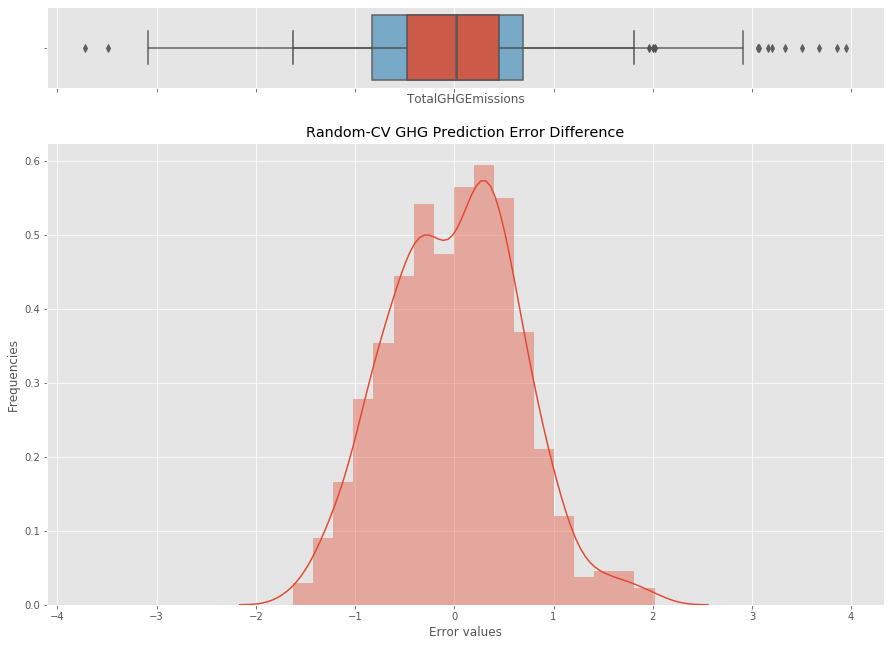

In [51]:
prediction = DfModelList[3]["model"].predict(X_test_complete)
#prediction = []
#for sublist in predictions_list:
#    for item in sublist:
#        prediction.append(item)
df_diff = pd.DataFrame(prediction - y_test_GHG)
mean = df_diff.mean().values
median = df_diff.median().values
print(mean, median)

binNumb = int(np.ceil(1 + np.log2(len(prediction))))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=a4_dims)

ax0 = sns.boxplot(log_ghg_data_2016, ax=ax_box, palette="Blues")
ax1 = sns.boxplot(df_diff, ax=ax_box)
ax2 = sns.distplot(df_diff)
ax2.set(xlabel='Error values', ylabel='Frequencies', title="Random-CV GHG Prediction Error Difference")

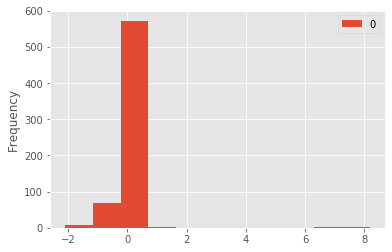

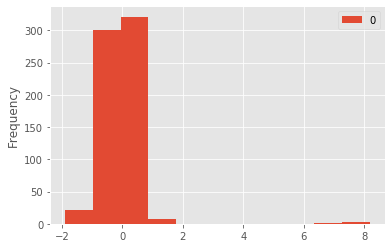

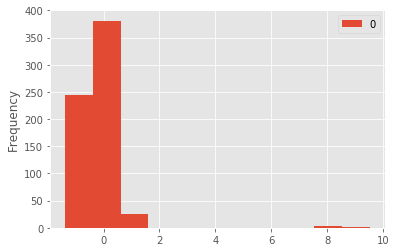

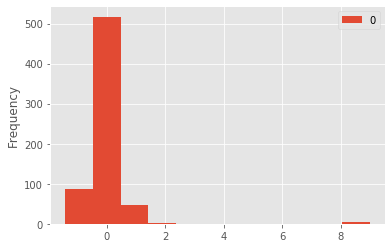

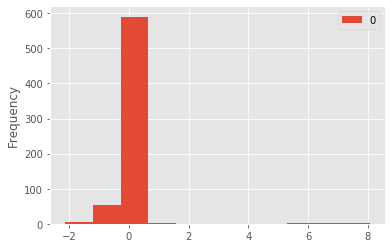

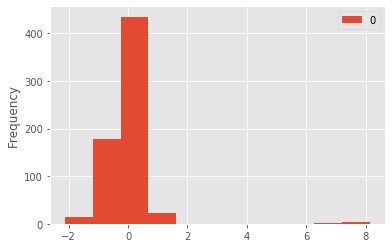

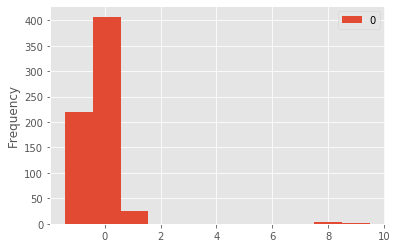

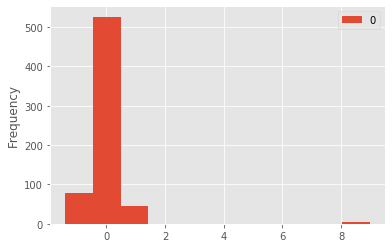

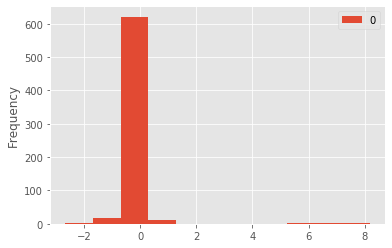

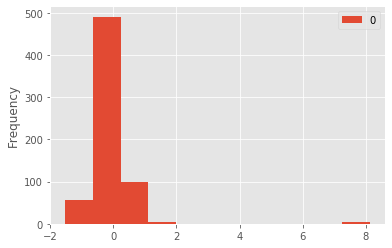

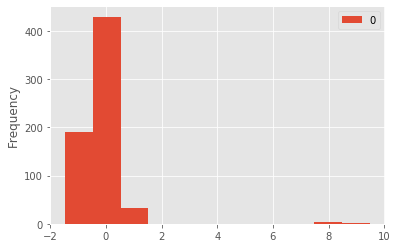

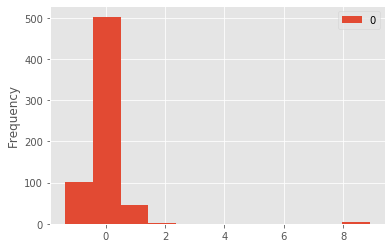

In [52]:
binNumb = int(np.ceil(1 + np.log2(len(DfModelList[0]['predict_test']))))
for model in DfModelList:
    df_diff = pd.DataFrame(model['predict_test'] - y_test_energy)
    df_diff.plot.hist(bins = binNumb)

In [53]:
model_df = pd.DataFrame.from_dict(DfModelList)
model_df = model_df.set_index(['modelName'])
model_df = model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].abs()
model_df

MapeTrain     MapeTest  MseTrain   MseTest
modelName                                                     
RCV dataset 0       12.479977   233.905973  0.593217  0.696921
RCV dataset 1        2.614498  1033.052237  0.613381  0.775186
RCV dataset 2        2.838701    18.676199  0.098642  0.242064
RCV dataset 3       30.189495    21.594782  0.475531  0.656854
GCV dataset 0       20.041887   271.507642  0.587708  0.685806
GCV dataset 1       25.647296   576.716418  0.678222  0.771083
GCV dataset 2        6.851350    13.063907  0.165104  0.259201
GCV dataset 3       31.878615    30.008423  0.563681  0.669862
GCV_boot dataset 0  19.921895   194.041389  0.593059  0.688857
GCV_boot dataset 1  21.285628   459.784130  0.729597  0.774070
GCV_boot dataset 2   9.708209    22.086609  0.197655  0.267927
GCV_boot dataset 3  37.208678    41.155161  0.600880  0.675659

In [54]:
model_df[1::2]['MseTest'].values

array([0.77518624, 0.65685408, 0.77108342, 0.66986184, 0.77407007,
       0.67565906])

In [55]:
dfs = pd.DataFrame(index = ['RCV dataset Energy', 'RCV dataset GHG', 'GCV dataset Energy', 'GCV dataset GHG',
       'GCV_boot dataset Energy', 'GCV_boot dataset GHG'])
#model_df[::2]['MseTest']
dfs["MseTestLeaked"] = model_df[::2]['MseTest'].values
dfs["MseTestcomplete"] = model_df[1::2]['MseTest'].values

dfs.iplot(kind="barh")


Unexpected error:  <class 'ValueError'>


ValueError: Number of features of the model must match the input. Model n_features is 46 and input n_features is 59 

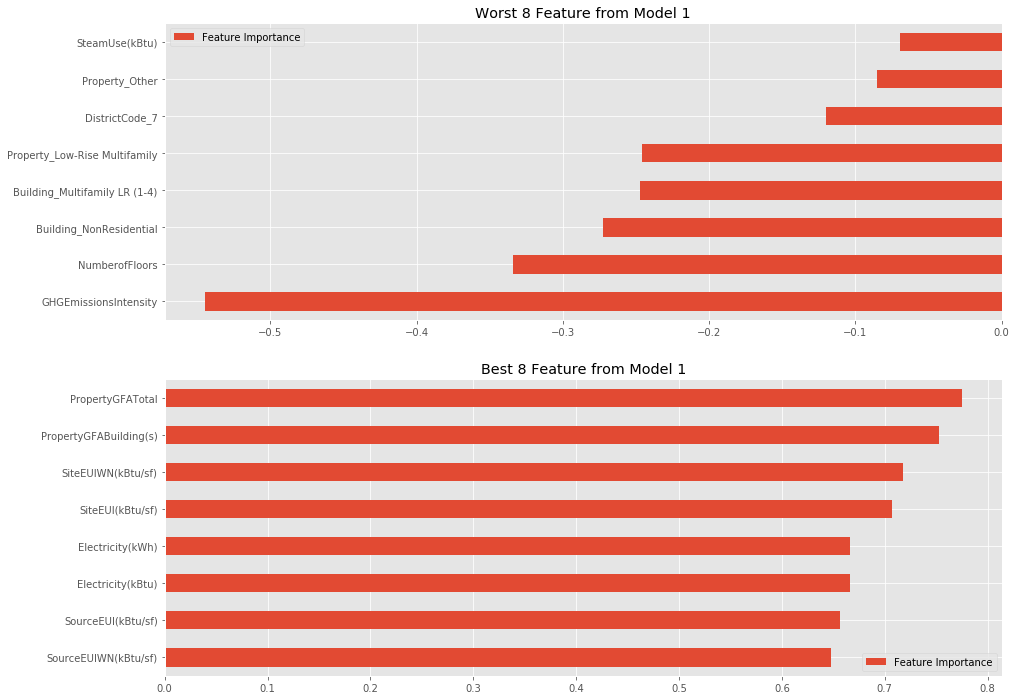

1.0183783173561096  minutes.


In [56]:
#Testing with fairml library 
#It combines 4 models of evaluation to score the features of the model. 

i = 1
for model in modelList:

    #  call audit model with model
    total, _ = audit_model(model['model'].predict, X)

    df_total = pd.DataFrame.from_dict(total.median(), orient='index')
    df_total.columns = ["Feature Importance"]
    df_total = df_total.sort_values(by="Feature Importance")
    
    fig, (ax1, ax2) = plt.subplots(nrows = 2)
    title = (" 8 Feature from Model %d" % i)
    df_total.head(8).plot.barh(ax=ax1, figsize = (15,12), title = ("Worst" +title))
    df_total.tail(8).plot.barh(ax=ax2, figsize = (15,12), title = ("Best" +title))
    print()
    i += 1

In [ ]:
df_total = pd.DataFrame.from_dict(total.median(), orient='index')
df_total.columns = ["Feature Importance"]
df_total = df_total.sort_values(by="Feature Importance")

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)

df_total.head(8).plot.barh(ax=ax1, figsize = (15,12))
df_total.tail(8).plot.barh(ax=ax2, figsize = (15,12))

##### Analysing Features' Importance

In [ ]:
for model in modelList:
    ft_imp = pd.DataFrame(model['model'].feature_importances_ , index = [X.columns[:]], columns = ['values'])
    #ft_imp = ft_imp.rename(columns = { 0: 'Features'})
    ft_imp.sort_values(by= 'values', axis = 0, ascending=False).iloc[0:15].plot(kind = 'barh', width=0.7).grid()

In [ ]:
for model in modelList:
    ft_imp = pd.DataFrame(model['model'].feature_importances_ , index = [X.columns[:]], columns = ['values'])
    #ft_imp = ft_imp.rename(columns = { 0: 'Features'})
    ft_imp.sort_values(by= 'values', axis = 0, ascending=True).iloc[0:15].plot(kind = 'barh', width=0.7).grid()

##### Evaluating models

In [ ]:
model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']]

In [ ]:
modelList[0]['modelName'] = "Model 1"
modelList[1]['modelName'] = "Model 2"
modelList[2]['modelName'] = "Model 3"

In [ ]:
model_df = pd.DataFrame.from_dict(DfModelList)
model_df = model_df.set_index(['modelName'])
model_df = model_df[['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].abs()

In [ ]:
model_df[:4][['MapeTrain', 'MapeTest', 'MseTrain', 'MseTest']].plot(kind='barh', figsize=(15, 12)).grid()
plt.xlabel('Scores', fontsize=13)
plt.ylabel('Modeles', fontsize=13)
plt.title('Performance des 3 models finaux', fontname="Arial Black", size=15)

#####  Evaluation

Evaluation of Random CV Search

In [ ]:
RDF_CV_accuracy_test = rf_random.score(X_test,y_test_energy)
print('\naccuracy_score on test dataset : ', RDF_CV_accuracy_test)

In [ ]:
base_accuracy = evaluate(rf_random, X_test, y_test_energy)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test_energy)